# Proyecto IA - Aprendizaje por Refuerzo
---

## Integrantes
- Andrés Francisco García Rivero
- Jorge Muñoz Rodríguez

### 0.- Funciones comunes

In [252]:
import numpy as np
import mdptoolbox.mdp as mdp
import matplotlib.pyplot as plt

In [253]:
def lee_mapa(fichero):
    with open(fichero,'r') as archivo:
        lineas = archivo.readlines()
    numeros = [float(numero) for numero in lineas[0].split()]
    lineas.pop(0)
    lineas.reverse()
    matriz = []
    for linea in lineas:
        fila = [int(caracter) for caracter in linea.strip()]
        matriz.append(fila)
    return np.array(matriz),(int(numeros[0]),int(numeros[1]))

In [290]:
mapa,destino = lee_mapa("map.txt")
m,n = mapa.shape
movimientos = {
    'wait': (0, 0), 'N': (0, 1), 'NE': (1, 1), 'E': (1, 0),
    'SE': (1, -1), 'S': (0, -1), 'SO': (-1, -1), 'O': (-1, 0), 'NO': (-1, 1)
}
nav_estados = [(i, j) for i in range(n) for j in range(m)]
nav_acciones = ['wait','N','NE','E','SE','S','SO','O','NO']

In [255]:
def parsea_politica_ql(ql):
    return [nav_acciones[i] for i in ql.policy]

In [256]:
def inicializa_posicion(mapa, destino):
    inicio = np.random.randint(n), np.random.randint(m)
    intentos = 0
    max_intentos = 1000
    while mapa[inicio[1],inicio[0]] == 1 or inicio == destino:
        inicio = np.random.randint(n), np.random.randint(m)
        intentos += 1
        if intentos > max_intentos:
            raise ValueError("No se pudo encontrar una posición inicial válida.")
    return inicio

In [257]:
def visualiza_mapa():
    plt.figure(figsize=(len(mapa[0]), len(mapa)))
    plt.imshow(1-mapa, cmap='gray', interpolation='none')
    plt.xlim(-0.5, len(mapa[0]) - 0.5)
    plt.ylim(-0.5, len(mapa) - 0.5)
    plt.gca().add_patch(plt.Circle(destino,radius = 0.5,edgecolor = 'blue', facecolor = 'blue'))

In [258]:
# Verificar si hay colisión
def hay_colision(estado):
    return mapa[estado[1],estado[0]] == 1

# Definir los movimientos posibles
def aplica_accion(estado, accion):
    if hay_colision(estado):
        return estado
    x = estado[0] + movimientos[accion][0]
    y = estado[1] + movimientos[accion][1]
    if x < 1 or x >= mapa.shape[1]-1 or y < 1 or y >= mapa.shape[0]-1 or hay_colision((x, y)):
        return estado
    return x, y

In [259]:
K1 = -1000
K2 = -10000

def obtiene_recompensa_simple(estado):
    if hay_colision(estado):
        valor = K1
    else:
        valor = - np.sqrt( (estado[0]-destino[0])**2 + (estado[1]-destino[1])**2)*0.5
    return valor

def obtiene_recompensa(estado, accion):
    nuevo_estado = aplica_accion(estado, accion)
    if hay_colision(nuevo_estado):
        return K2
    if accion == 'wait' and estado != destino:
        return K1
    return -np.sqrt((nuevo_estado[0] - destino[0])**2 + (nuevo_estado[1] - destino[1])**2)*0.5

In [260]:
def visualiza_politica(politica):
    visualiza_mapa()
    for p in zip(nav_estados,politica):
        accion = p[1]
        if accion=='wait':
            # Si no está en un obstaculo, escribimos la política
            if not hay_colision(p[0]):
                plt.text(p[0][0],p[0][1],'WAIT',fontsize=40,ha='center',va='center', color='red', fontweight='bold')
            continue
        estado = p[0]
        e1 = aplica_accion(estado,accion)
        x0 = estado[0]
        y0 = estado[1]
        x1 = e1[0]
        y1 = e1[1]
        
        plt.gca().arrow(x0, y0, (x1 - x0)*0.6, (y1 - y0)*0.6,
         head_width=0.3, head_length=0.3, fc='black', ec='black')

In [261]:
def visualiza_recompensas():
    visualiza_mapa()
    recompensas = [obtiene_recompensa_simple(e) for e in nav_estados]
    recompensas = [np.nan if elemento == K1 else elemento for elemento in recompensas]
    max_recompensa = np.nanmax(recompensas)
    min_recompensa = np.nanmin(recompensas)
    for e in nav_estados:
        r = obtiene_recompensa_simple(e)
        if r == K1:
            continue
        a = (r-min_recompensa)/(max_recompensa-min_recompensa)
        rect = plt.Rectangle((e[0] - 0.5, e[1] - 0.5), 1, 1, alpha = a,linewidth=1, edgecolor='blue', facecolor='blue')
        plt.gca().add_patch(rect)

In [262]:
# Método para visualizar el mapa con la política óptima
def visualiza_politica_letras(politica, mapa, destino):
    plt.figure(figsize=(20, 20))
    plt.imshow(1 - mapa, cmap='gray', origin='lower')

    # Dibujar el destino y la posición inicial con las coordenadas ajustadas si es necesario
    plt.gca().add_patch(plt.Circle(destino, radius=0.3, edgecolor='red', facecolor='red', label='Destino'))

    # Dibujar las políticas
    for i in range(n):
        for j in range(m):
            if mapa[j, i] == 0:  # Ajuste a la indexación correcta si es necesario
                s_index = i * m + j
                accion = nav_acciones[politica[s_index]]
                if accion == 'wait':
                    print(f"Esperar en {i, j}")
                    plt.text(i, j, 'WAIT', ha='center', va='center', color='blue', fontsize=12)
                else:
                    plt.text(i, j, accion, ha='center', va='center', color='brown', fontsize=12)

    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='Destino'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Wait'),
    ])
    plt.show()

### Apartado 1: Implementación mediante Q-Learning

Q-learning es un algoritmo de aprendizaje por refuerzo basado en la idea de aprendizaje mediante ensayo y error. Su principal objetivo es descubrir la estrategia óptima que guía las acciones del agente para maximizar el valor esperado de las recompensas futuras. El agente aprende a estimar el valor de cada acción posible en un estado específico.

#### Componentes de Q-Learning

- **Estados (S):** El conjunto de todos los posibles estados en el entorno.

- **Acciones (A):** El conjunto de todas las posibles acciones que el agente puede tomar.

- **Recompensas (R):** La recompensa inmediata recibida después de la transición de un estado a otro al tomar una acción específica.

- **Valores Q (Q):** Una tabla o función que asigna pares estado-acción a valores, representando el beneficio a largo plazo de tomar una acción en un estado específico.


In [263]:
Perror = 0.1  # Probabilidad de error en el movimiento
print("Mapa de tamaño",m,"filas x",n,"columnas")

Mapa de tamaño 15 filas x 51 columnas


In [264]:
def crea_recompensas_sistema():
    matriz = []
    for e in nav_estados:
        fila = [obtiene_recompensa(e, accion) for accion in nav_acciones]
        matriz.append(fila)
    return np.array(matriz)

nav_recompensas_sistema = crea_recompensas_sistema()

In [265]:
def obtiene_indice_estado(estado):
    return int(estado[0]*mapa.shape[0]+estado[1])

In [266]:
def obtiene_posibles_errores(accion):
    errores_dict = {
        'N': ['NE', 'NO'], 'S': ['SE', 'SO'], 'E': ['NE', 'SE'], 'O': ['NO', 'SO'],
        'NE': ['N', 'E'], 'NO': ['N', 'O'], 'SE': ['S', 'E'], 'SO': ['S', 'O']
    }
    return errores_dict.get(accion, [])

In [267]:
def crea_transiciones_movimiento(accion, prob_error):
    matriz = []
    for e0 in nav_estados:
        fila = [0] * len(nav_estados)
        if hay_colision(e0):
            fila[obtiene_indice_estado(e0)] = 1
        else:
            goal = aplica_accion(e0, accion)
            if prob_error == 0:
                fila[obtiene_indice_estado(goal)] = 1
            else:
                errores = obtiene_posibles_errores(accion)
                fila[obtiene_indice_estado(goal)] = 1 - prob_error
                for error in errores:
                    goal_error = aplica_accion(e0, error)
                    fila[obtiene_indice_estado(goal_error)] += prob_error / len(errores)
        suma_fila = sum(fila)
        if suma_fila != 1:
            fila = [x / suma_fila for x in fila]
        matriz.append(fila)
    return np.array(matriz)


In [268]:
def crea_transiciones_sistema(prob_error):
    return np.array([crea_transiciones_movimiento(accion, prob_error) for accion in nav_acciones])

nav_transiciones_sistema = crea_transiciones_sistema(Perror)

#### Q-Learning con mdptoolbox y Diferentes Valores de Descuento

Ahora vamos a realizar una prueba utilizando el algoritmo Q-Learning implementado en la biblioteca `mdptoolbox`. Probaremos con diferentes valores del factor de descuento $\gamma$	 para observar cómo afectan al comportamiento del agente. El factor de descuento $\gamma$ es un número entre 0 y 1 que determina la importancia de las recompensas futuras frente a las recompensas inmediatas. Valores más altos de $\gamma$ harán que el agente valore más las recompensas a largo plazo, mientras que valores más bajos harán que el agente se concentre en las recompensas inmediatas.

#### Valores de Descuento $\gamma$	 y su Impacto

- **\($\gamma$	 = 0\)**:
  - **Impacto**: Solo se consideran las recompensas inmediatas.
  - **Comportamiento**: El agente toma decisiones basadas únicamente en las recompensas inmediatas, sin considerar el futuro.

- **\($\gamma$	 = 0.5\)**:
  - **Impacto**: Las recompensas futuras se valoran, pero con menor peso.
  - **Comportamiento**: El agente equilibra entre recompensas inmediatas y futuras, considerando el futuro pero no de manera determinante.

- **\($\gamma$	 = 0.9\)**:
  - **Impacto**: Las recompensas futuras son casi tan importantes como las inmediatas.
  - **Comportamiento**: El agente toma decisiones que maximizan las recompensas a largo plazo.

Vamos a realizar cuatro ejecuciones del algoritmo, cada una con 30,000 iteraciones. Utilizaremos distintos factores de descuento en cada ejecución: 0.1, 0.5, 0.8 y 0.99. Esto nos permitirá observar cómo la variación en el factor de descuento influye en la optimización de las recompensas a largo plazo.

In [269]:
ql_a = mdp.QLearning(nav_transiciones_sistema, nav_recompensas_sistema, discount=0.01, n_iter=30000)
ql_a.run()
politica_ql_a = parsea_politica_ql(ql_a)
ql_b = mdp.QLearning(nav_transiciones_sistema, nav_recompensas_sistema, discount=0.50, n_iter=30000)
ql_b.run()
politica_ql_b = parsea_politica_ql(ql_b)
ql_c = mdp.QLearning(nav_transiciones_sistema, nav_recompensas_sistema, discount=0.90, n_iter=10000)
ql_c.run()
politica_ql_c = parsea_politica_ql(ql_c)
ql_d = mdp.QLearning(nav_transiciones_sistema, nav_recompensas_sistema, discount=0.90, n_iter=100000)
ql_d.run()
politica_ql_d = parsea_politica_ql(ql_d)
ql_e = mdp.QLearning(nav_transiciones_sistema, nav_recompensas_sistema, discount=0.99, n_iter=30000)
ql_e.run()
politica_ql_e = parsea_politica_ql(ql_e)

#### A - Descuento 0.10 y 30,000 Iteraciones

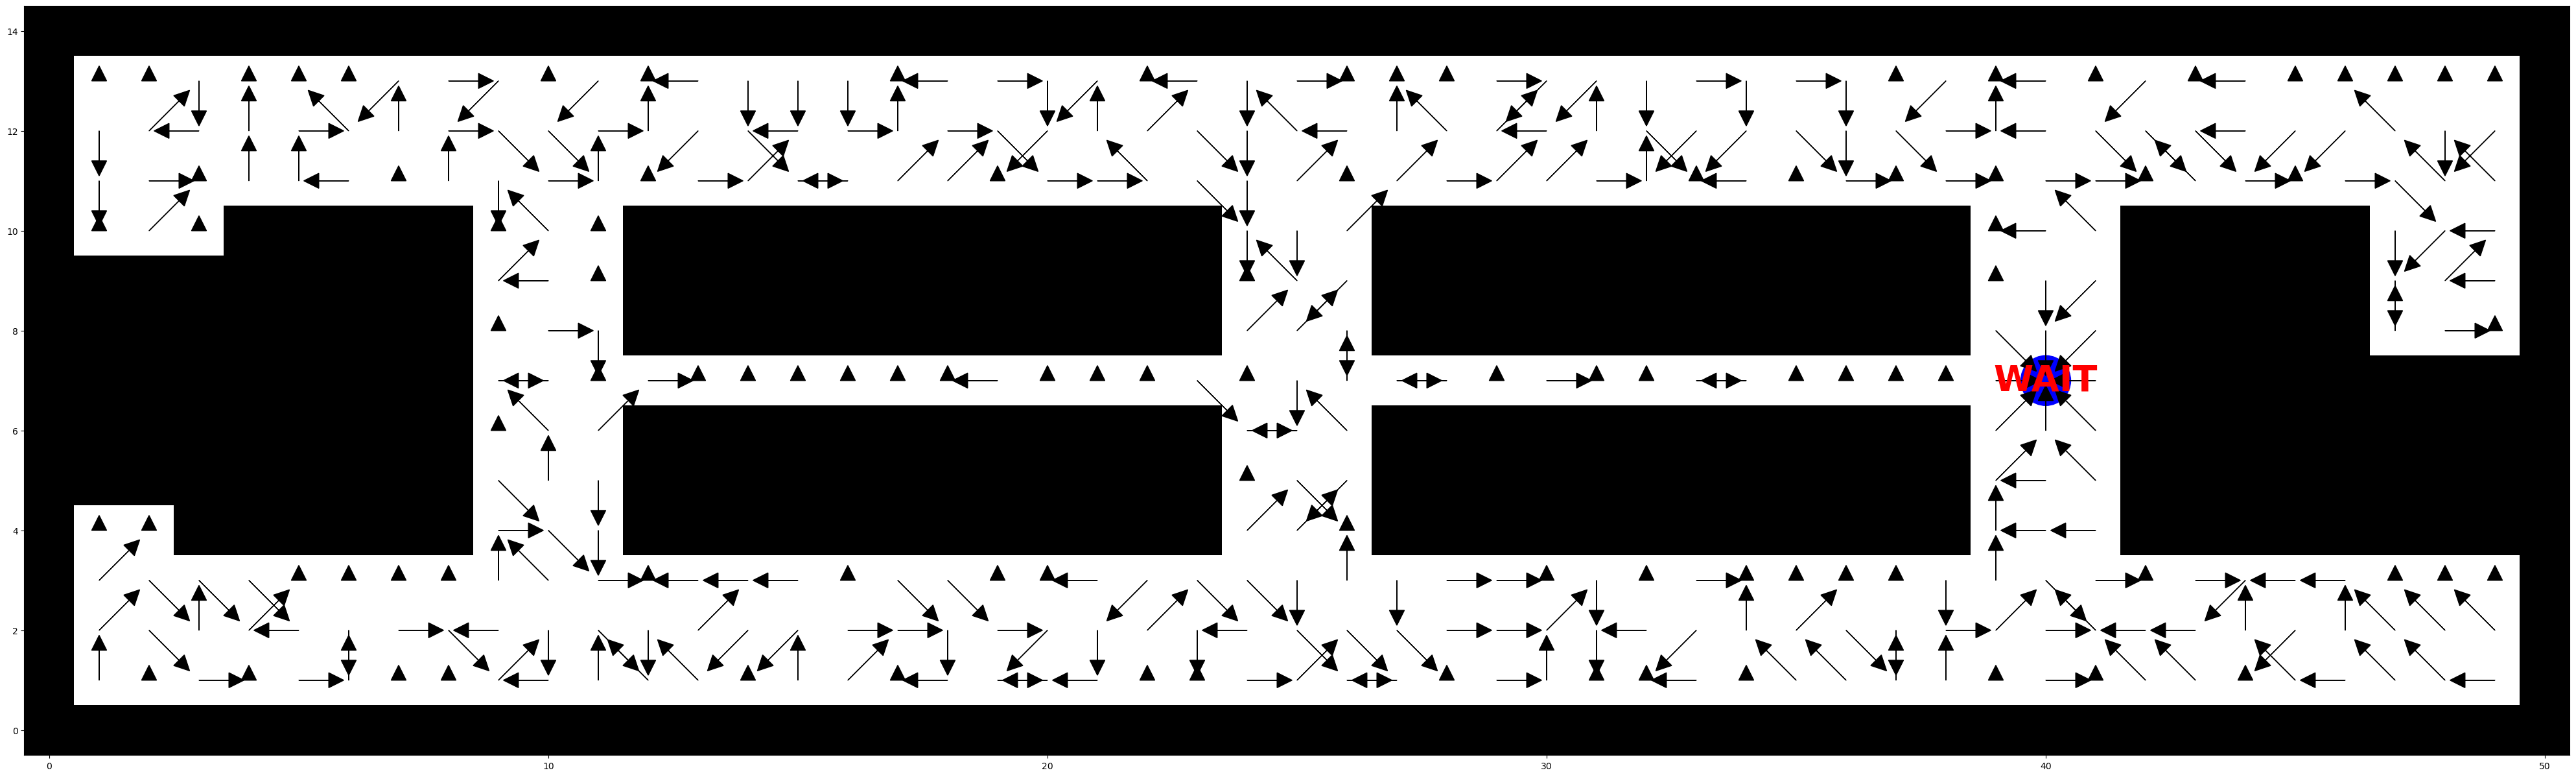

In [270]:
visualiza_politica(politica_ql_a)

#### B - Descuento 0.50 y 30,000 Iteraciones

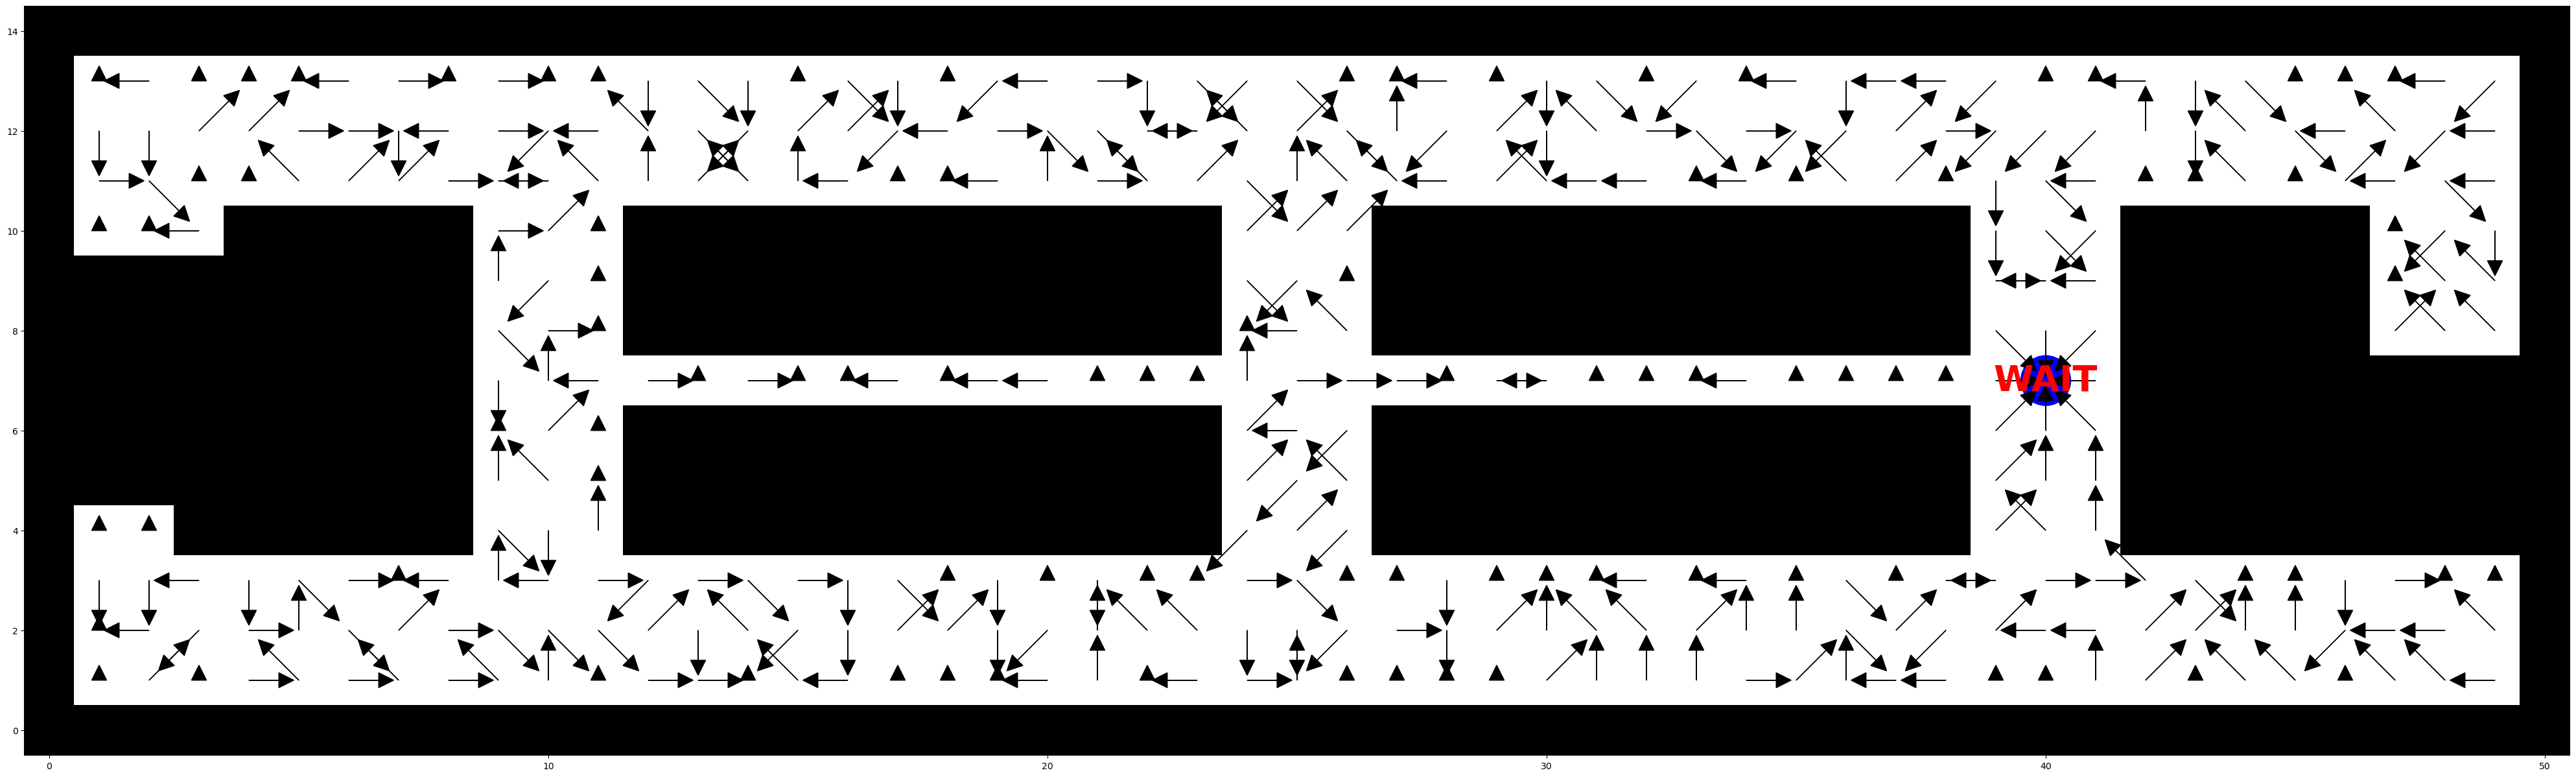

In [271]:
visualiza_politica(politica_ql_b)

#### C - Descuento 0.90 y 10,000 Iteraciones

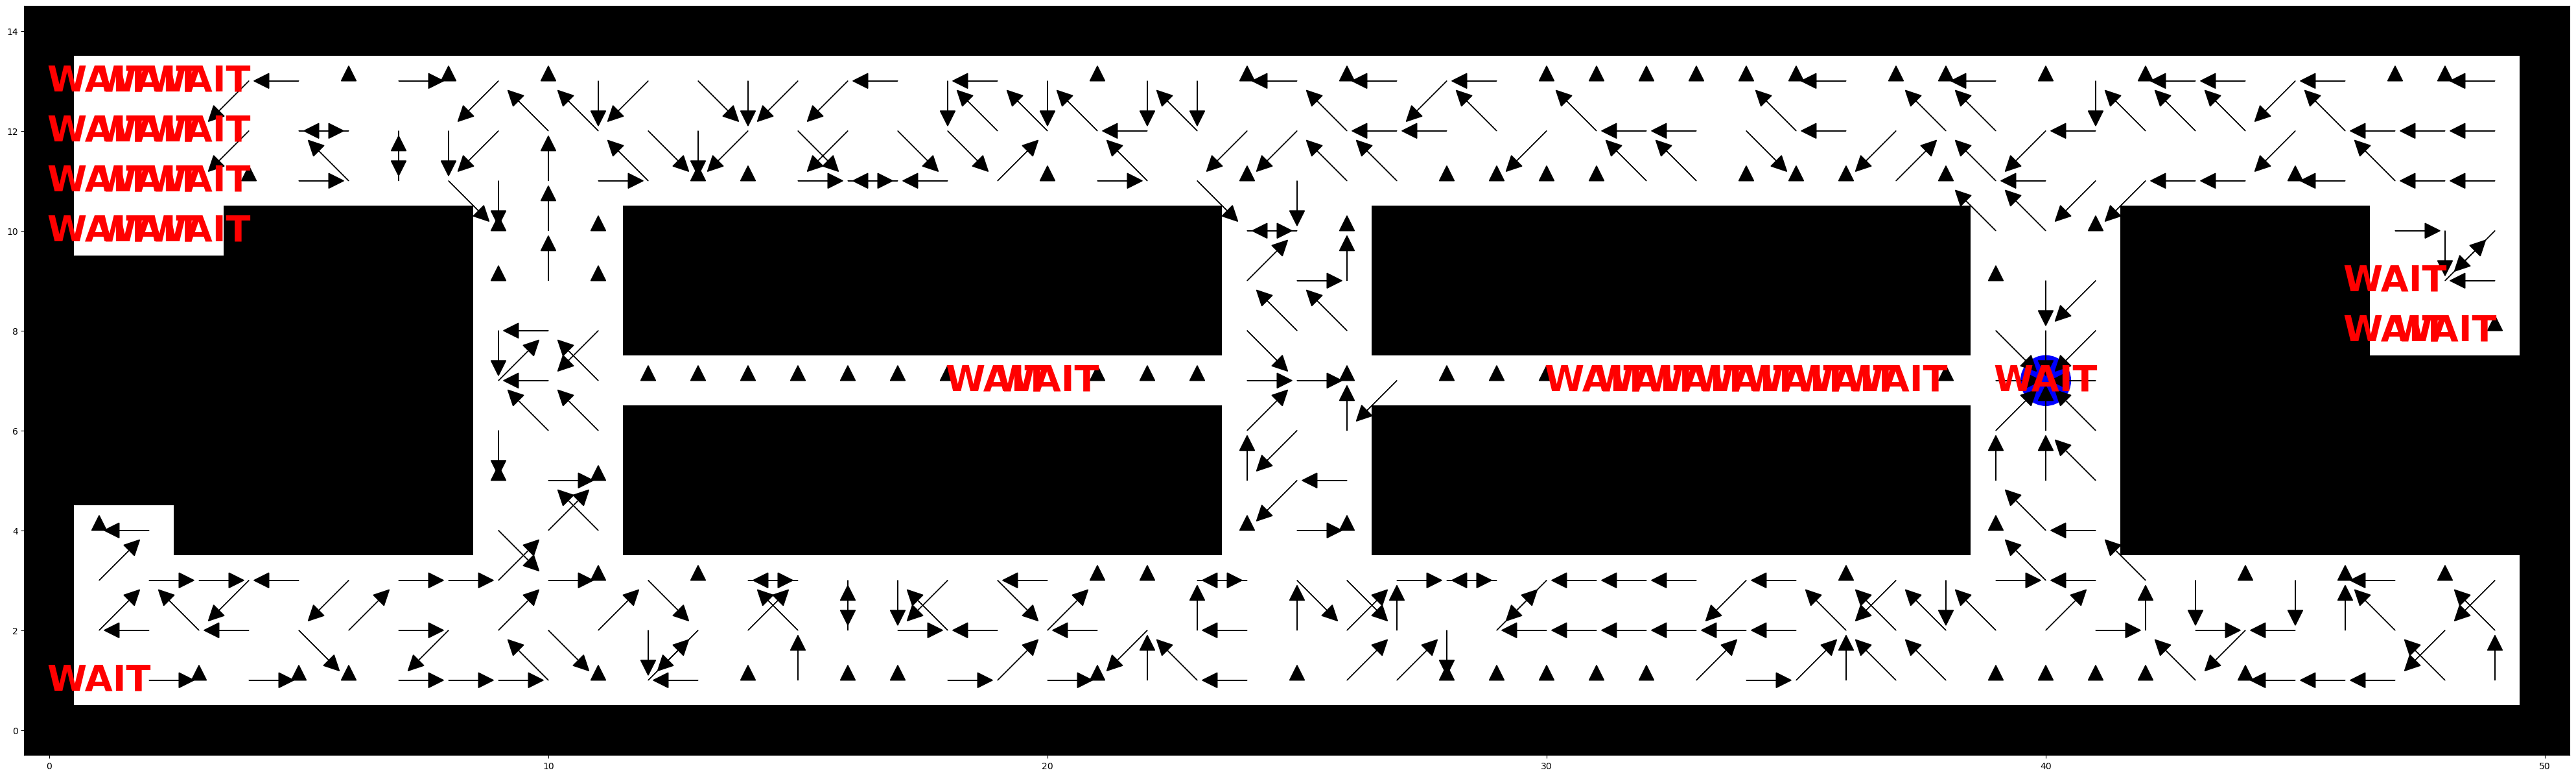

In [272]:
visualiza_politica(politica_ql_c)

#### D - Descuento 0.90 y 100,000 Iteraciones

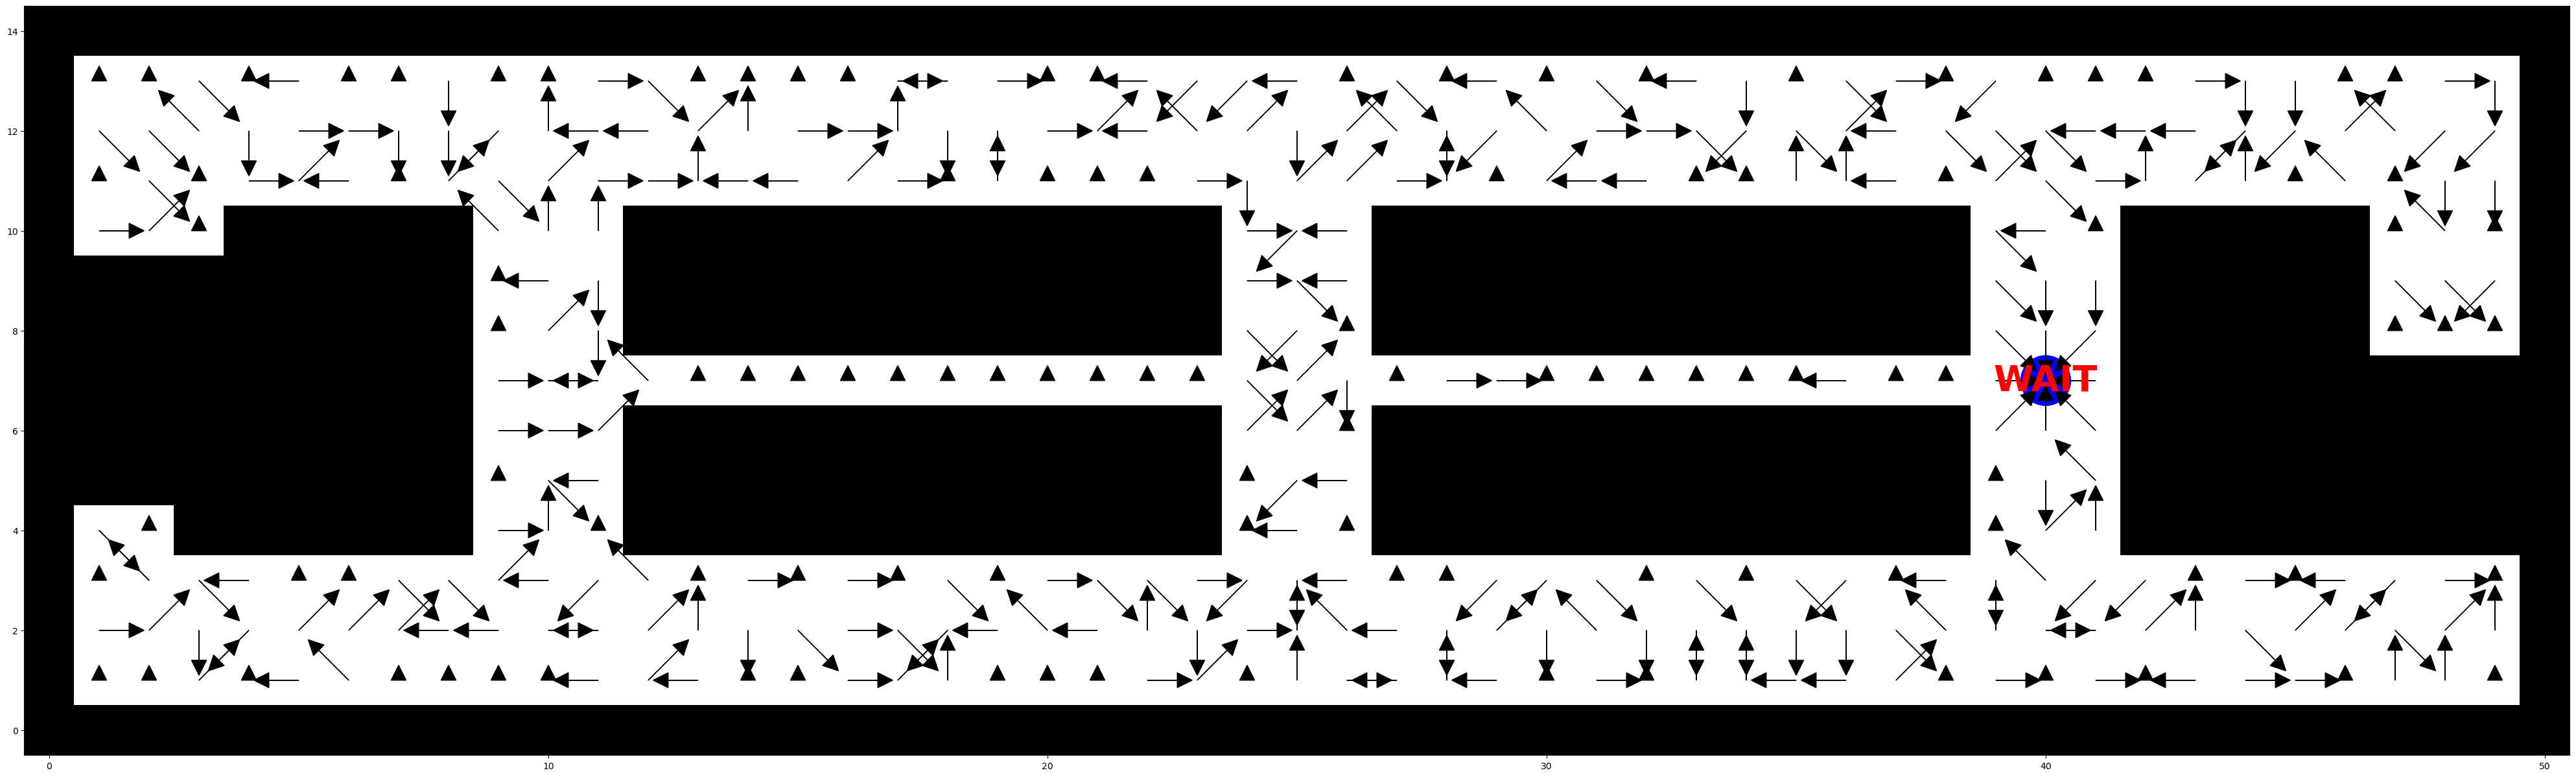

In [273]:
visualiza_politica(politica_ql_d)

#### E - Descuento 0.99 y 30,000 Iteraciones

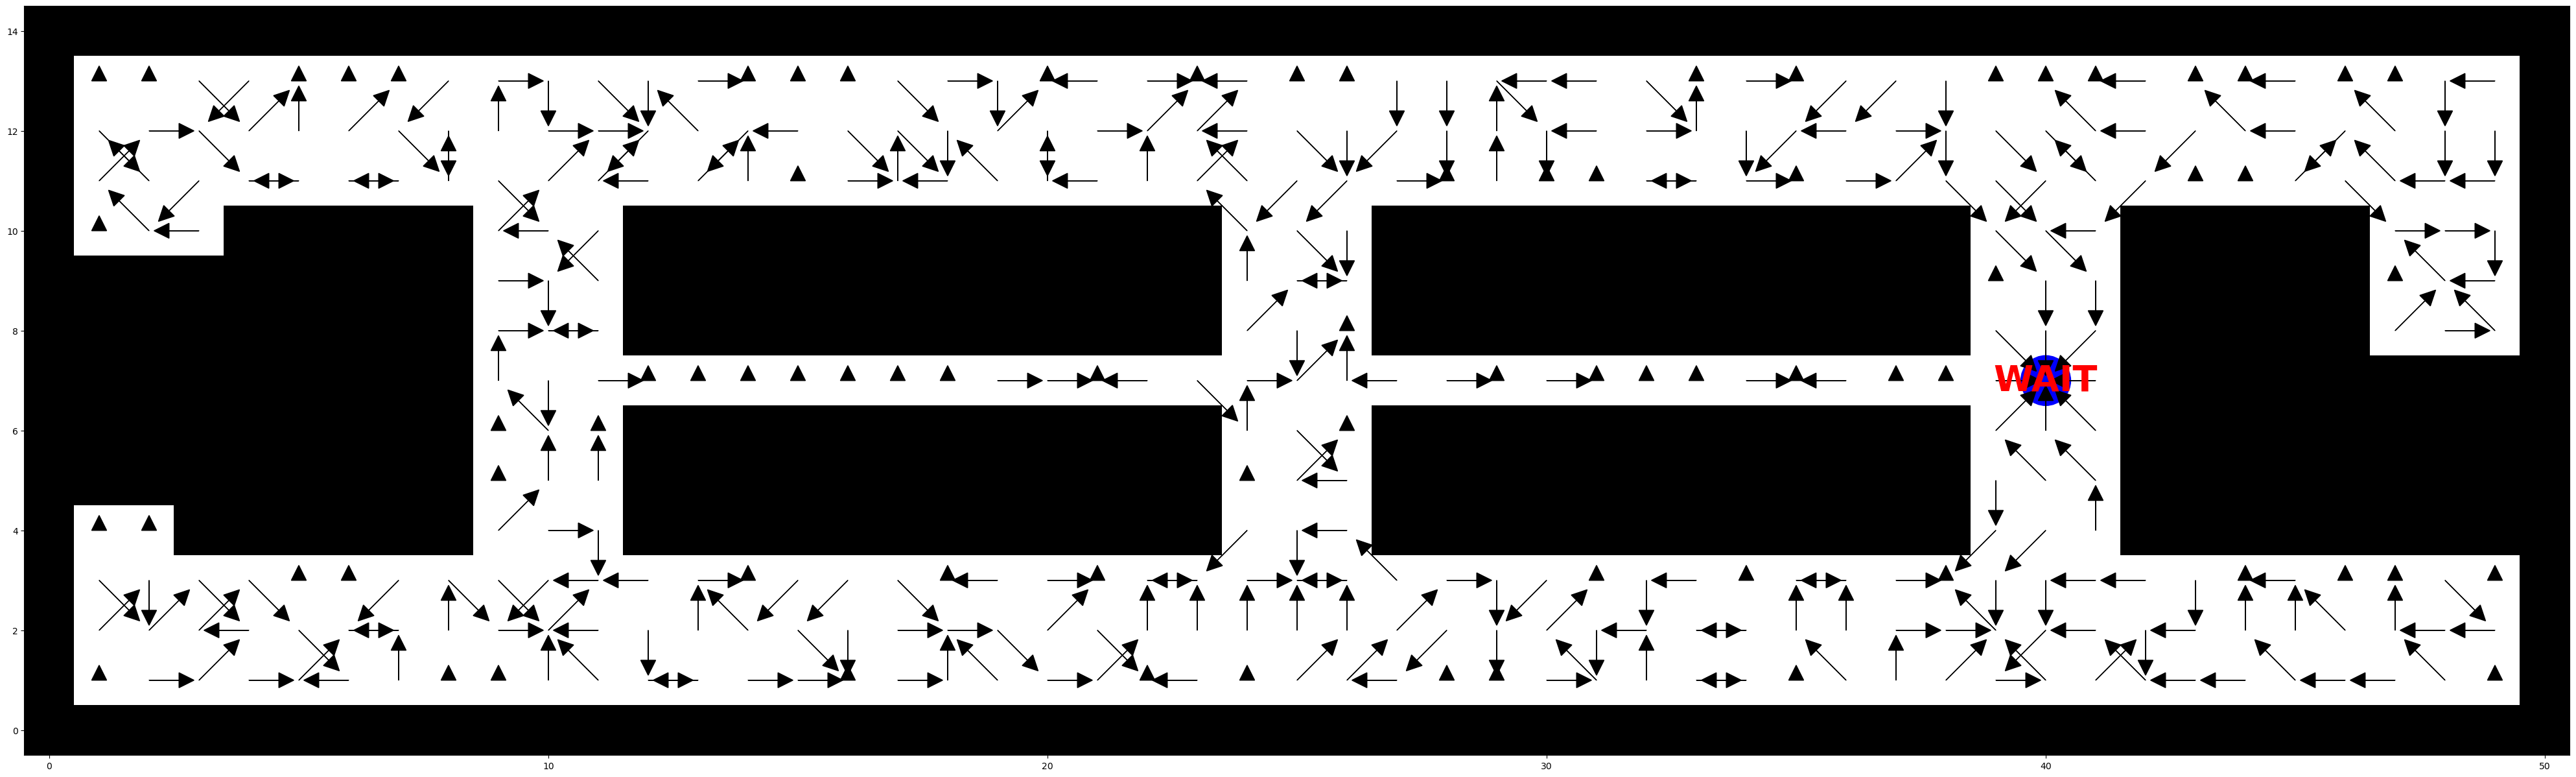

In [274]:
visualiza_politica(politica_ql_e)

### Apartado 2: Implementación mediante Montecarlo

El método de Montecarlo es una técnica computacional que se utiliza para entender y aproximar soluciones de problemas complejos mediante la simulación de procesos aleatorios. Su principal ventaja es la capacidad de modelar sistemas complejos y obtener aproximaciones estadísticas a problemas que son difíciles de resolver analíticamente.

#### Componentes del Método de Montecarlo

- **Variables aleatorias (V):** Conjunto de variables que influyen en el sistema y cuya variabilidad es modelada usando distribuciones de probabilidad.

- **Simulaciones (S):** Conjunto de todas las ejecuciones del modelo, donde cada simulación representa una instancia del sistema bajo condiciones aleatorias específicas.

- **Resultados (R):** Los resultados obtenidos de cada simulación, que pueden incluir estimaciones de probabilidades, cálculos de promedios, o la evaluación de escenarios específicos.

- **Estimaciones (E):** Cálculos derivados de agrupar y analizar los resultados de múltiples simulaciones para obtener una estimación robusta y representativa del comportamiento del sistema.

Este enfoque permite utilizar la potencia del cálculo estocástico para explorar y analizar la dinámica y las consecuencias de diferentes escenarios, haciendo del método de Montecarlo una herramienta invaluable en campos como la física, la ingeniería, las finanzas y más.

In [275]:
# Política Epsilon-Greedy
def crea_politica_greedy():
    p = []
    for e in nav_estados:
        valores = []
        for a in nav_acciones:
            e1 = aplica_accion(e,a)
            valores.append(obtiene_recompensa_simple(e1))
        accion = nav_acciones[np.argmax(valores)]
        p.append(accion)
    return p
politica_greedy = crea_politica_greedy()


In [276]:
def greedy_policy(state, Q):
    # Selecciona la acción con el máximo valor Q para el estado dado
    return max(Q[state], key=Q[state].get)

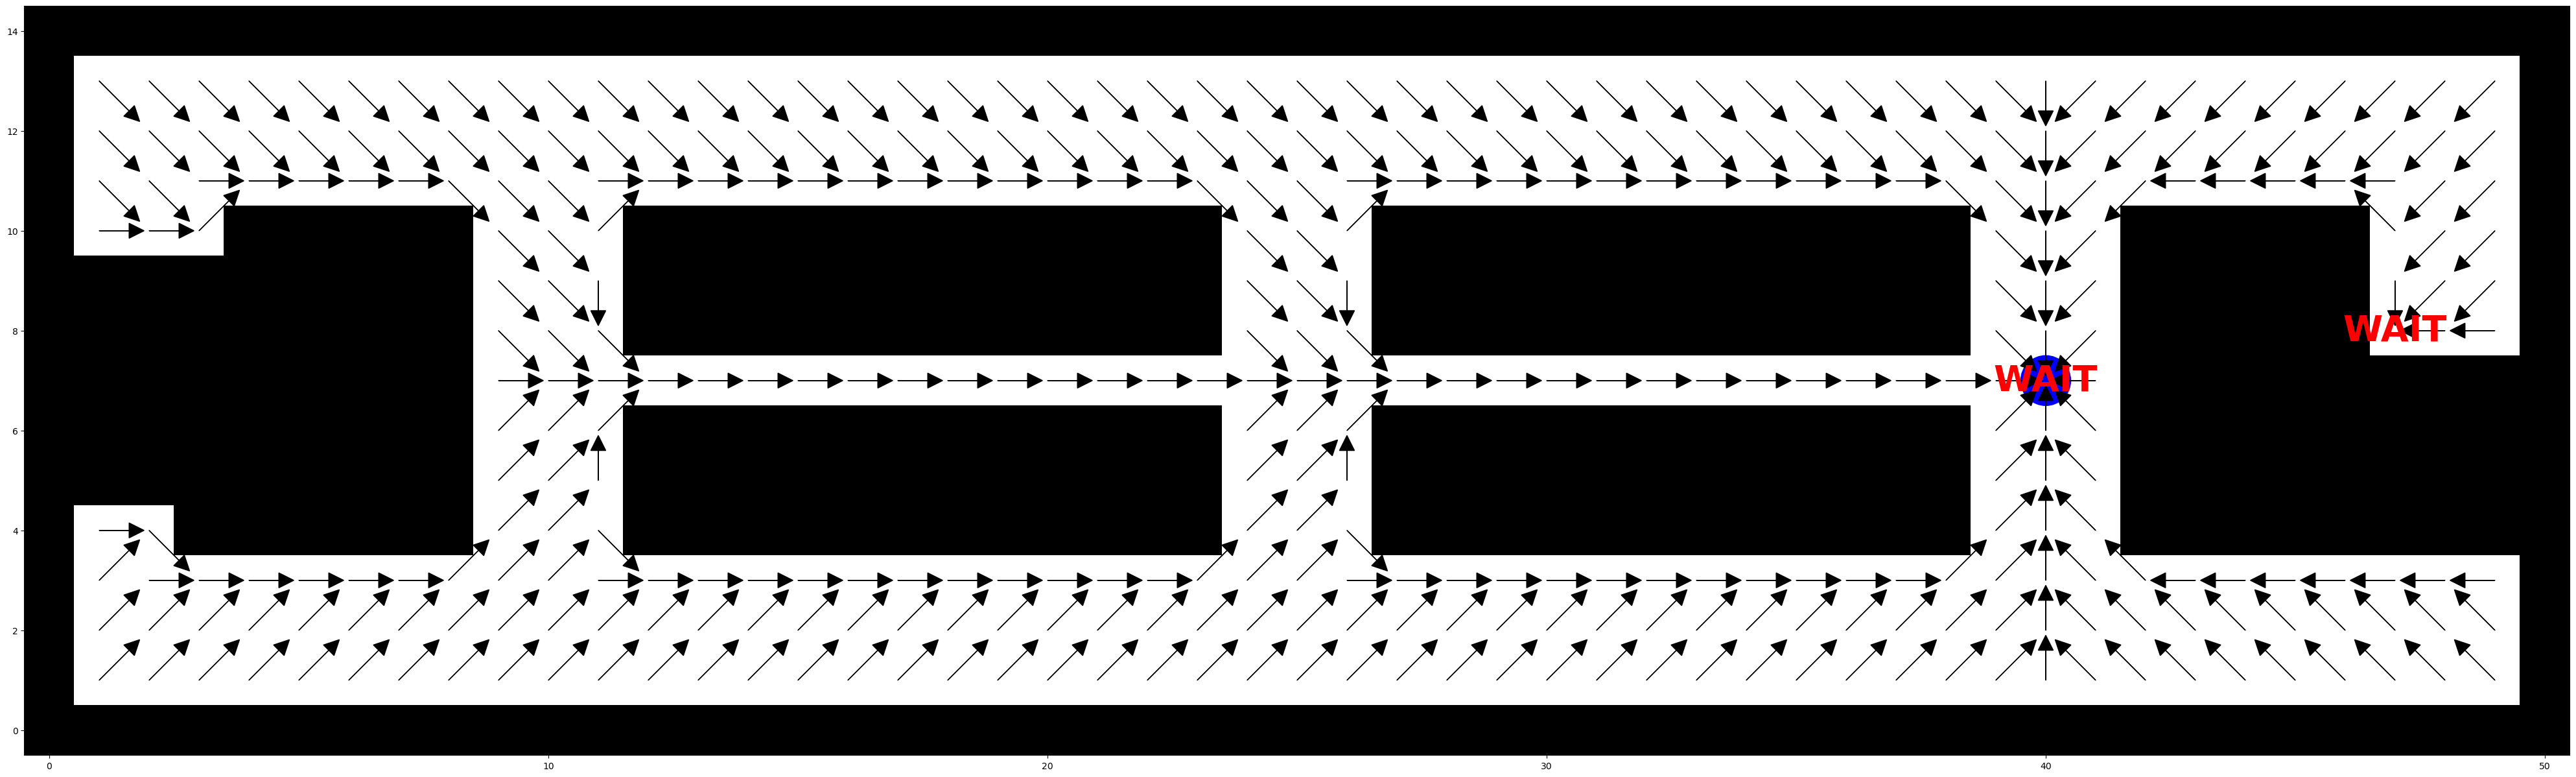

In [304]:
visualiza_politica(politica_greedy)

In [277]:
# Función Monte Carlo
def monte_carlo(mapa, destino, num_episodes, gamma=0.95):
    Q = {estado: {accion: 0 for accion in nav_acciones} for estado in nav_estados}
    N = {estado: {accion: 0 for accion in nav_acciones} for estado in nav_estados}
    
    for _ in range(num_episodes):
        estado = inicializa_posicion(mapa, destino)
        episodio = []
        while len(episodio) < 1000:
            accion = greedy_policy(estado, Q)
            nuevo_estado = aplica_accion(estado, accion)
            recompensa = obtiene_recompensa(estado, accion)
            episodio.append((estado, accion, recompensa))
            if nuevo_estado == destino or accion == 'wait':
                break
            estado = nuevo_estado

        G = 0
        for estado, accion, recompensa in reversed(episodio):
            G = gamma * G + recompensa
            N[estado][accion] += 1
            Q[estado][accion] = ((N[estado][accion] - 1) * Q[estado][accion] + G) / N[estado][accion]

    # Extraer la política óptima
    politica_optima = [max(Q[estado], key=Q[estado].get) for estado in nav_estados]
    return politica_optima


#### Impacto del Número de Episodios en la Convergencia

En el contexto de los métodos de Montecarlo aplicados al aprendizaje por refuerzo, un "episodio" se refiere a una secuencia completa de interacciones del agente con el entorno que comienza en un estado inicial y termina en un estado terminal o después de un número predefinido de pasos. Cada episodio es una realización completa del proceso que el agente está aprendiendo a navegar. En Montecarlo, la política del agente se evalúa y se mejora basándose en la experiencia acumulada al completar estos episodios. El número de episodios jugados tiene un impacto directo en la efectividad y la convergencia del aprendizaje del algoritmo. Aquí vemos cómo diferentes cantidades de episodios pueden afectar el proceso de aprendizaje:

- **100 episodios**:
   - **Bajo número de episodios**: Aquí, el agente tiene muy pocas interacciones con el entorno, lo que puede resultar en una comprensión y una aproximación muy limitadas de la política óptima. La política aprendida puede ser subóptima y no generalizar bien a diferentes estados del entorno.

- **1,000 episodios**:
   - **Moderadamente bajo**: Con más episodios, el agente comienza a tener una mejor idea de las recompensas y las transiciones del entorno. Sin embargo, aún puede no ser suficiente para alcanzar la convergencia en problemas más complejos o en entornos con una gran cantidad de estados o acciones.

- **5,000 episodios**:
   - **Moderado**: Este nivel de interacción permite una exploración más extensa y una mejor estimación de la función de valor. El algoritmo tiene más oportunidades de ajustar su política basada en un espectro más amplio de situaciones encontradas, llevando a una mejor convergencia en comparación con los dos casos anteriores.

- **100,000 episodios**:
   - **Alto número de episodios**: En este punto, el algoritmo ha tenido una cantidad significativa de interacciones, lo que le permite explorar profundamente el entorno y refinar considerablemente su política. Esto es particularmente útil en entornos complejos donde las relaciones entre acciones y estados no son inmediatamente obvias. La política resultante suele ser mucho más robusta y cerca de la óptima.


In [300]:
politica_mc_episodes_low = monte_carlo(mapa, destino, 1000)
politica_mc_episodes_mid = monte_carlo(mapa, destino, 5000)
politica_mc_episodes_high = monte_carlo(mapa, destino, 10000)
politica_mc_gamma_low = monte_carlo(mapa, destino, 5000, gamma=0.5)
politica_mc_gamma_mid = monte_carlo(mapa, destino, 5000, gamma=0.75)
politica_mc_gamma_high = monte_carlo(mapa, destino, 5000, gamma=0.99)
politica_mc_optima = monte_carlo(mapa, destino, 5000, gamma=0.95)

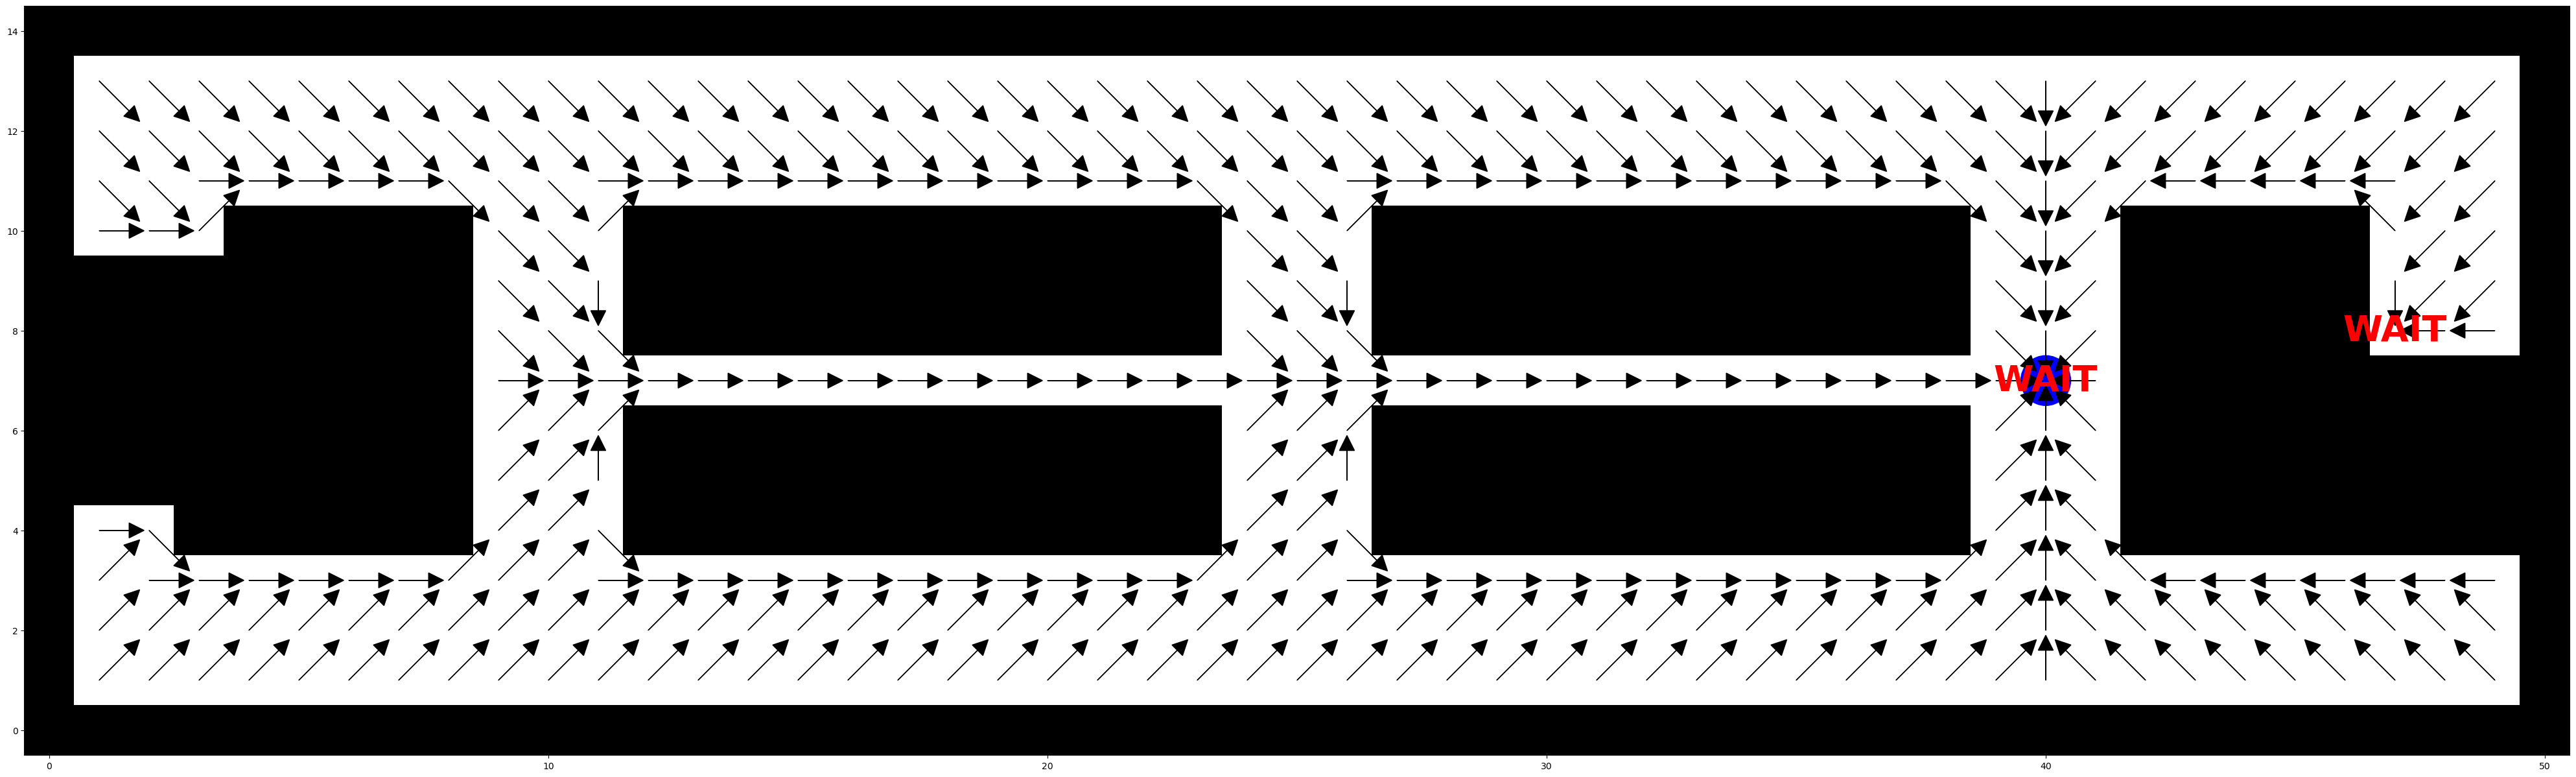

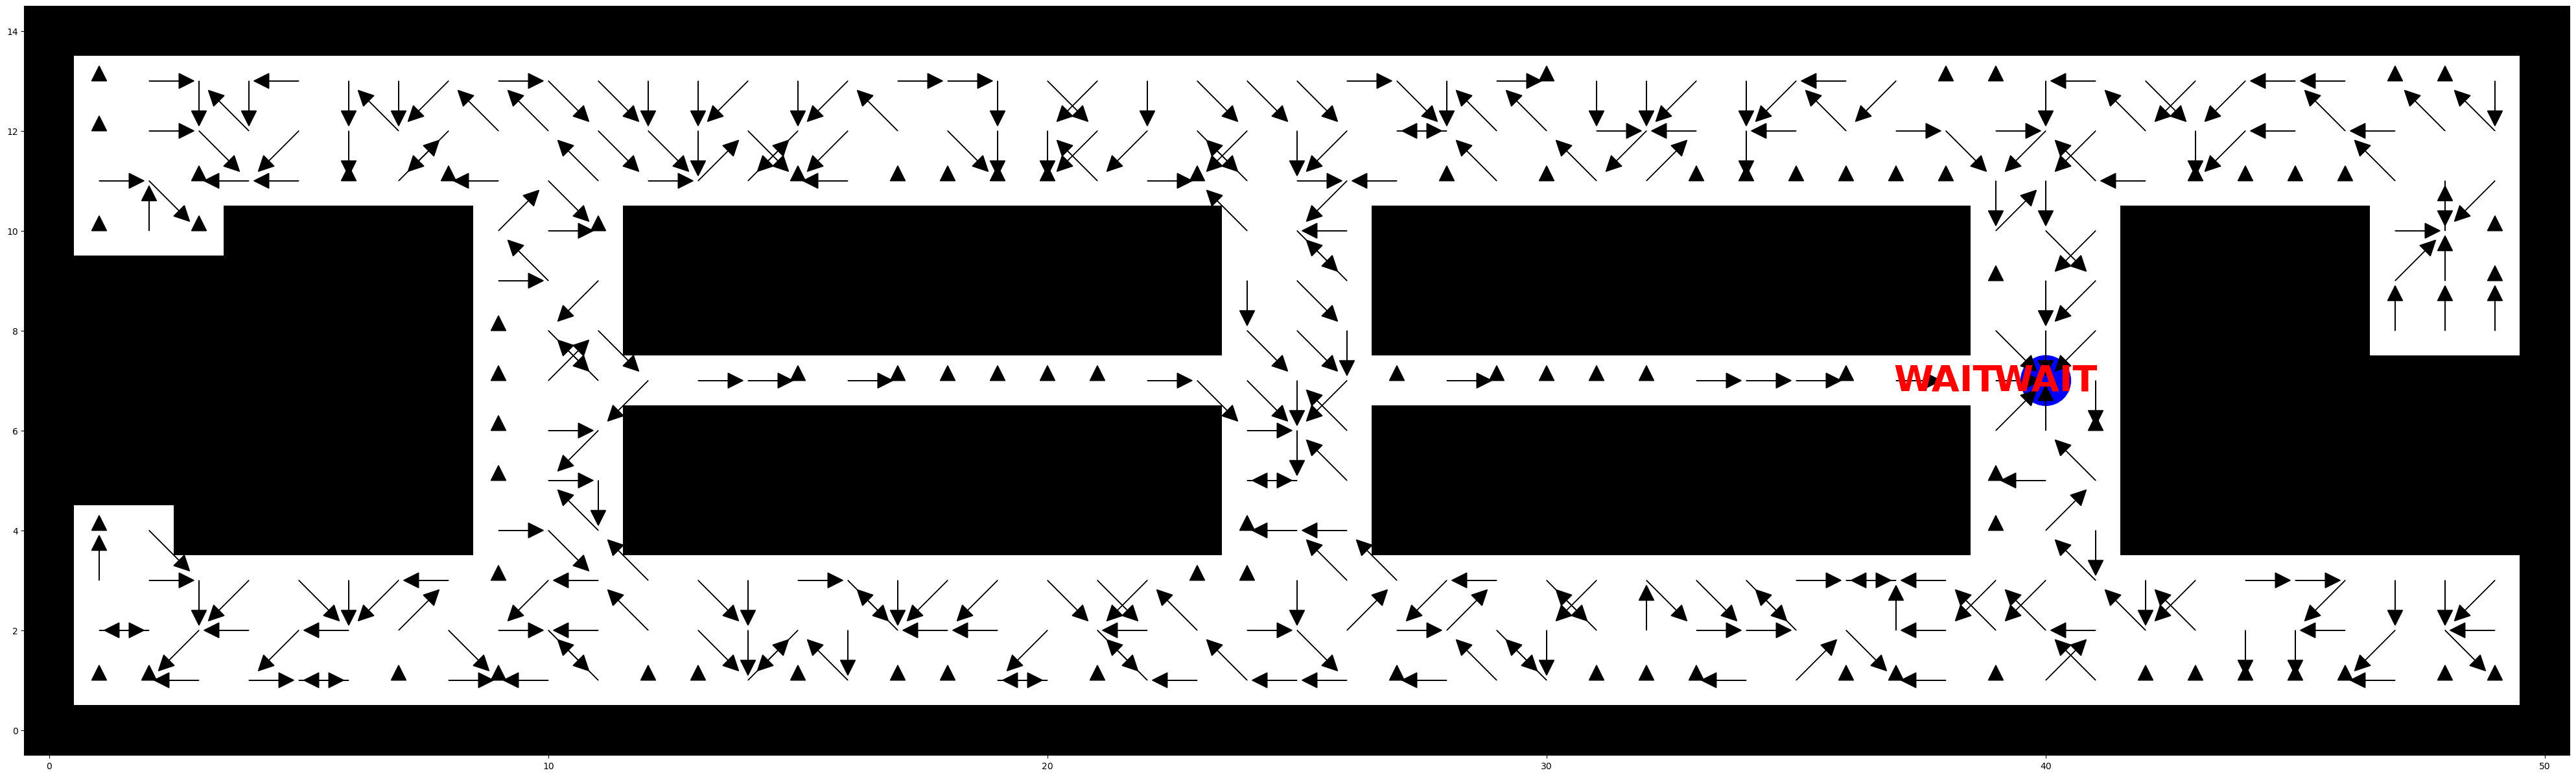

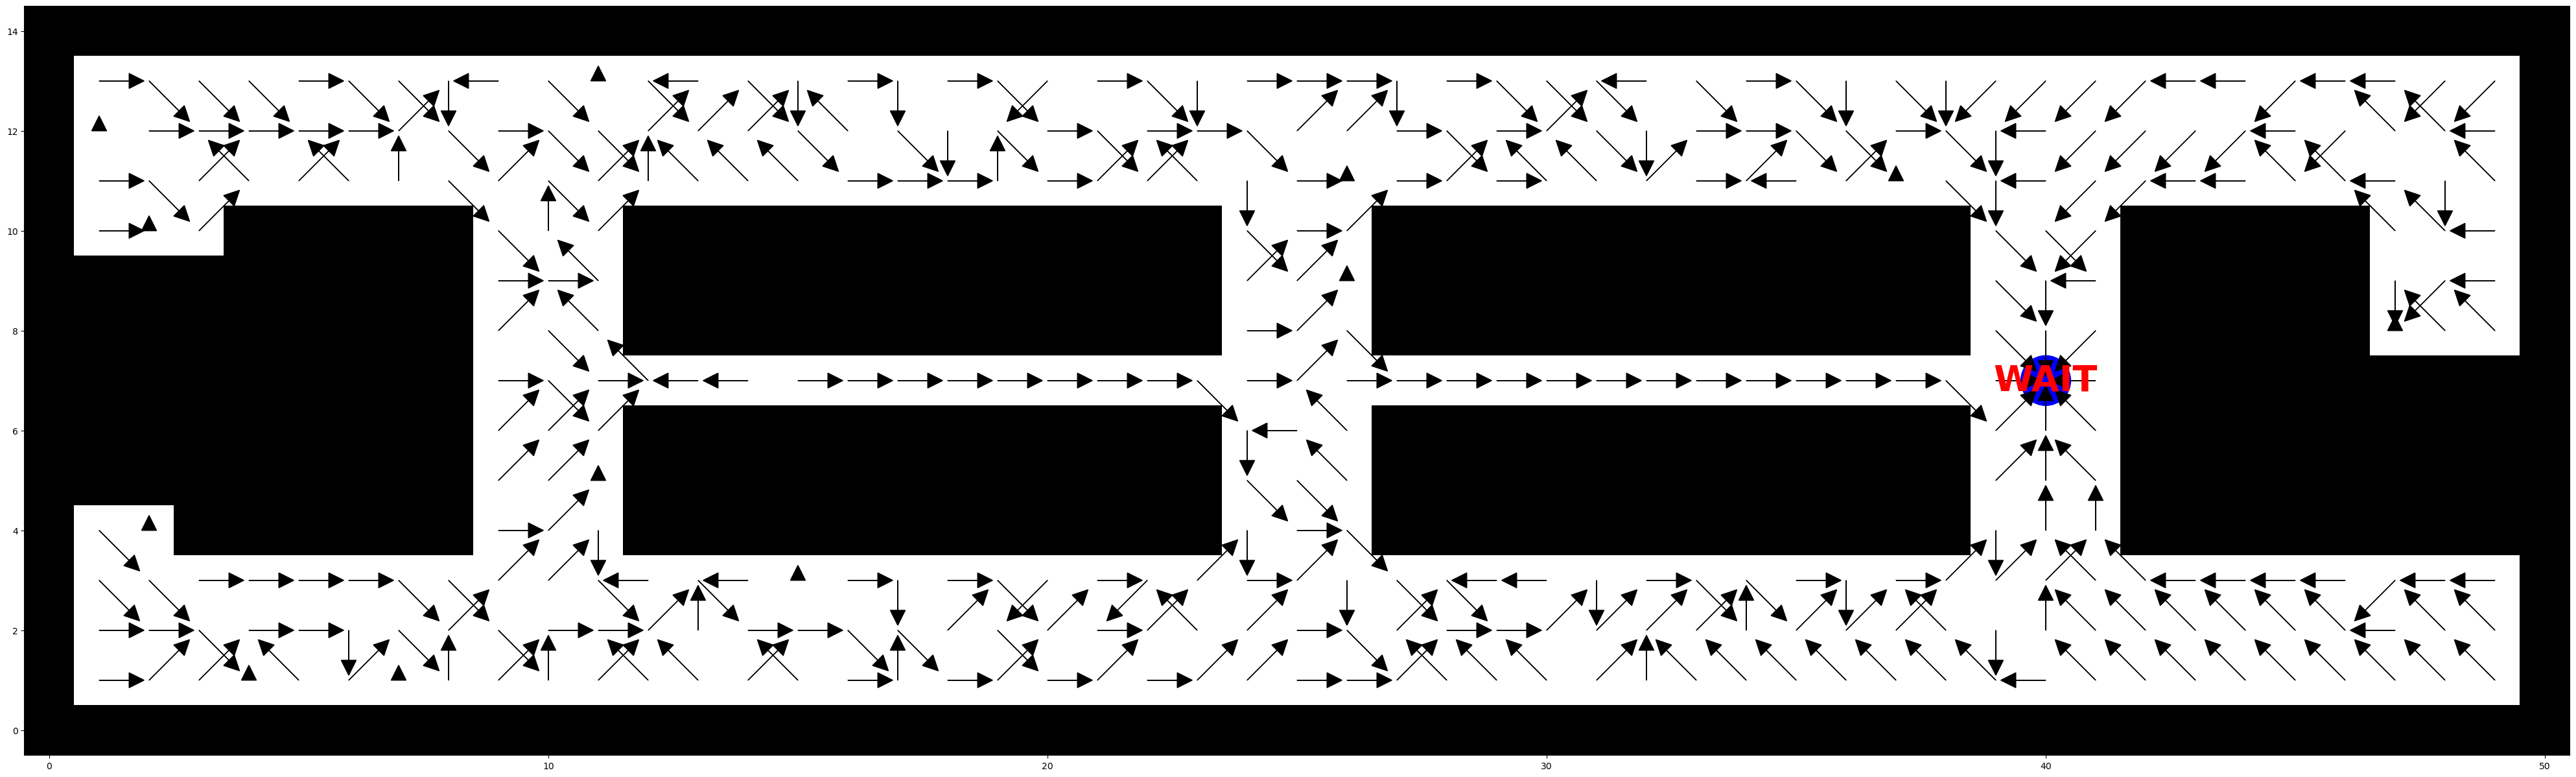

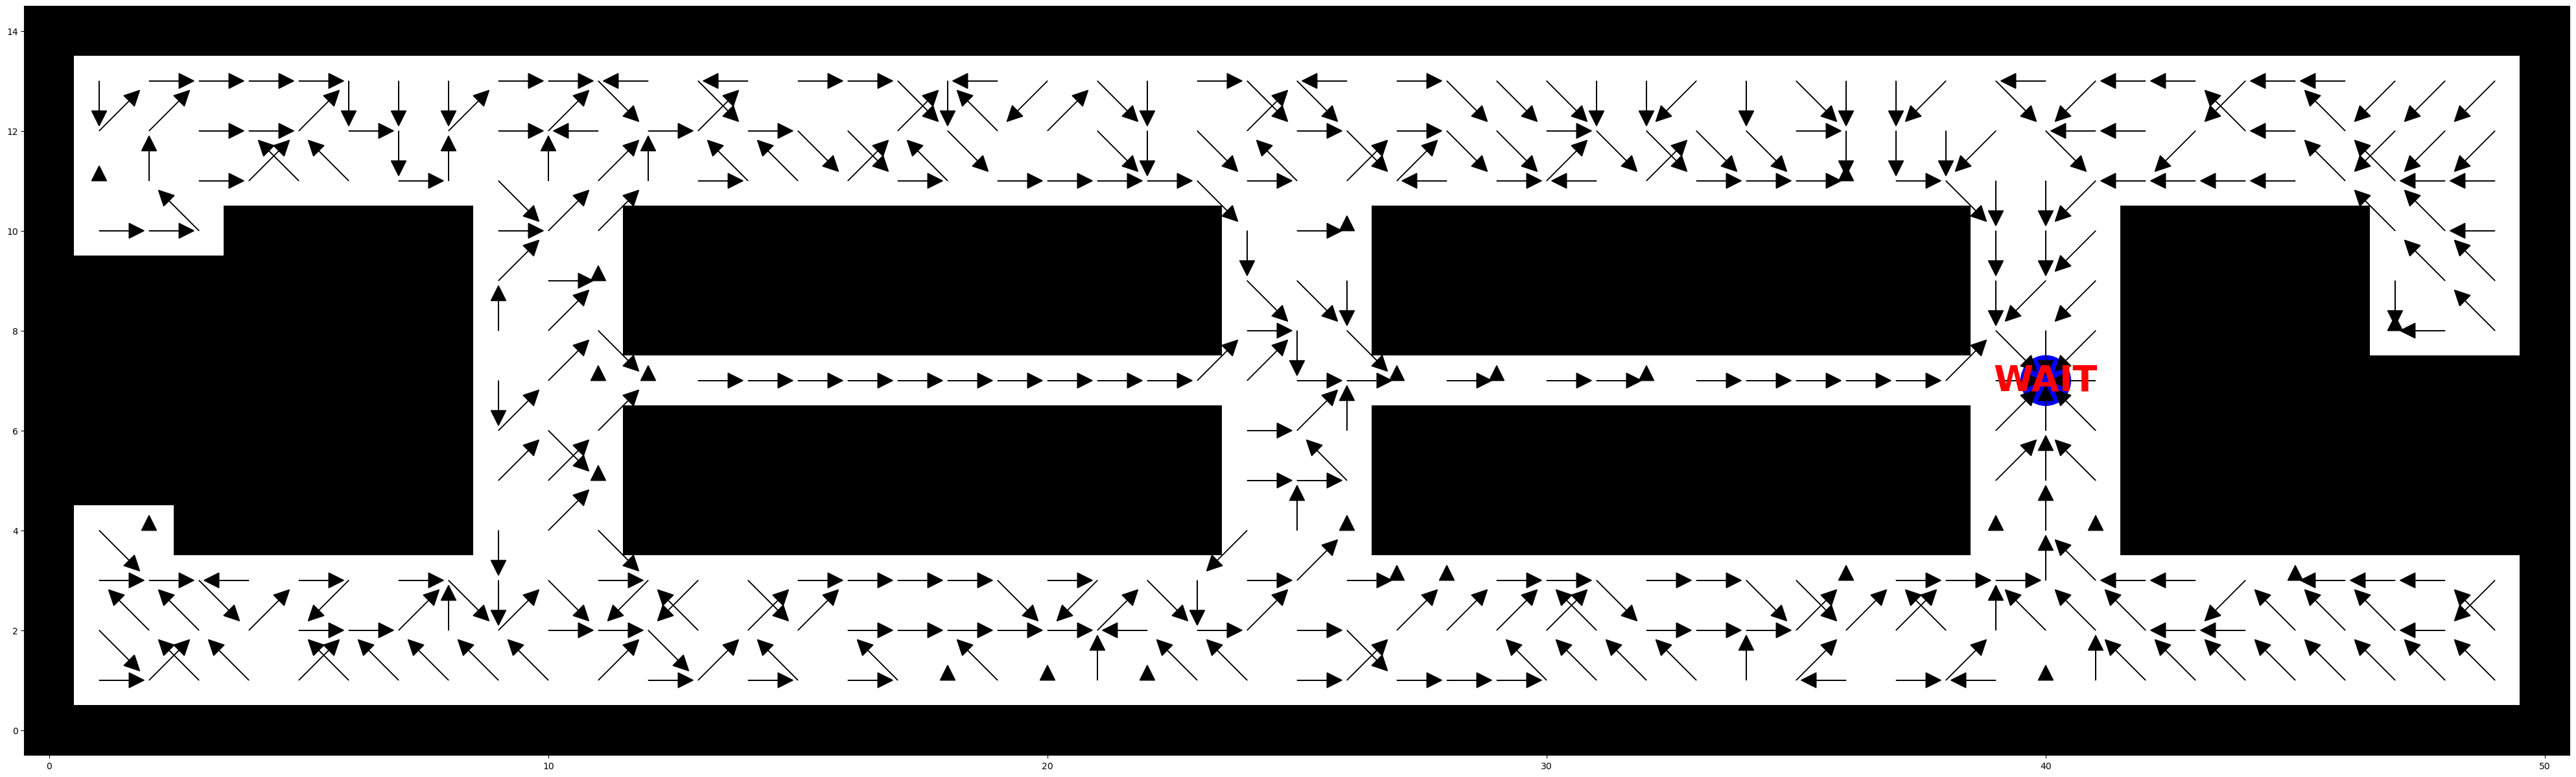

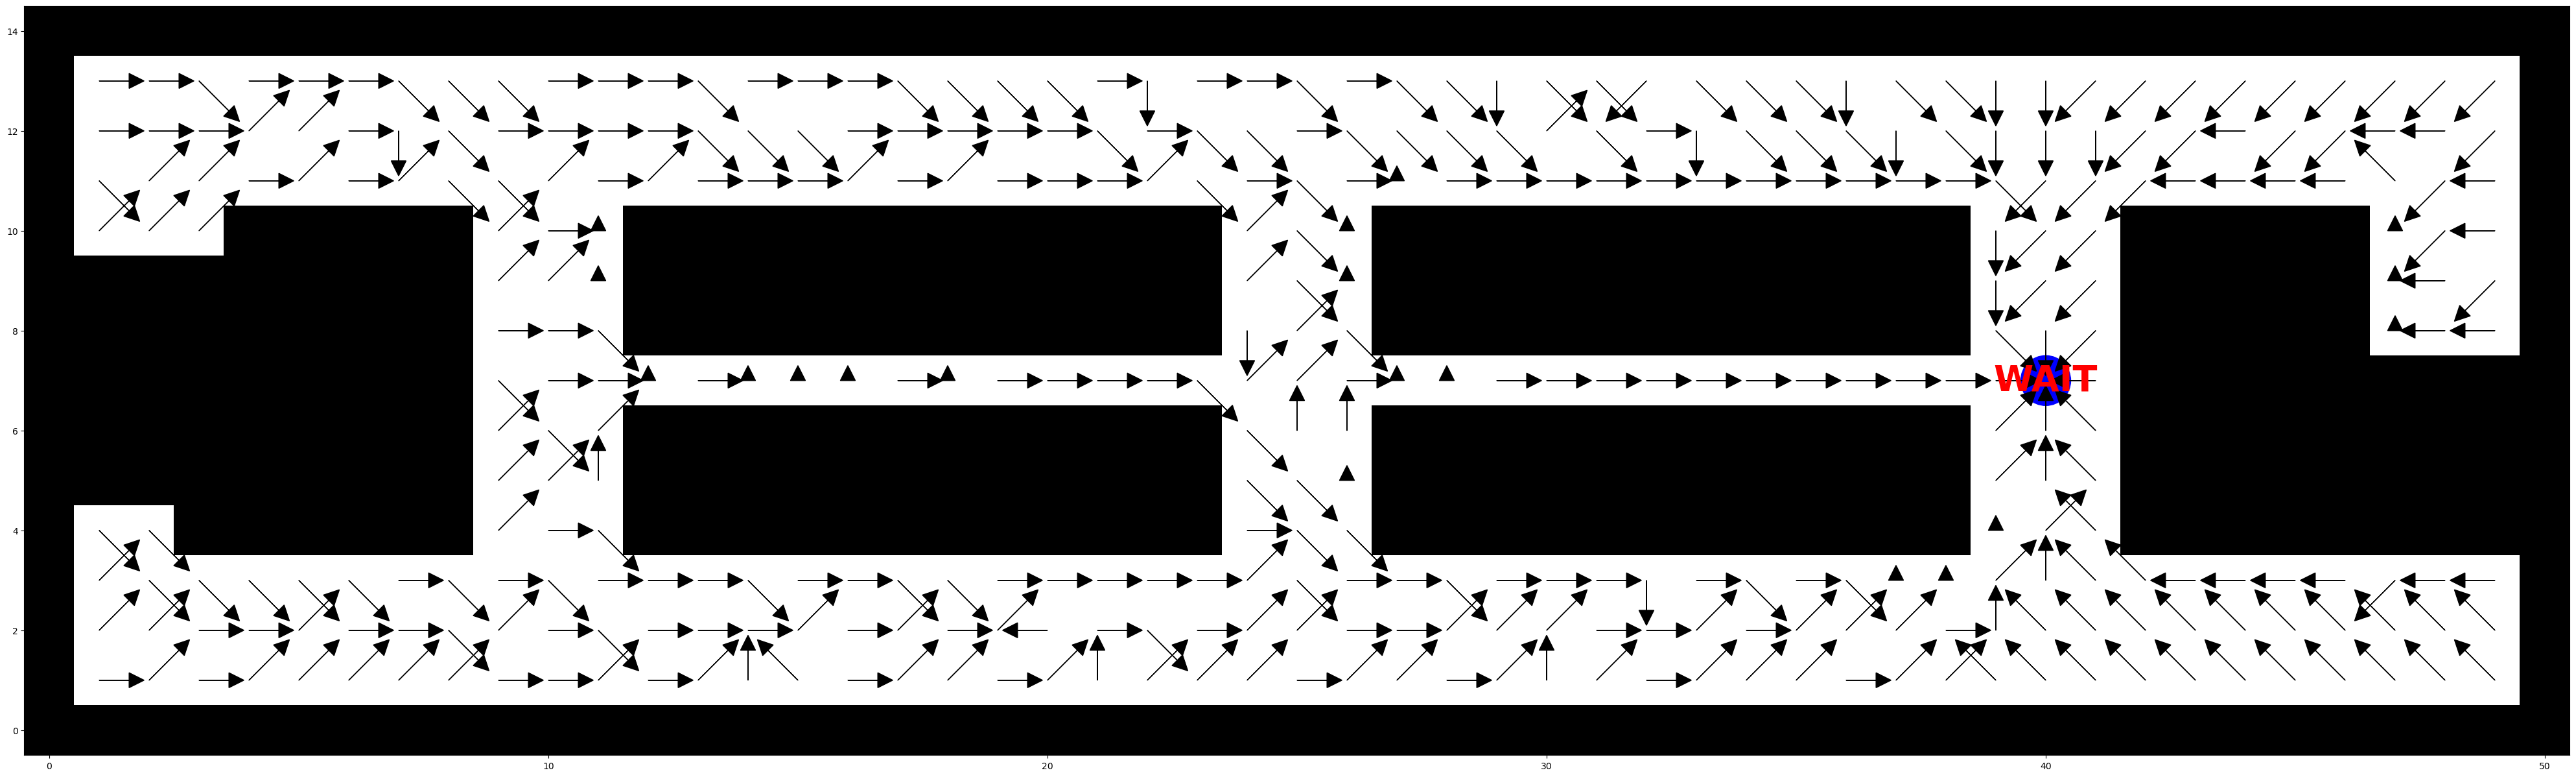

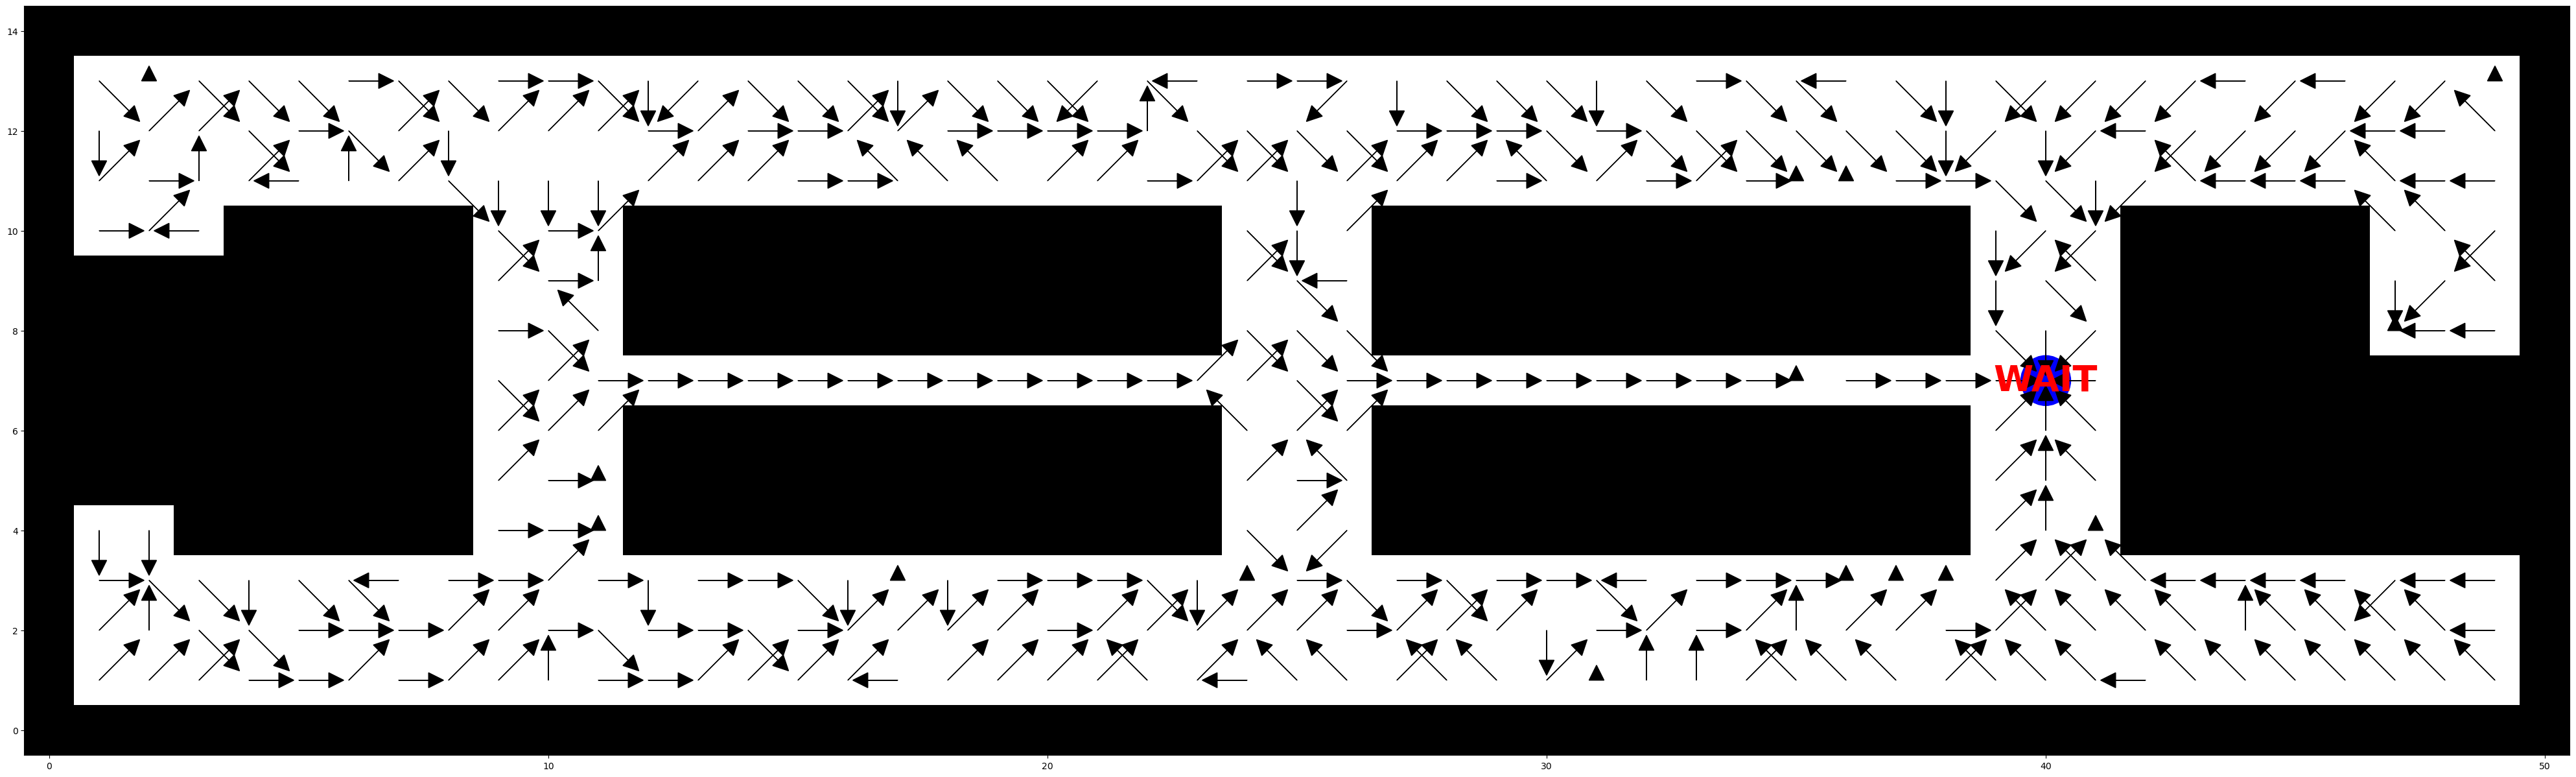

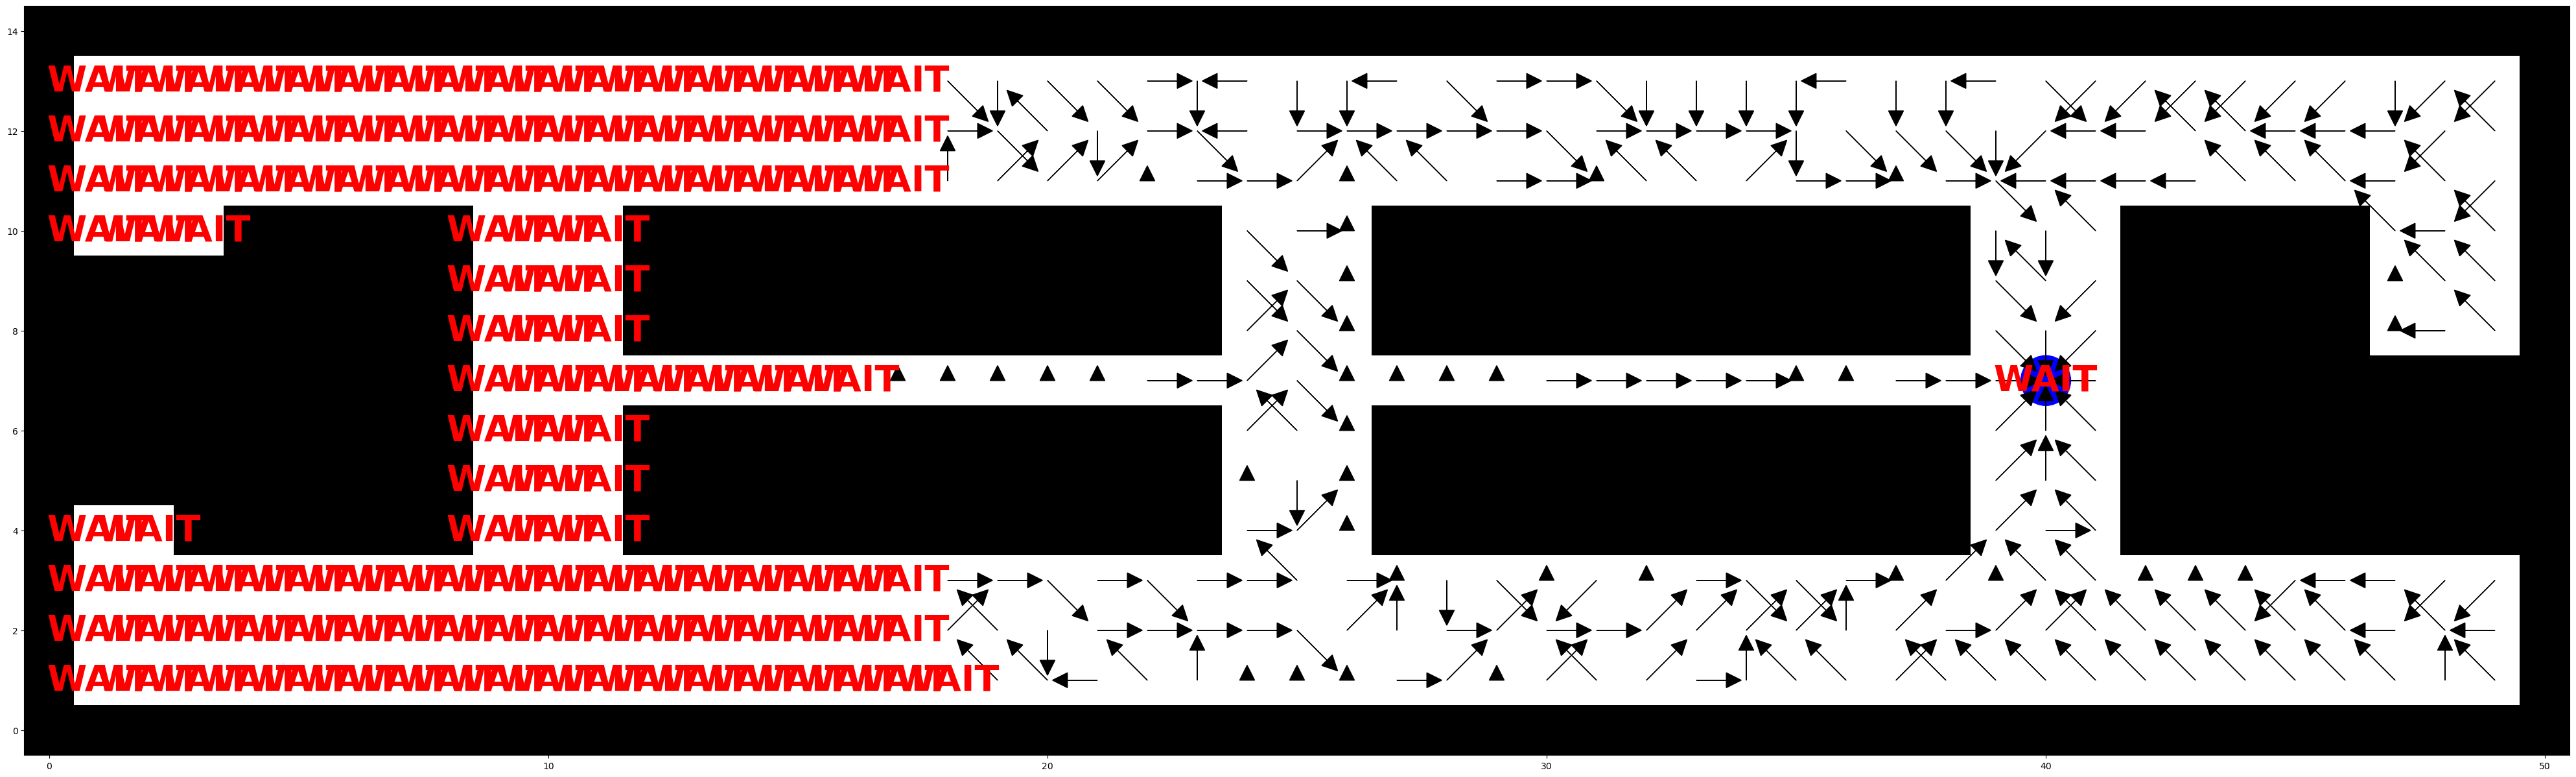

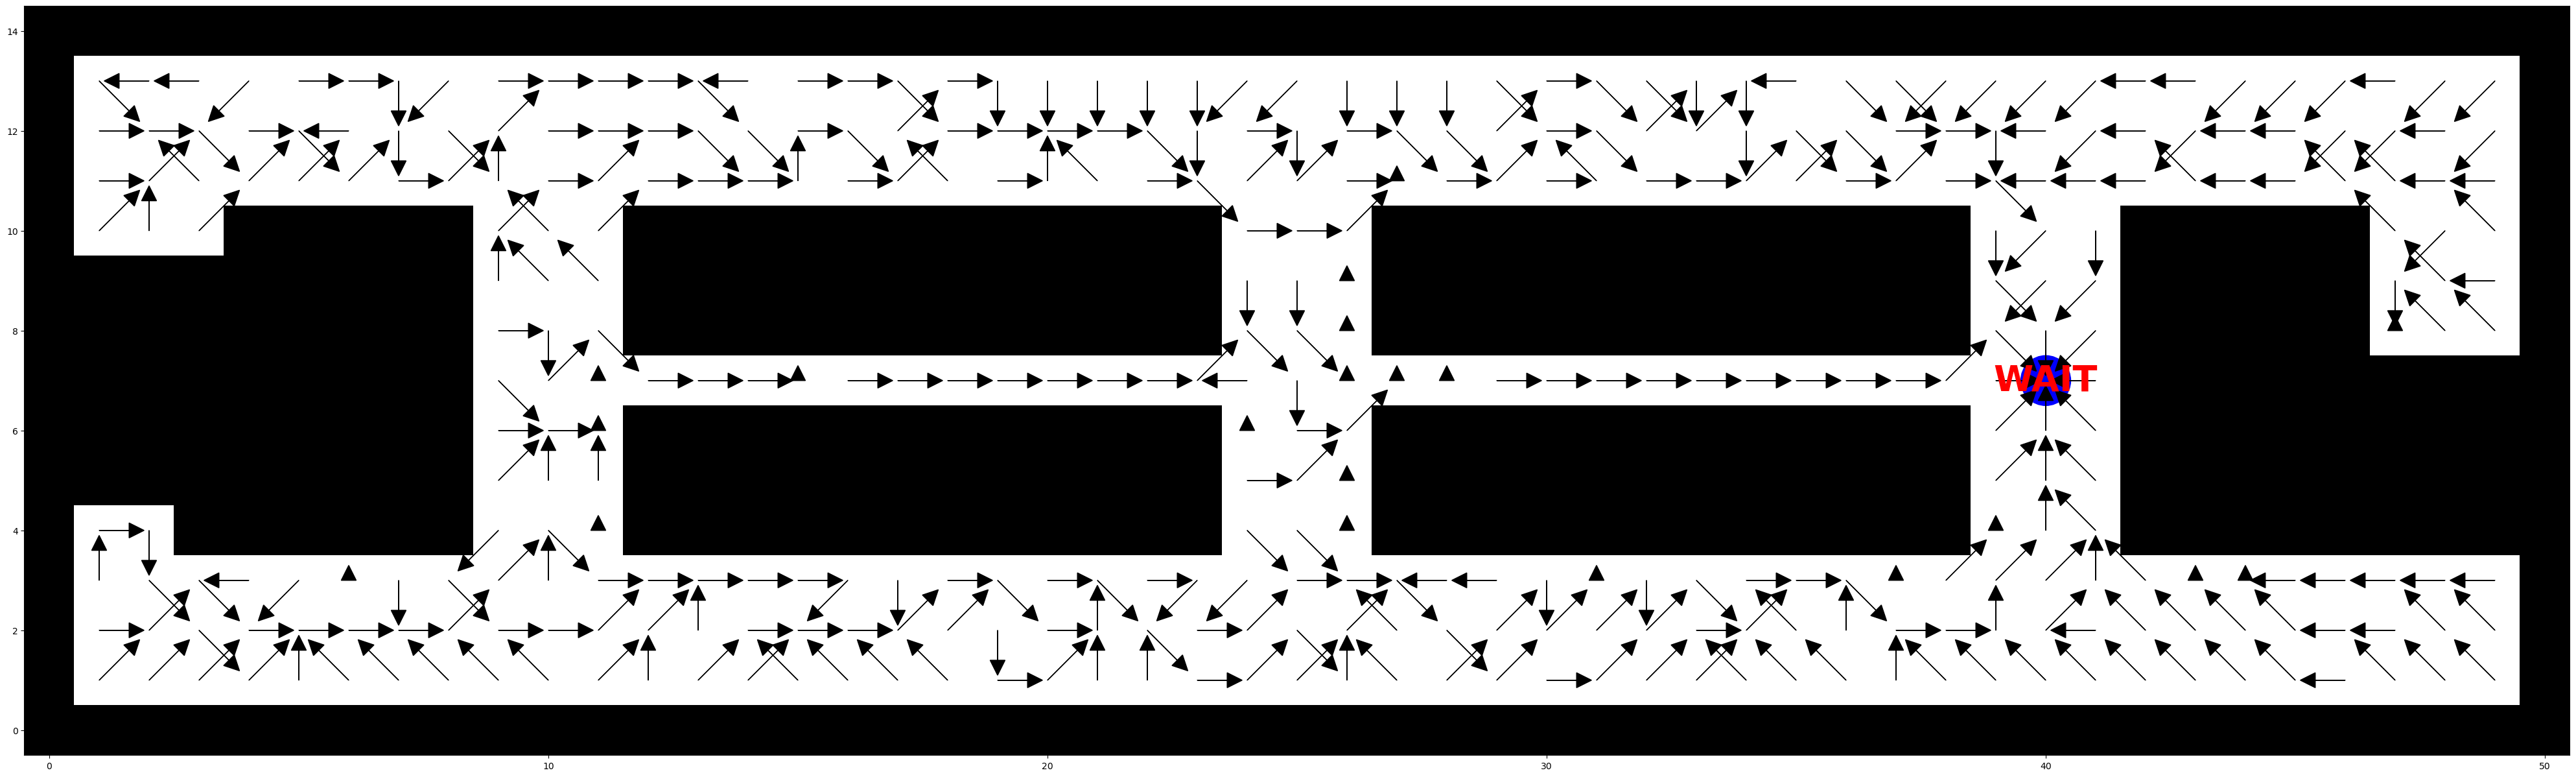

In [301]:
visualiza_politica(politica_mc_episodes_low)
visualiza_politica(politica_mc_episodes_mid)
visualiza_politica(politica_mc_episodes_high)
visualiza_politica(politica_mc_gamma_low)
visualiza_politica(politica_mc_gamma_mid)
visualiza_politica(politica_mc_gamma_high)
visualiza_politica(politica_mc_optima)

#### Monte Carlo A - 100 episodios

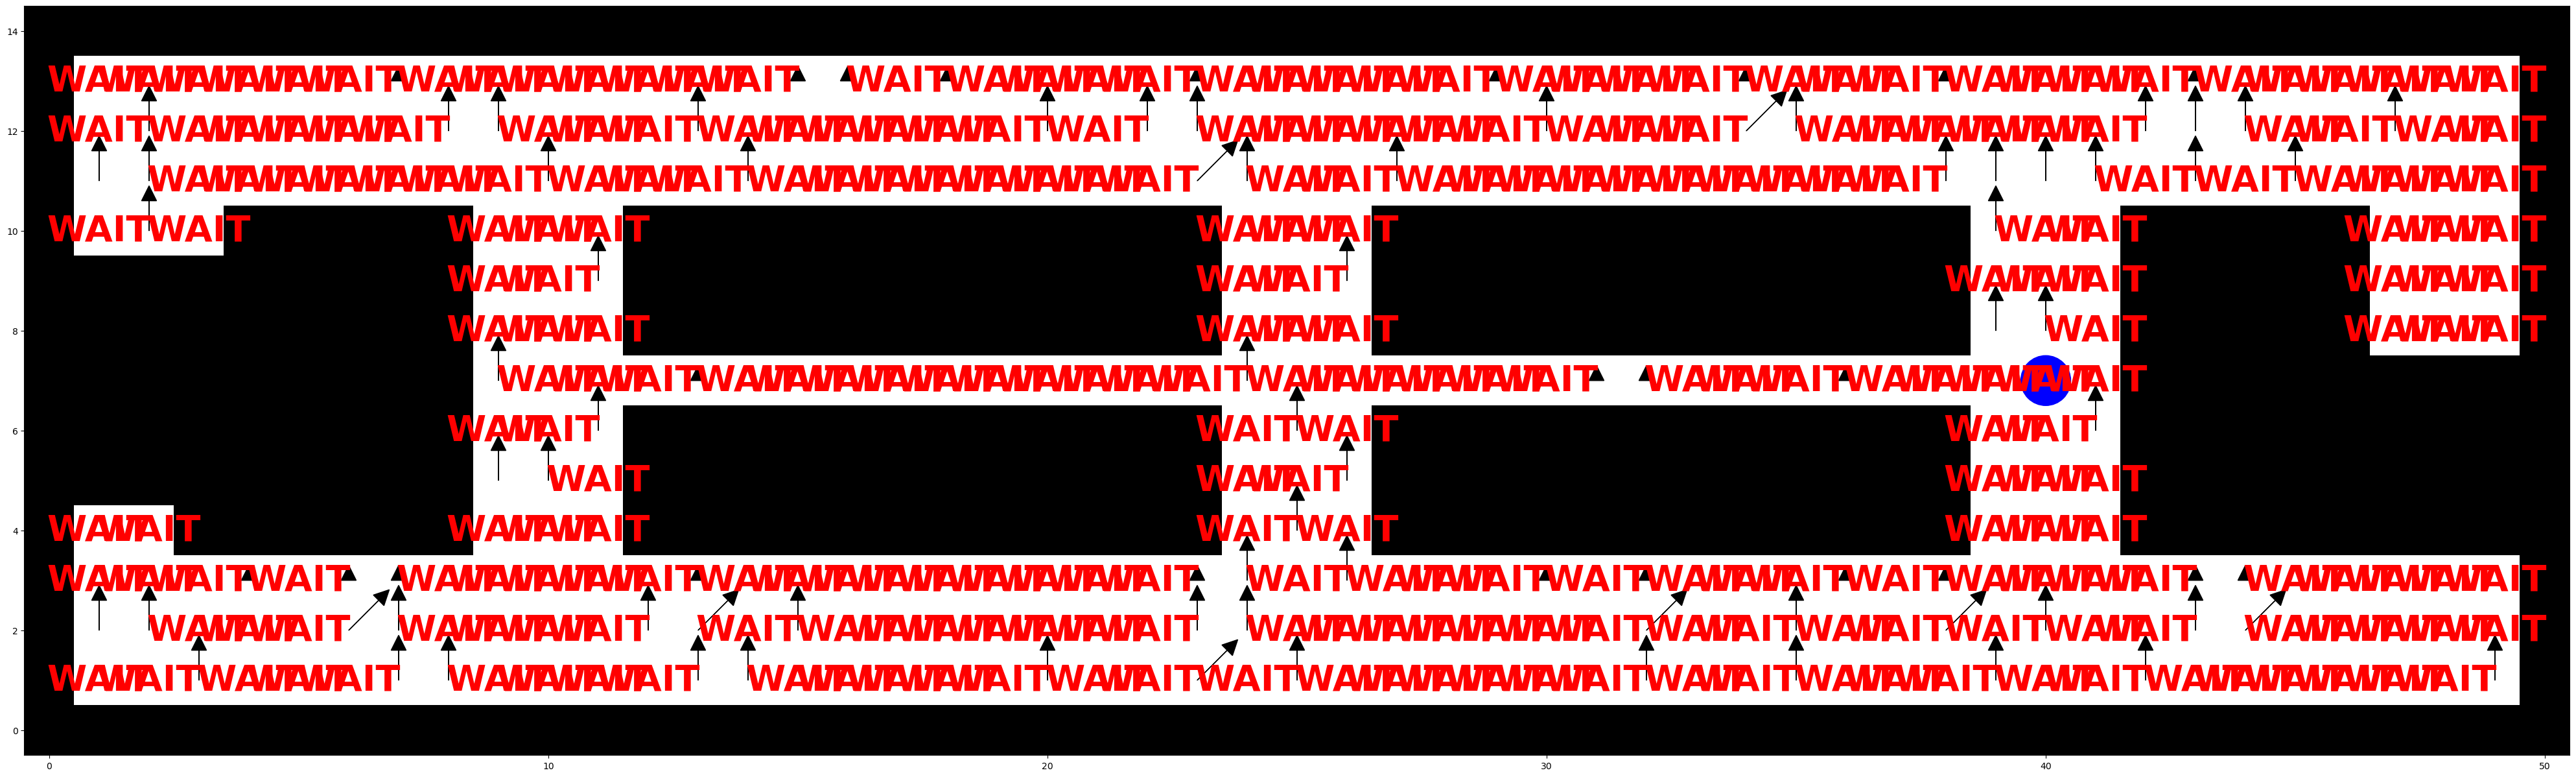

In [279]:
visualiza_politica(politica_mc_episodes_low)

#### Monte Carlo B - 1000 episodios

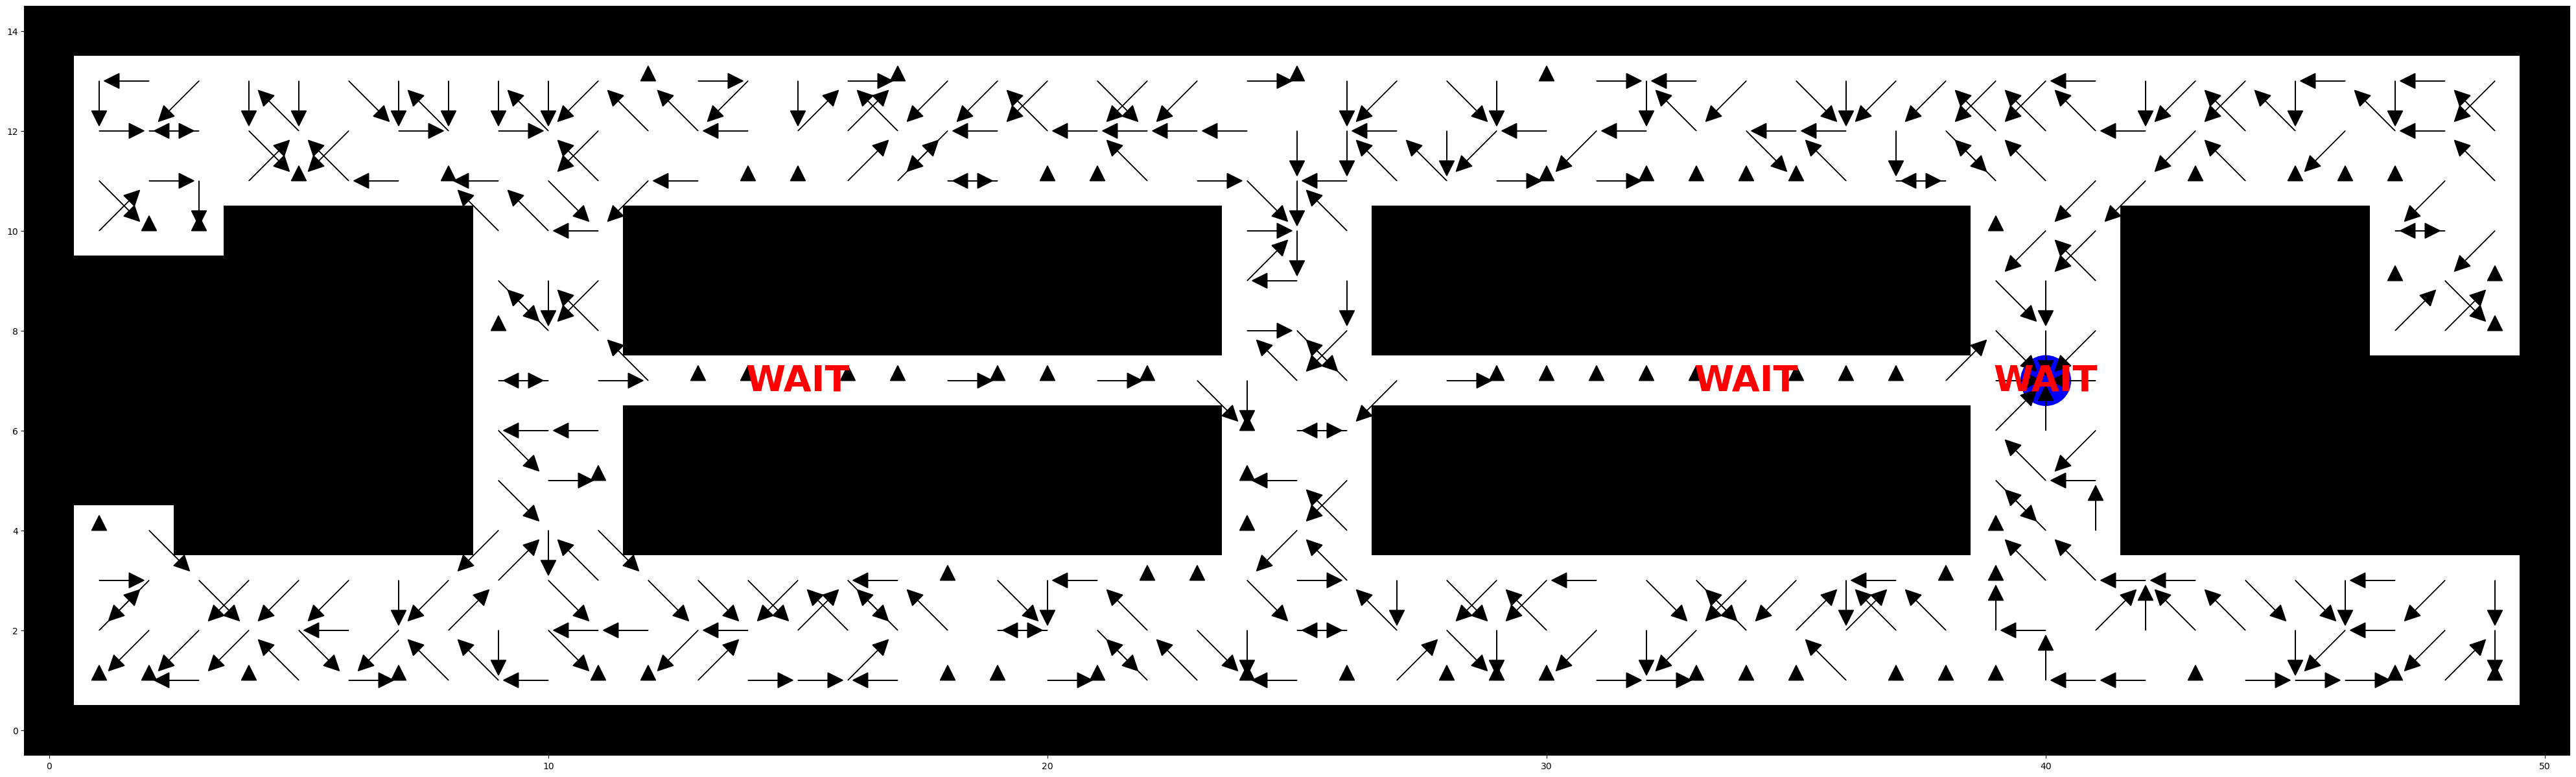

In [280]:
visualiza_politica(politica_mc_b)

#### Monte Carlo C - 5000 episodios

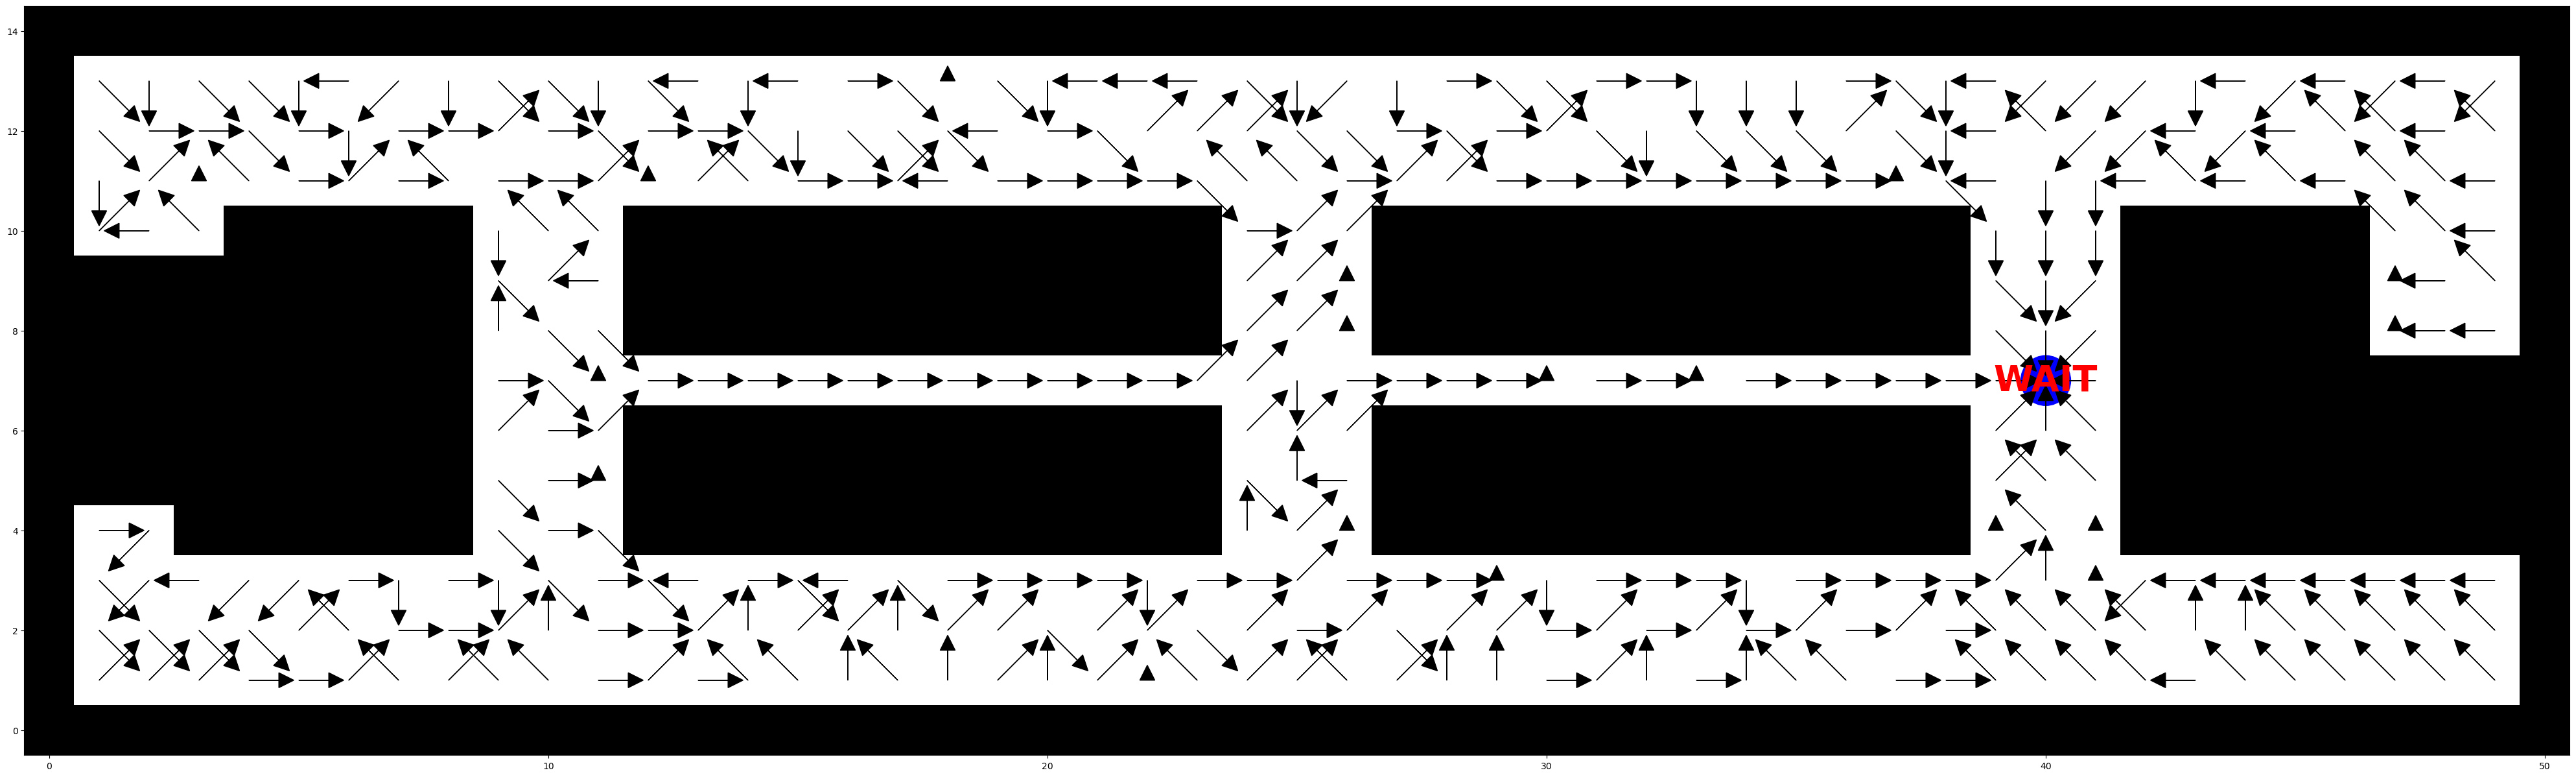

In [281]:
visualiza_politica(politica_mc_c)

#### Monte Carlo D - 10000 episodios

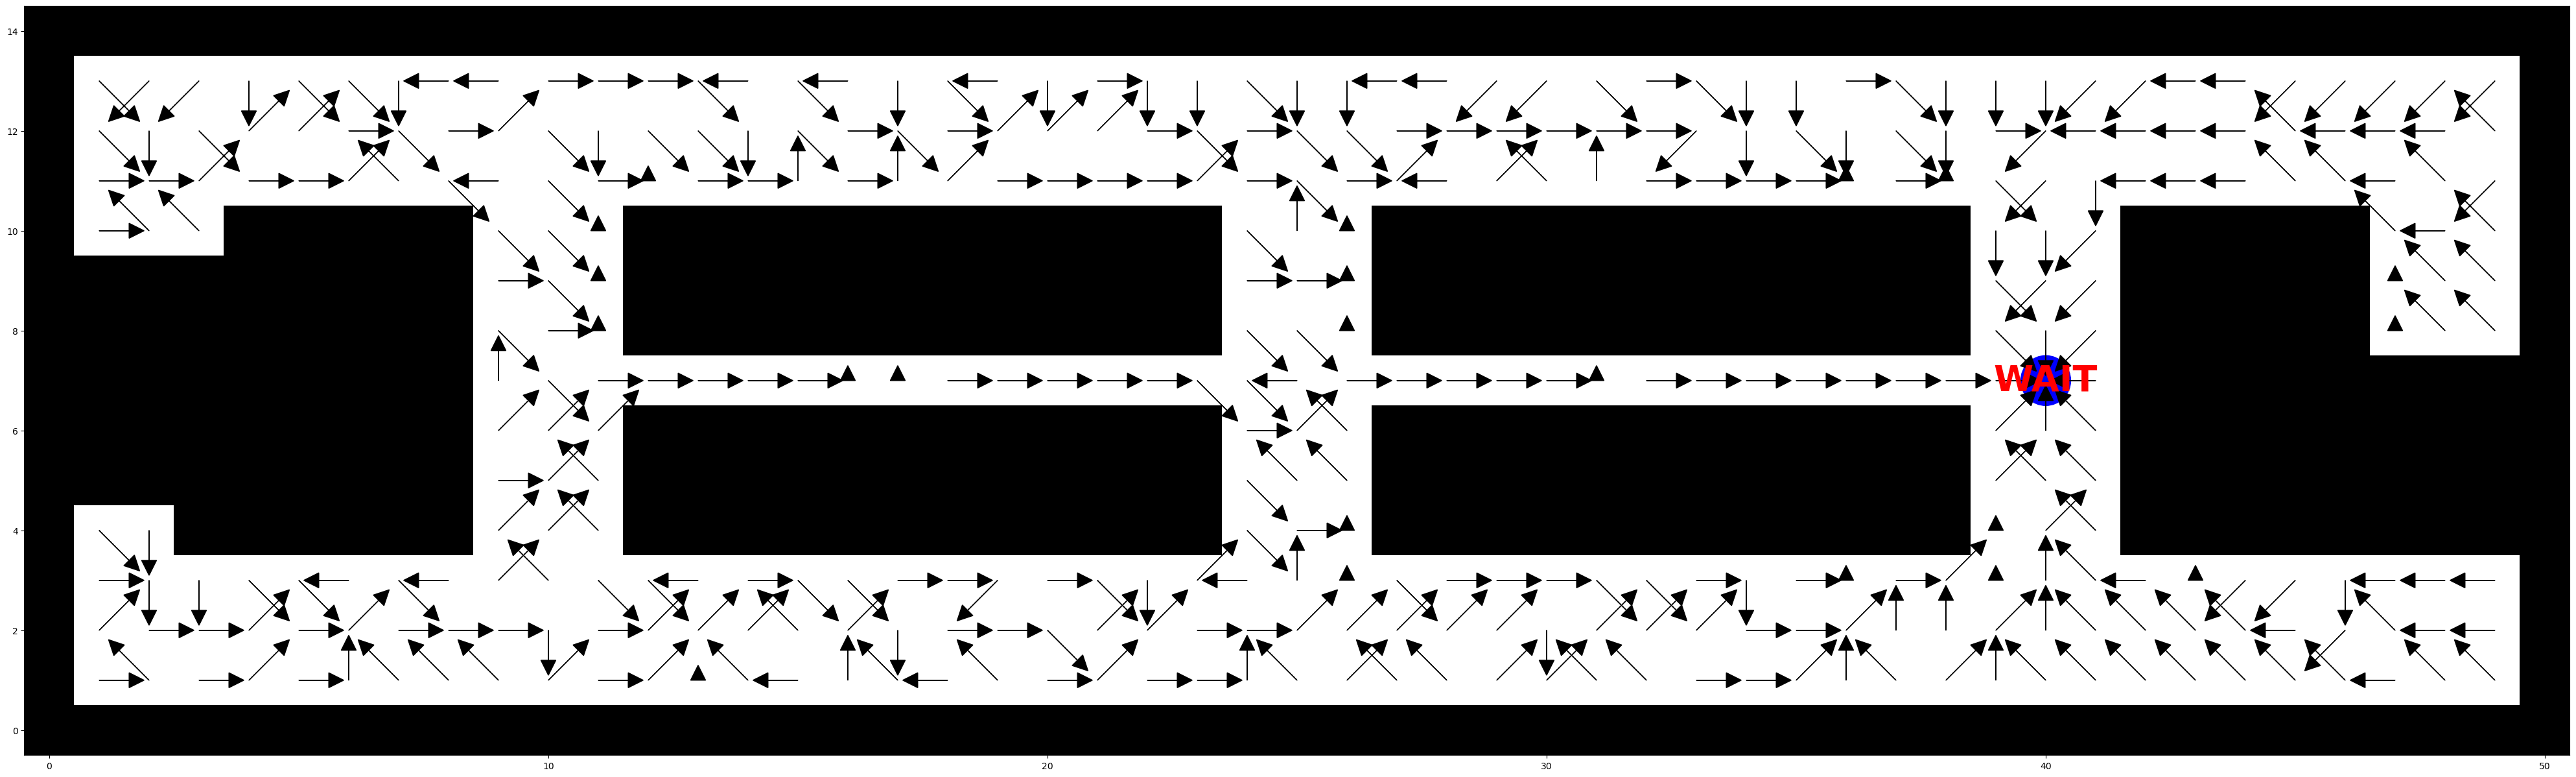

In [282]:
visualiza_politica(politica_mc_d)

### Apartado 3: Implementación mediante SARSA (State-Action-Reward-State-Action)

SARSA es un algoritmo de control para procesos de decisión de Markov que se usa en el aprendizaje por refuerzo. SARSA es un acrónimo que significa Estado-Acción-Recompensa-Siguiente Estado-Siguiente Acción, y se refiere a la actualización que se realiza en la función de valor Q para un par estado-acción dado. El algoritmo actualiza los valores de Q en base a la ecuación de actualización Q-learning, ajustada para tener en cuenta la política actual que se está siguiendo, generalmente una política ε-greedy.

#### Código y Parámetros de Entrada

##### Función `epsilon_greedy_policy`

- **Entradas**:
  - `state`: El estado actual en el que se encuentra el agente.
  - `Q`: Un diccionario que mapea pares de estados y acciones a sus valores Q.
  - `epsilon`: La probabilidad de elegir una acción al azar; esto ayuda a la exploración.

- **Funcionalidad**: Esta función selecciona una acción utilizando la política ε-greedy. Con probabilidad ε, elige una acción al azar para promover la exploración. Con probabilidad 1-ε, elige la acción que maximiza el valor Q para el estado actual, promoviendo la explotación.

##### Función `sarsa`

- **Entradas**:
  - `mapa`: El ambiente o contexto en el que se mueve el agente.
  - `destino`: El estado objetivo que el agente intenta alcanzar.
  - `num_episodes`: Número de episodios de entrenamiento.
  - `max_steps`: Número máximo de pasos por episodio.
  - `alpha`: Tasa de aprendizaje.
  - `gamma`: Factor de descuento, que equilibra la importancia de las recompensas inmediatas vs. futuras.
  - `epsilon`: Probabilidad de selección de acción aleatoria.

- **Funcionalidad**: Implementa el algoritmo SARSA para actualizar los valores Q basados en la secuencia de estados, acciones y recompensas experimentadas. El agente actualiza Q según las recompensas obtenidas y las estimaciones de Q para el siguiente estado y acción, bajo una política ε-greedy.

- **Implicaciones de los Parámetros**:
  - **`num_episodes`**: Aumentar el número de episodios permite al algoritmo explorar más el espacio de estado y acción, mejorando potencialmente la política aprendida. Reducirlo puede acelerar el entrenamiento pero a riesgo de obtener una política subóptima.
  - **`max_steps`**: Un número mayor permite episodios más largos, dando más oportunidades para aprender de una variedad de situaciones. Un número menor puede limitar el aprendizaje a experiencias cortas.
  - **`alpha`** (tasa de aprendizaje): Un valor alto puede hacer que el aprendizaje sea más rápido pero posiblemente inestable o convergente a políticas subóptimas. Un valor bajo asegura un aprendizaje más estable pero más lento.
  - **`gamma`** (factor de descuento): Un valor alto prioriza las recompensas futuras, ideal para tareas donde el "largo plazo" es importante. Un valor bajo hace que el agente valore más las recompensas inmediatas, útil en entornos donde el futuro es muy incierto o el agente necesita resultados rápidos.
  - **`epsilon`** (probabilidad de exploración): Un valor alto incrementa la exploración, útil en las fases iniciales del aprendizaje o en entornos muy dinámicos. Un valor bajo aumenta la explotación de la información aprendida, lo que puede mejorar la eficiencia en entornos estables.

#### Diferencias con Q-learning y Monte Carlo

##### SARSA vs. Q-learning
- **SARSA**: Es un algoritmo on-policy que evalúa y mejora la misma política que está siendo usada para tomar decisiones. Actualiza los valores Q usando la acción que realmente se tomó, la cual es determinada por la política actual.
- **Q-learning**: Es un algoritmo off-policy que evalúa una política que toma las mejores acciones posibles (greedy), independientemente de la acción tomada por la política actual. Actualiza los valores Q usando el máximo valor Q estimado para el próximo estado, independientemente de la acción elegida según la política ε-greedy.

##### SARSA vs. Monte Carlo
- **SARSA**: Actualiza los valores Q después de cada paso, usando estimaciones basadas en la siguiente acción y el siguiente estado.
- **Monte Carlo**: Espera hasta el final del episodio y luego actualiza los valores basándose en la secuencia completa de estados y recompensas del episodio. No se basa en una aproximación del siguiente valor Q, sino que utiliza la recompensa real acumulada.

In [283]:
def epsilon_greedy_policy(state, Q, epsilon):
    """ Selección de acciones usando la política epsilon-greedy. """
    if np.random.uniform() < epsilon:
        return np.random.choice(nav_acciones)
    else:
        return max(Q[state], key=Q[state].get)

def sarsa(mapa, destino, num_episodes, max_steps=100, alpha=0.1, gamma=0.95, epsilon=0.1):
    Q = {estado: {accion: 0 for accion in nav_acciones} for estado in nav_estados}
    for episode in range(num_episodes):
        estado = inicializa_posicion(mapa, destino)
        accion = epsilon_greedy_policy(estado, Q, epsilon)
        
        for _ in range(max_steps):
            nuevo_estado = aplica_accion(estado, accion)
            recompensa = obtiene_recompensa(estado, accion)
            nueva_accion = epsilon_greedy_policy(nuevo_estado, Q, epsilon)
            
            # Actualización SARSA
            Q[estado][accion] += alpha * (recompensa + gamma * Q[nuevo_estado][nueva_accion] - Q[estado][accion])
            
            estado, accion = nuevo_estado, nueva_accion
            
            if nuevo_estado == destino or accion == 'wait':
                break
    
    politica_optima = [max(Q[estado], key=Q[estado].get) for estado in nav_estados]

    return politica_optima



#### Plan de Experimentación con SARSA

El objetivo de este plan es verificar cómo diferentes configuraciones de parámetros afectan el comportamiento y el aprendizaje del algoritmo SARSA en un entorno de prueba. Los resultados ayudarán a comprender mejor cómo ajustar estos parámetros en aplicaciones prácticas.

#### Configuraciones de los Experimentos

Cada configuración de experimento variará uno o más parámetros mientras mantiene los otros constantes para aislar los efectos de cada uno. Los parámetros a variar son: `num_episodes`, `max_steps`, `alpha`, `gamma`, y `epsilon`.

##### Variación de `num_episodes`
- **Objetivo**: Evaluar el impacto del número de episodios en la calidad del aprendizaje.
- **Configuraciones**:
  - Bajo: 100 episodios
  - Medio: 500 episodios
  - Alto: 1000 episodios

##### Variación de `max_steps`
- **Objetivo**: Determinar cómo el número máximo de pasos por episodio afecta la capacidad del agente para aprender de experiencias más prolongadas.
- **Configuraciones**:
  - Corto: 50 pasos
  - Medio: 100 pasos
  - Largo: 200 pasos

##### Variación de `alpha` (tasa de aprendizaje)
- **Objetivo**: Investigar cómo diferentes tasas de aprendizaje influyen en la convergencia del algoritmo.
- **Configuraciones**:
  - Baja: 0.05
  - Media: 0.1
  - Alta: 0.2

##### Variación de `gamma` (factor de descuento)
- **Objetivo**: Comprender cómo el factor de descuento afecta la valoración de recompensas futuras.
- **Configuraciones**:
  - Bajo: 0.5
  - Medio: 0.8
  - Alto: 0.95

##### Variación de `epsilon` (probabilidad de exploración)
- **Objetivo**: Examinar el efecto de diferentes niveles de exploración en la eficiencia y efectividad del aprendizaje.
- **Configuraciones**:
  - Bajo: 0.05
  - Medio: 0.1
  - Alto: 0.2

#### Metodología de Experimentación

Para cada configuración, se realizarán pruebas en un entorno controlado donde el mapa y el destino son consistentes a través de todos los experimentos. Se medirá la efectividad del aprendizaje por la calidad de la política aprendida.


In [296]:
#Instanciaciones para experimentación con el algoritmo SARSA
#Experimentos con num_episodes
politica_sarsa_episodes_low = sarsa(mapa, destino, 100, alpha=0.1, gamma=0.95, epsilon=0.1)
politica_sarsa_episodes_mid = sarsa(mapa, destino, 50000, alpha=0.1, gamma=0.95, epsilon=0.1)
politica_sarsa_episodes_high = sarsa(mapa, destino, 100000, alpha=0.1, gamma=0.95, epsilon=0.1)

#Experimentos con max_steps
politica_sarsa_steps_low = sarsa(mapa, destino, 50000, max_steps=50, alpha=0.1, gamma=0.95, epsilon=0.1)
politica_sarsa_steps_mid = sarsa(mapa, destino, 50000, max_steps=100, alpha=0.1, gamma=0.95, epsilon=0.1)
politica_sarsa_steps_high = sarsa(mapa, destino, 50000, max_steps=200, alpha=0.1, gamma=0.95, epsilon=0.1)

#Experimentos con alpha (tasa de aprendizaje)
politica_sarsa_alpha_low = sarsa(mapa, destino, 50000, alpha=0.05, gamma=0.95, epsilon=0.1)
politica_sarsa_alpha_mid = sarsa(mapa, destino, 500, alpha=0.1, gamma=0.95, epsilon=0.1)
politica_sarsa_alpha_high = sarsa(mapa, destino, 50000, alpha=0.2, gamma=0.95, epsilon=0.1)

#Experimentos con gamma (factor de descuento)
politica_sarsa_gamma_low = sarsa(mapa, destino, 50000, alpha=0.1, gamma=0.5, epsilon=0.1)
politica_sarsa_gamma_mid = sarsa(mapa, destino, 50000, alpha=0.1, gamma=0.8, epsilon=0.1)
politica_sarsa_gamma_high = sarsa(mapa, destino, 50000, alpha=0.1, gamma=0.95, epsilon=0.1)

#Experimentos con epsilon (probabilidad de exploración)
politica_sarsa_epsilon_low = sarsa(mapa, destino, 50000, alpha=0.1, gamma=0.95, epsilon=0.05)
politica_sarsa_epsilon_mid = sarsa(mapa, destino, 50000, alpha=0.1, gamma=0.95, epsilon=0.1)
politica_sarsa_epsilon_high = sarsa(mapa, destino, 50000, alpha=0.1, gamma=0.95, epsilon=0.2)

#Experimento con los hiperparámetros óptimos
politica_sarsa_optima = sarsa(mapa, destino, 100000, alpha=0.1, gamma=0.95, epsilon=0.1)

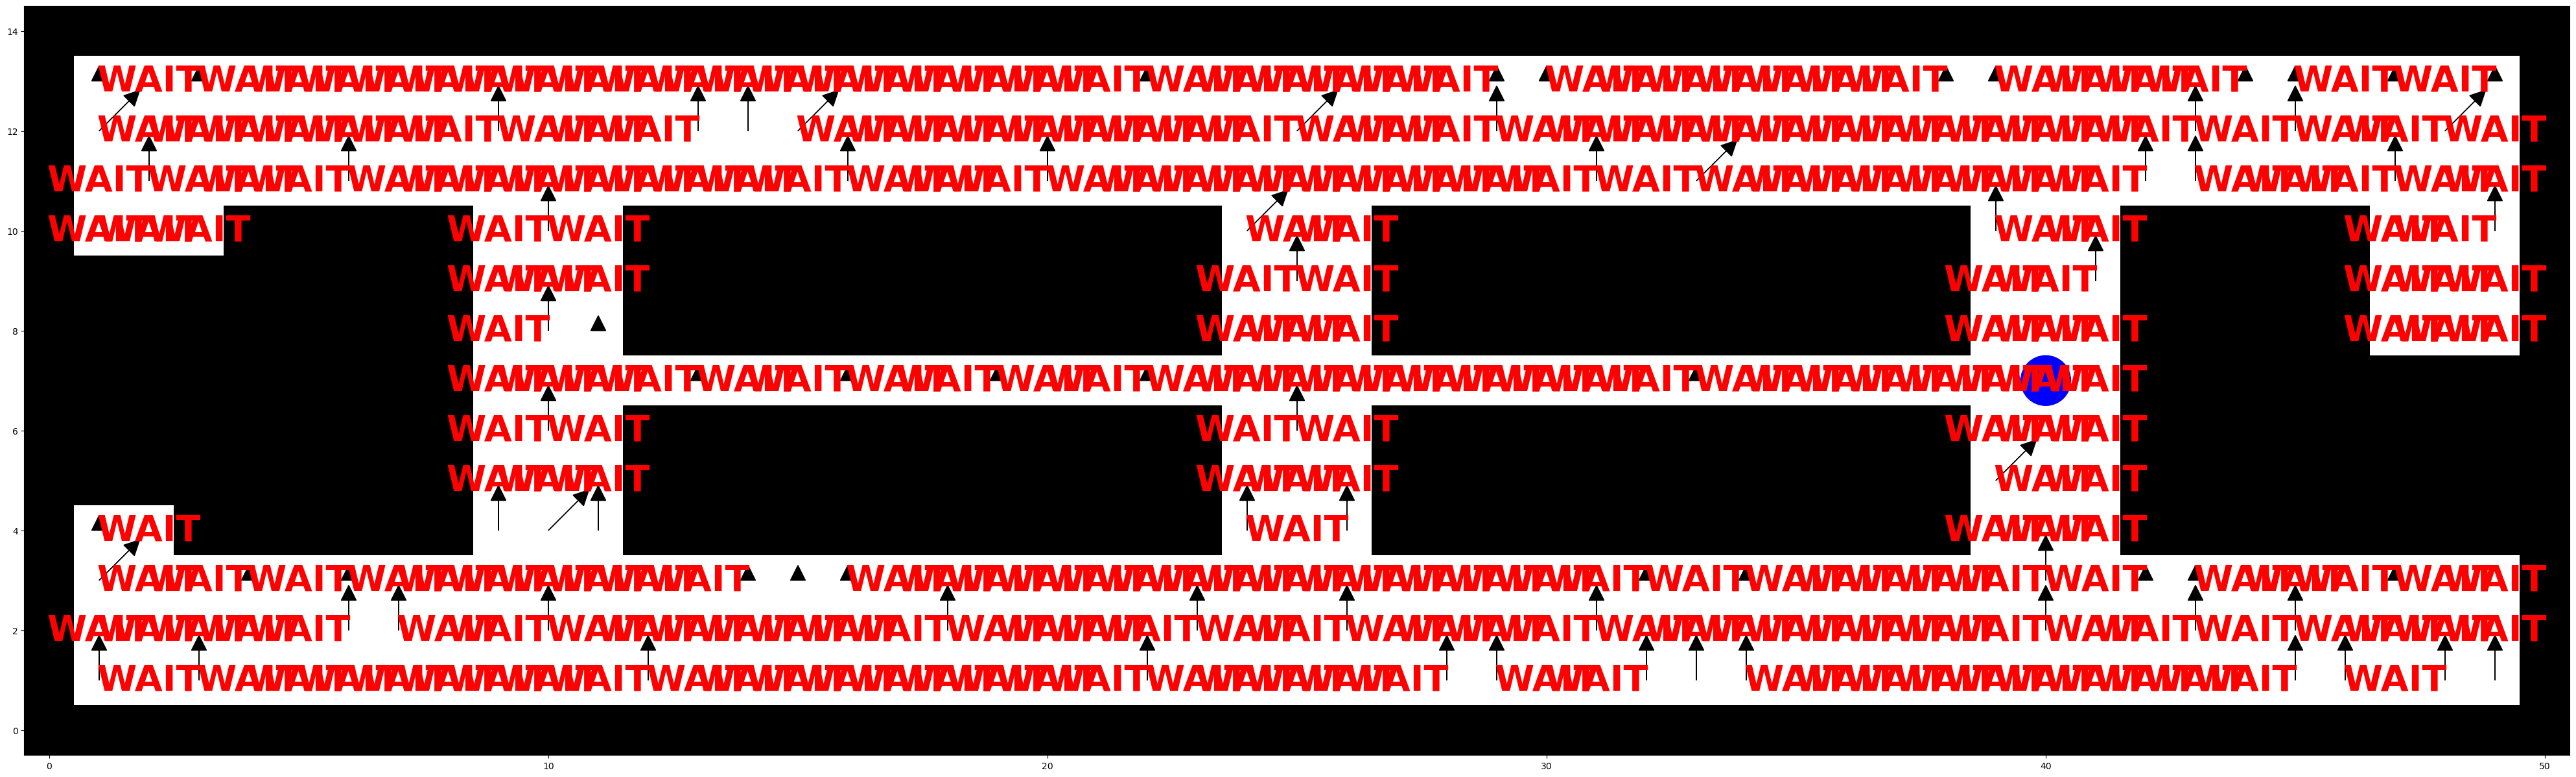

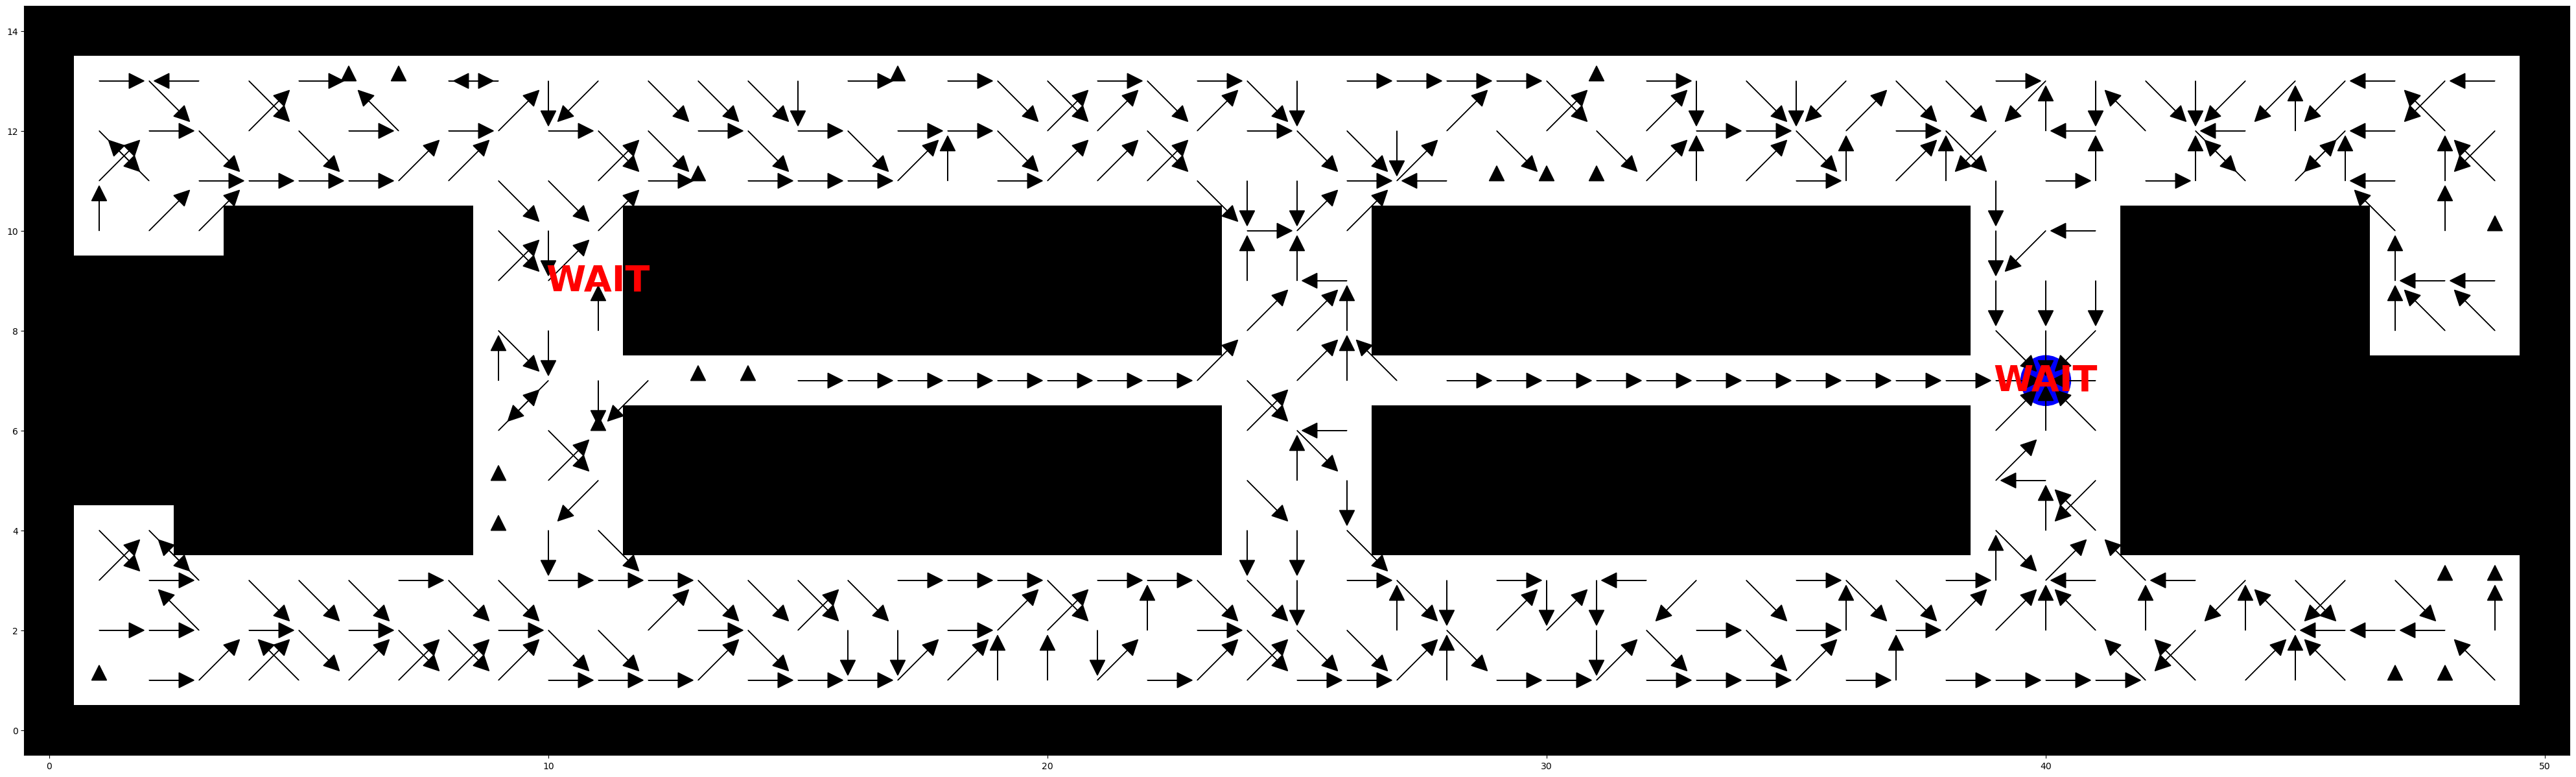

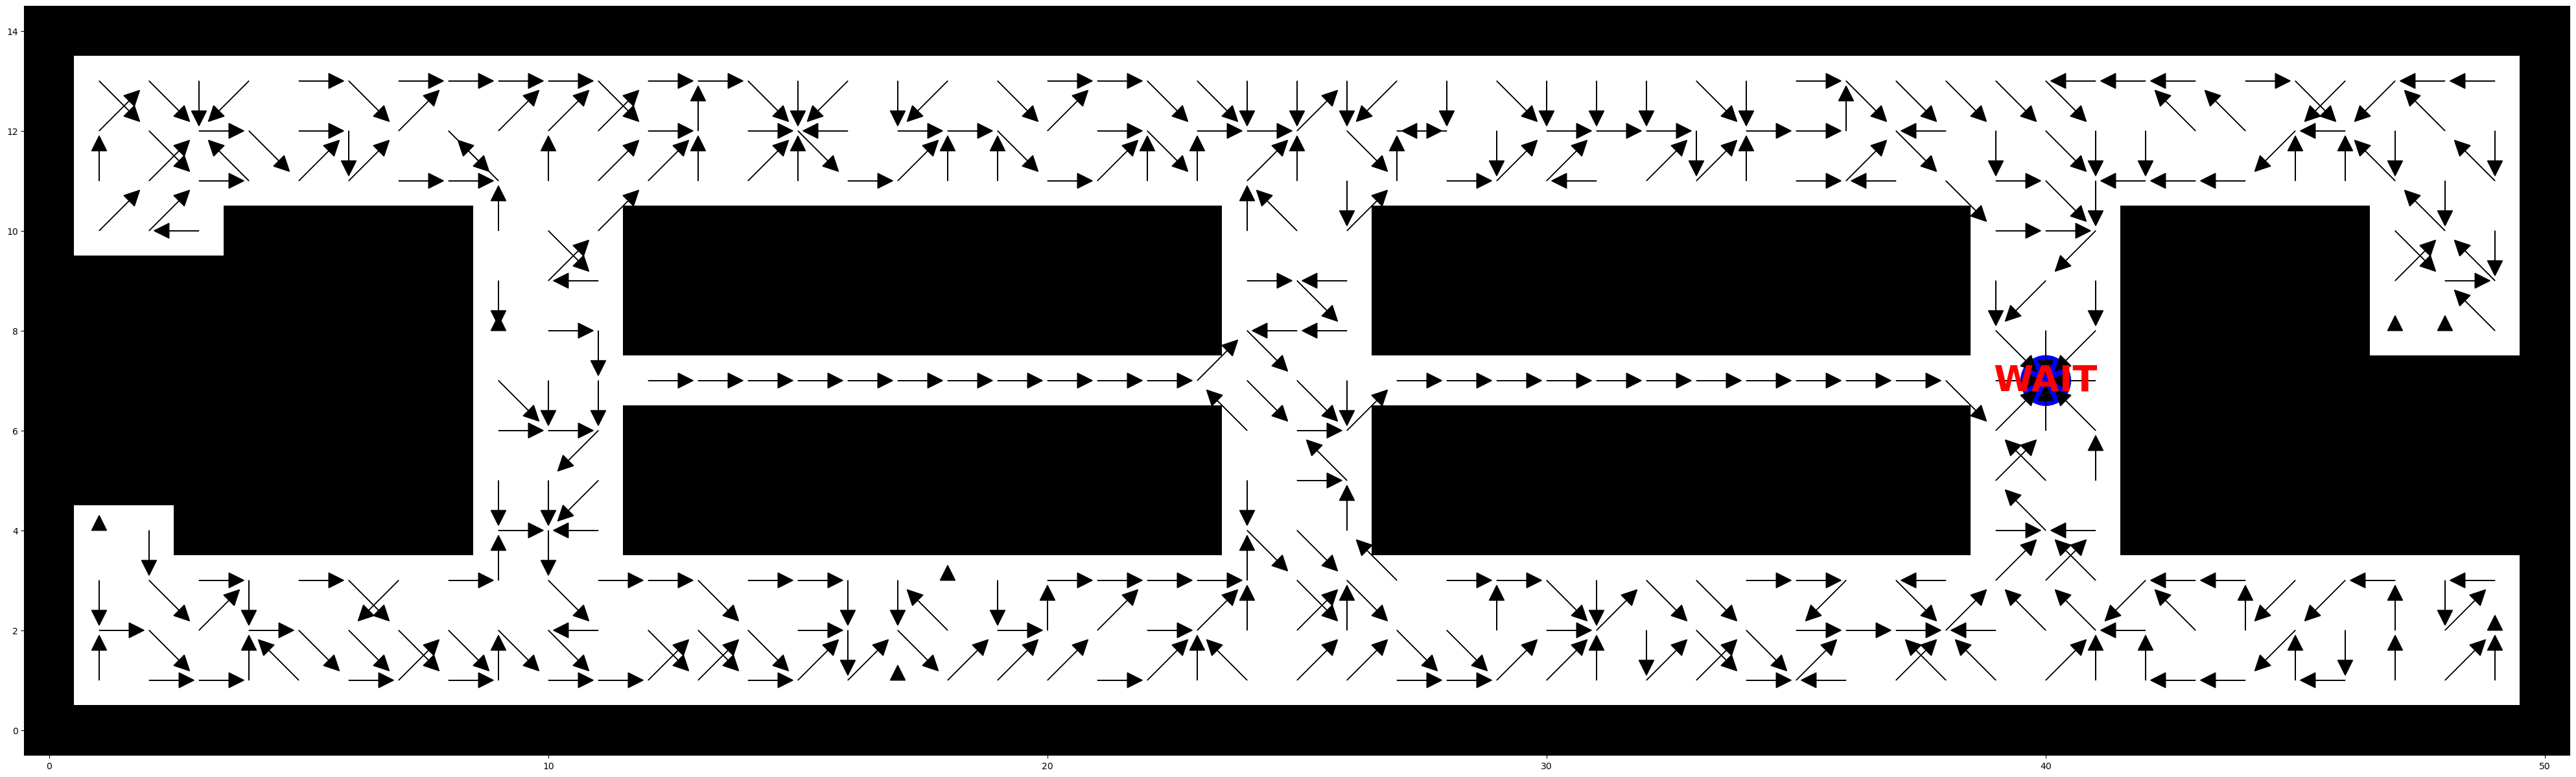

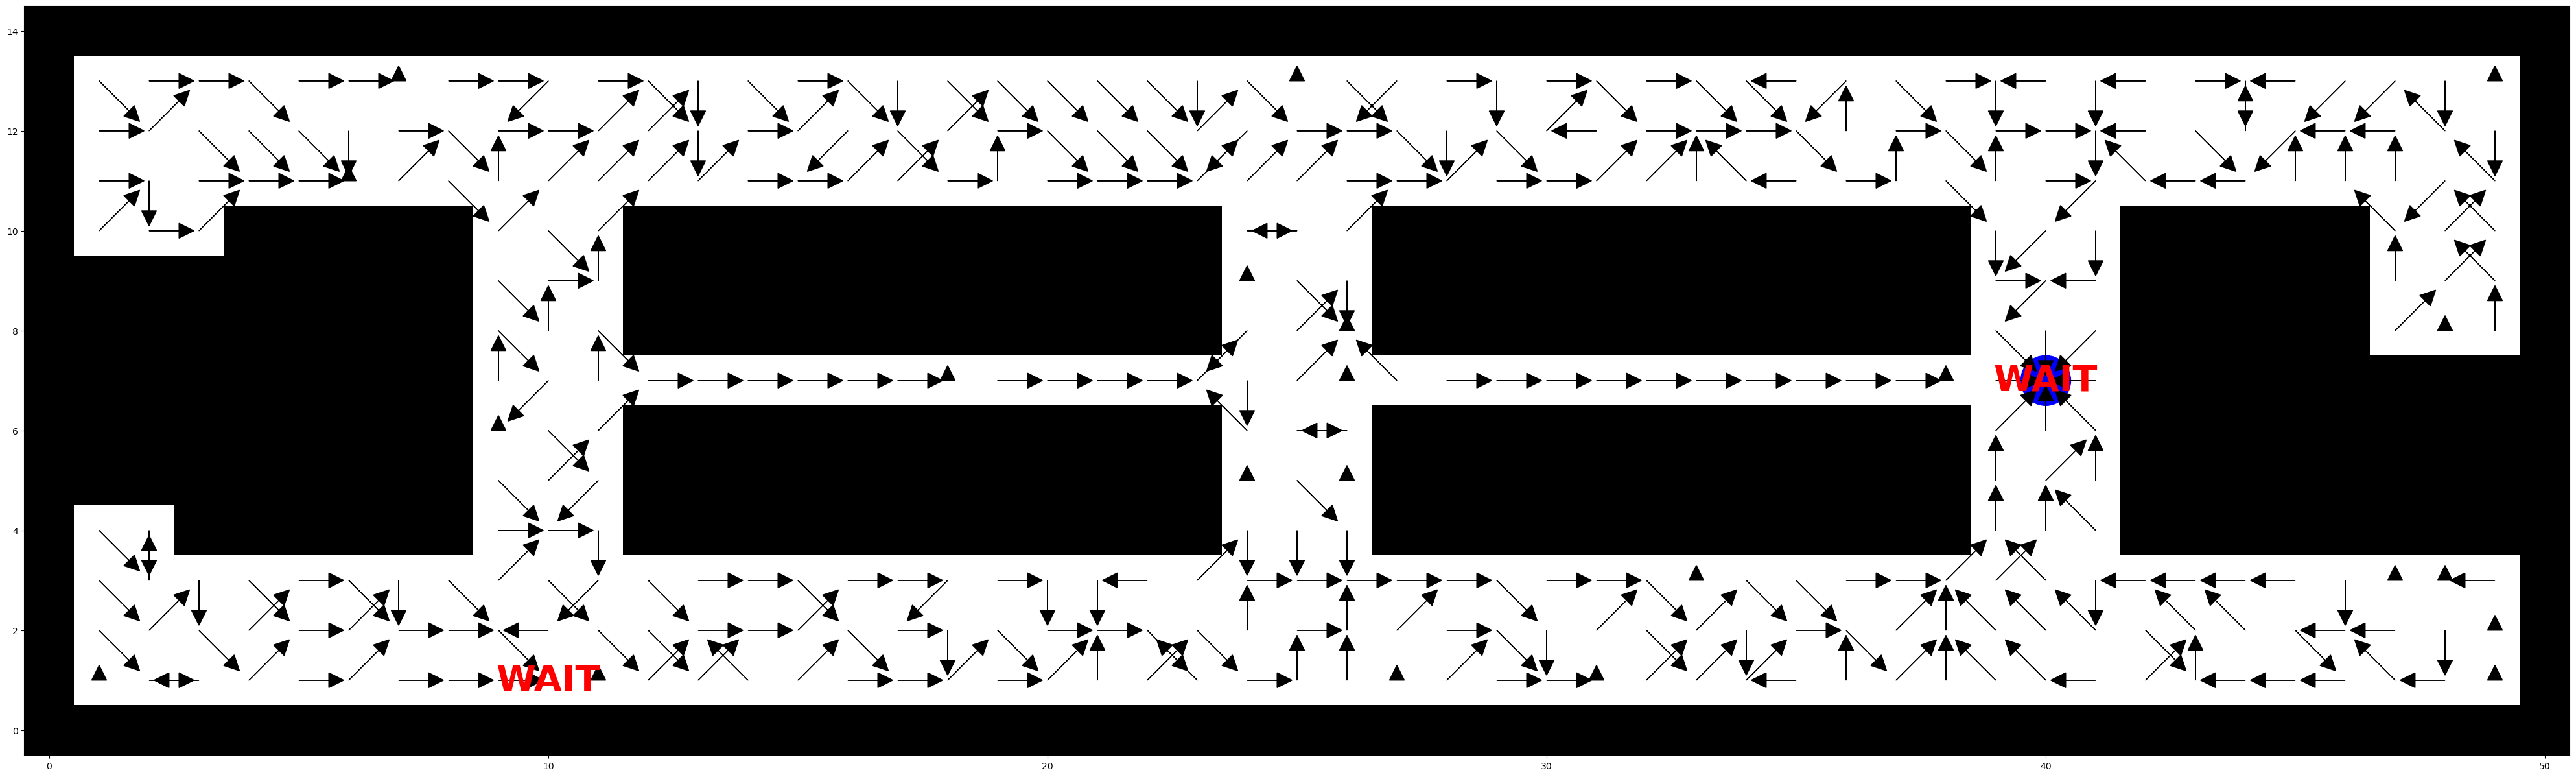

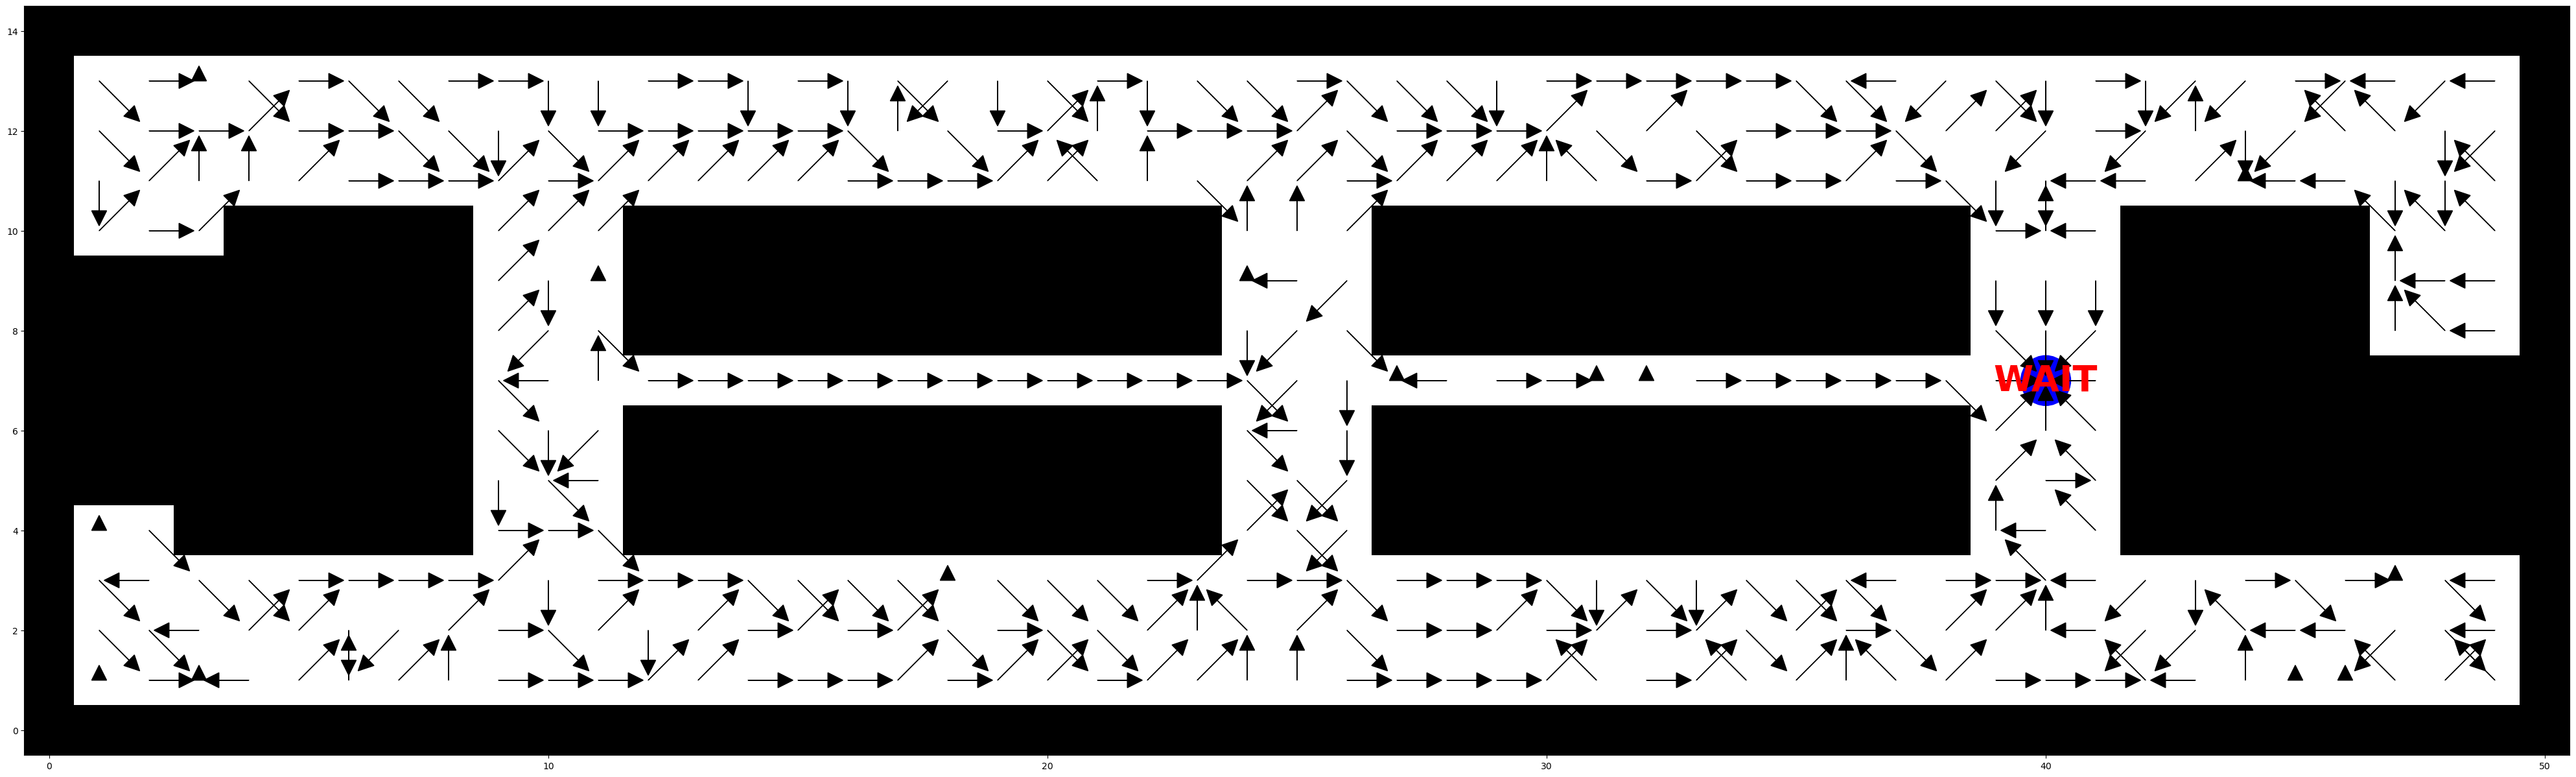

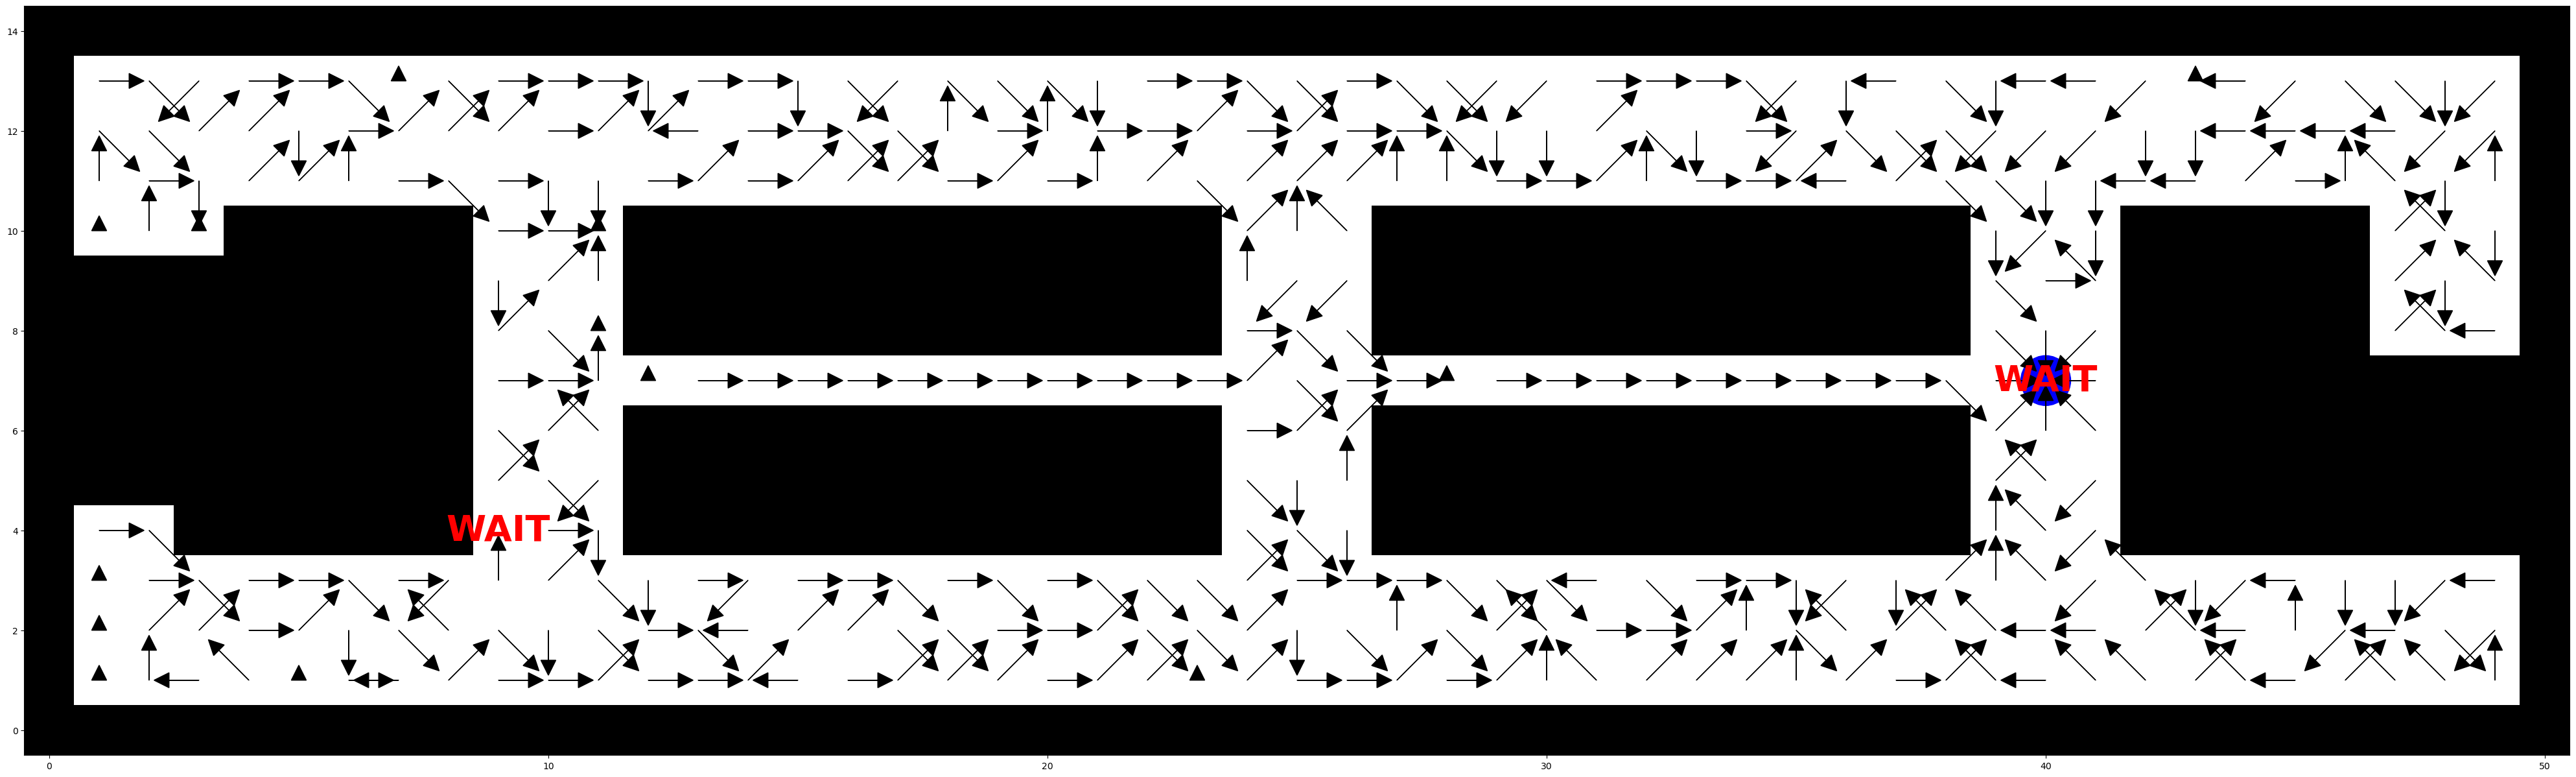

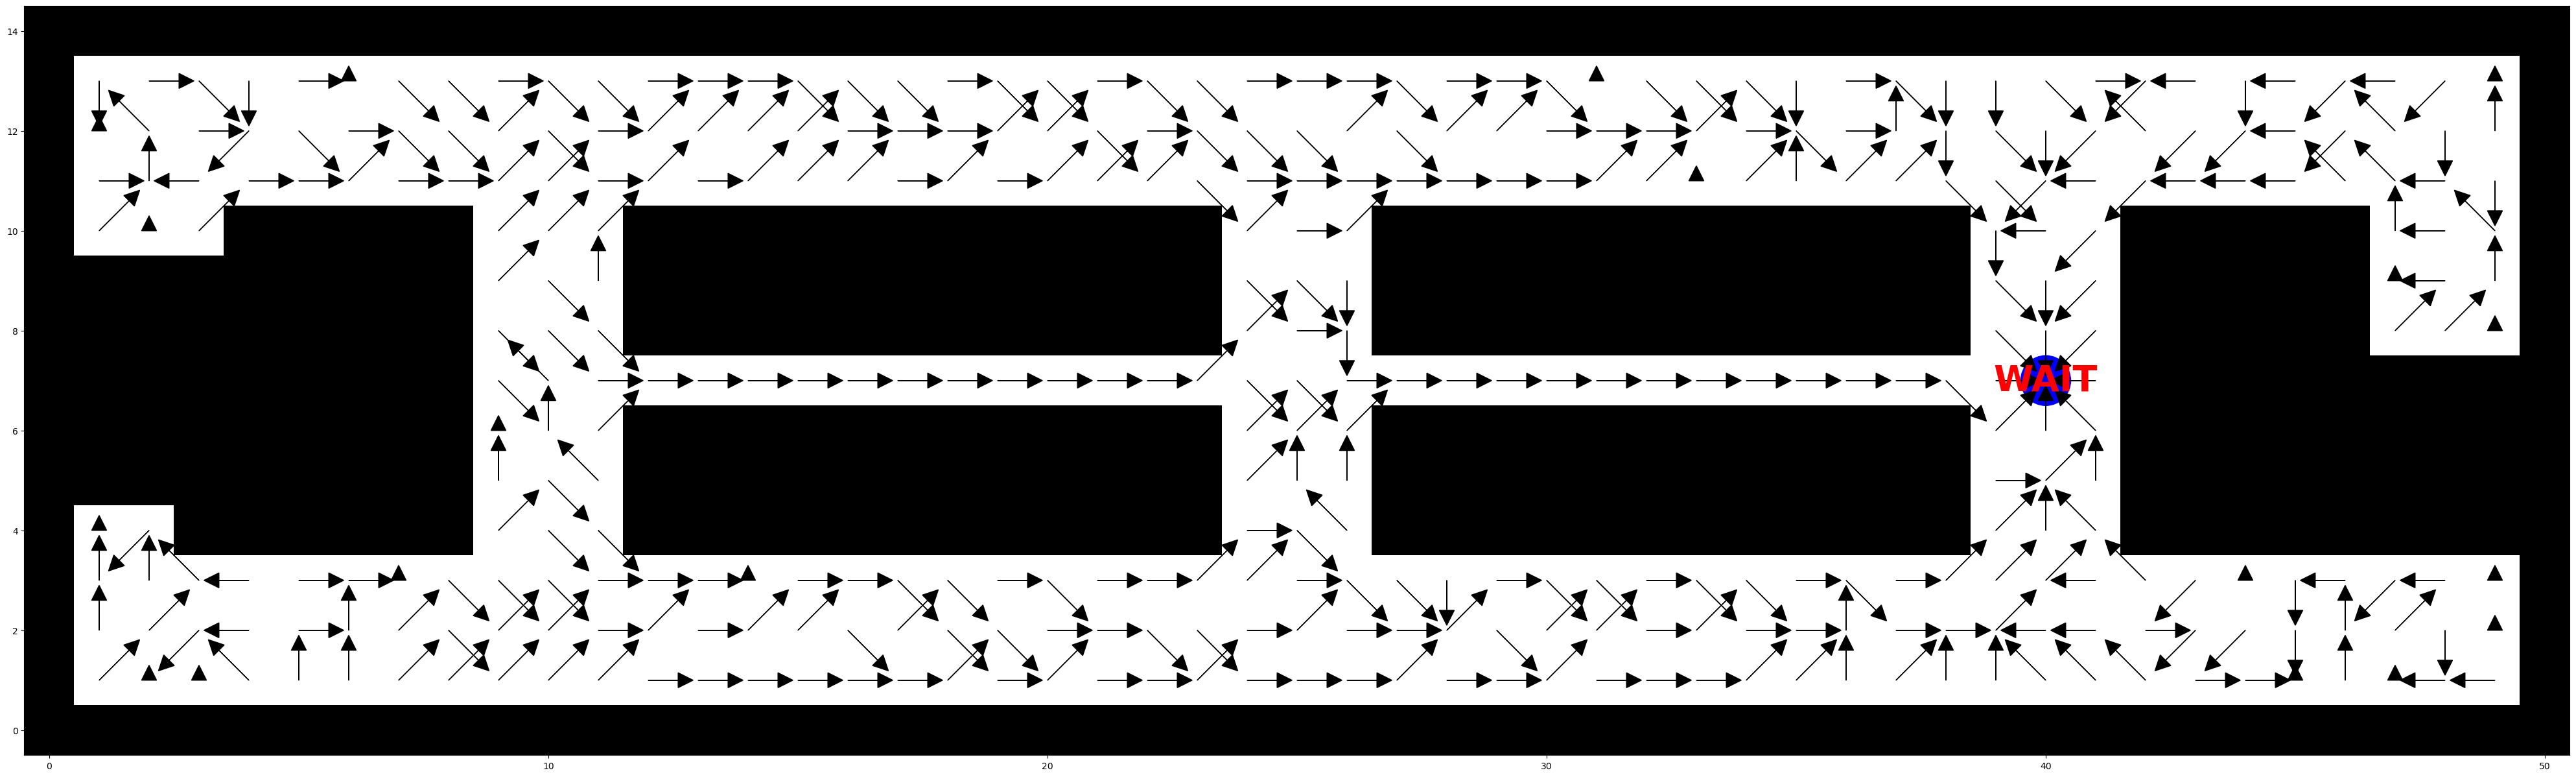

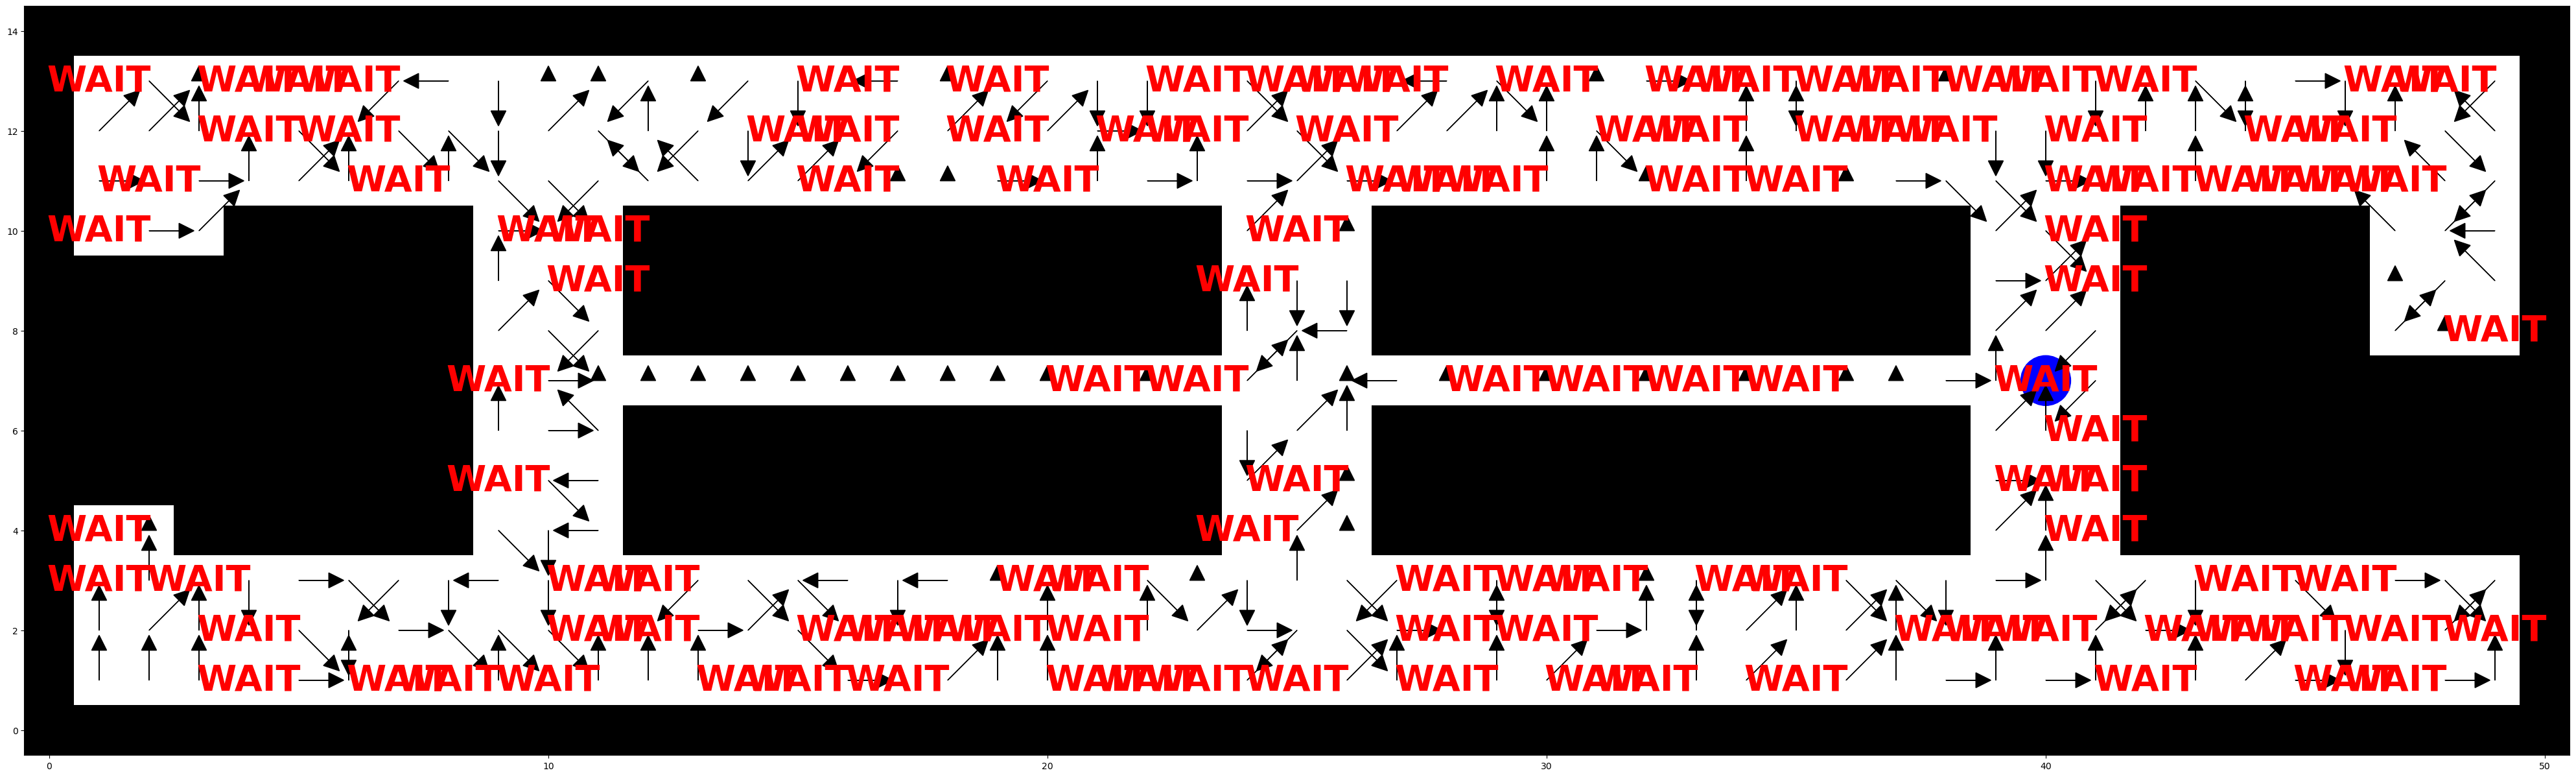

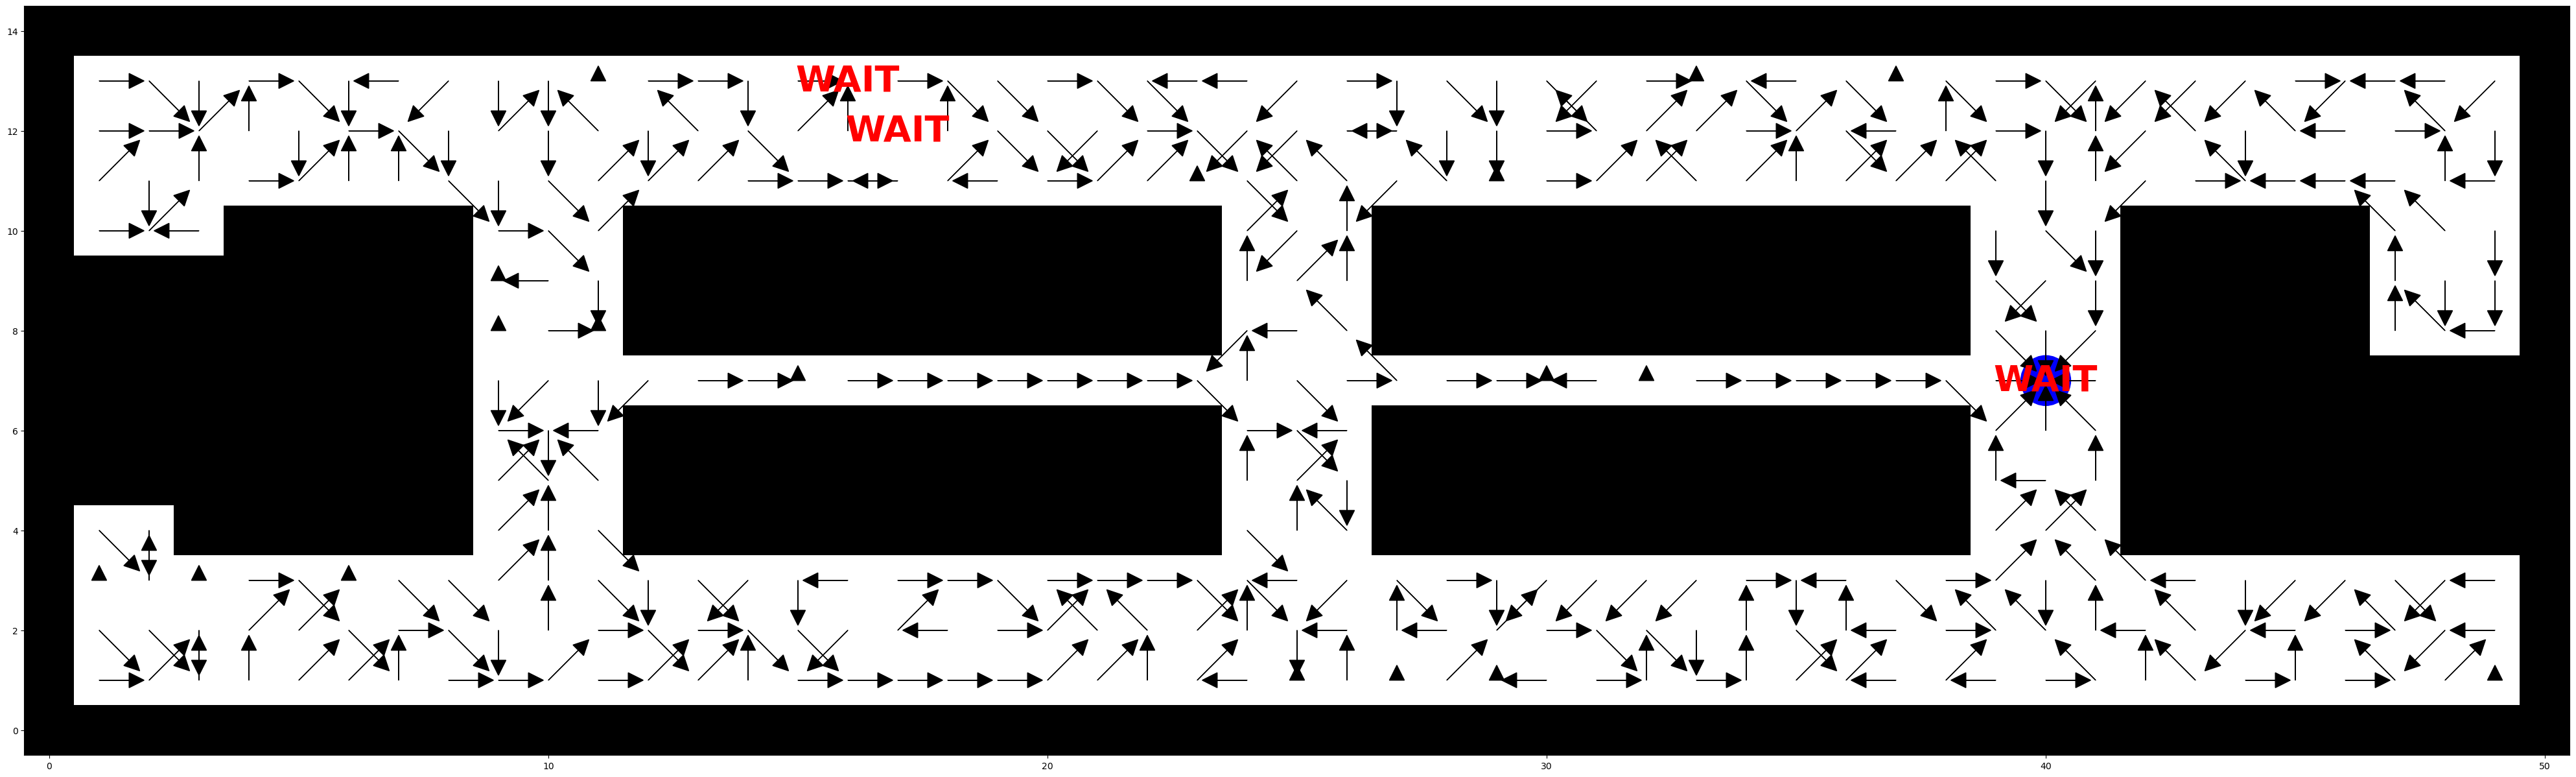

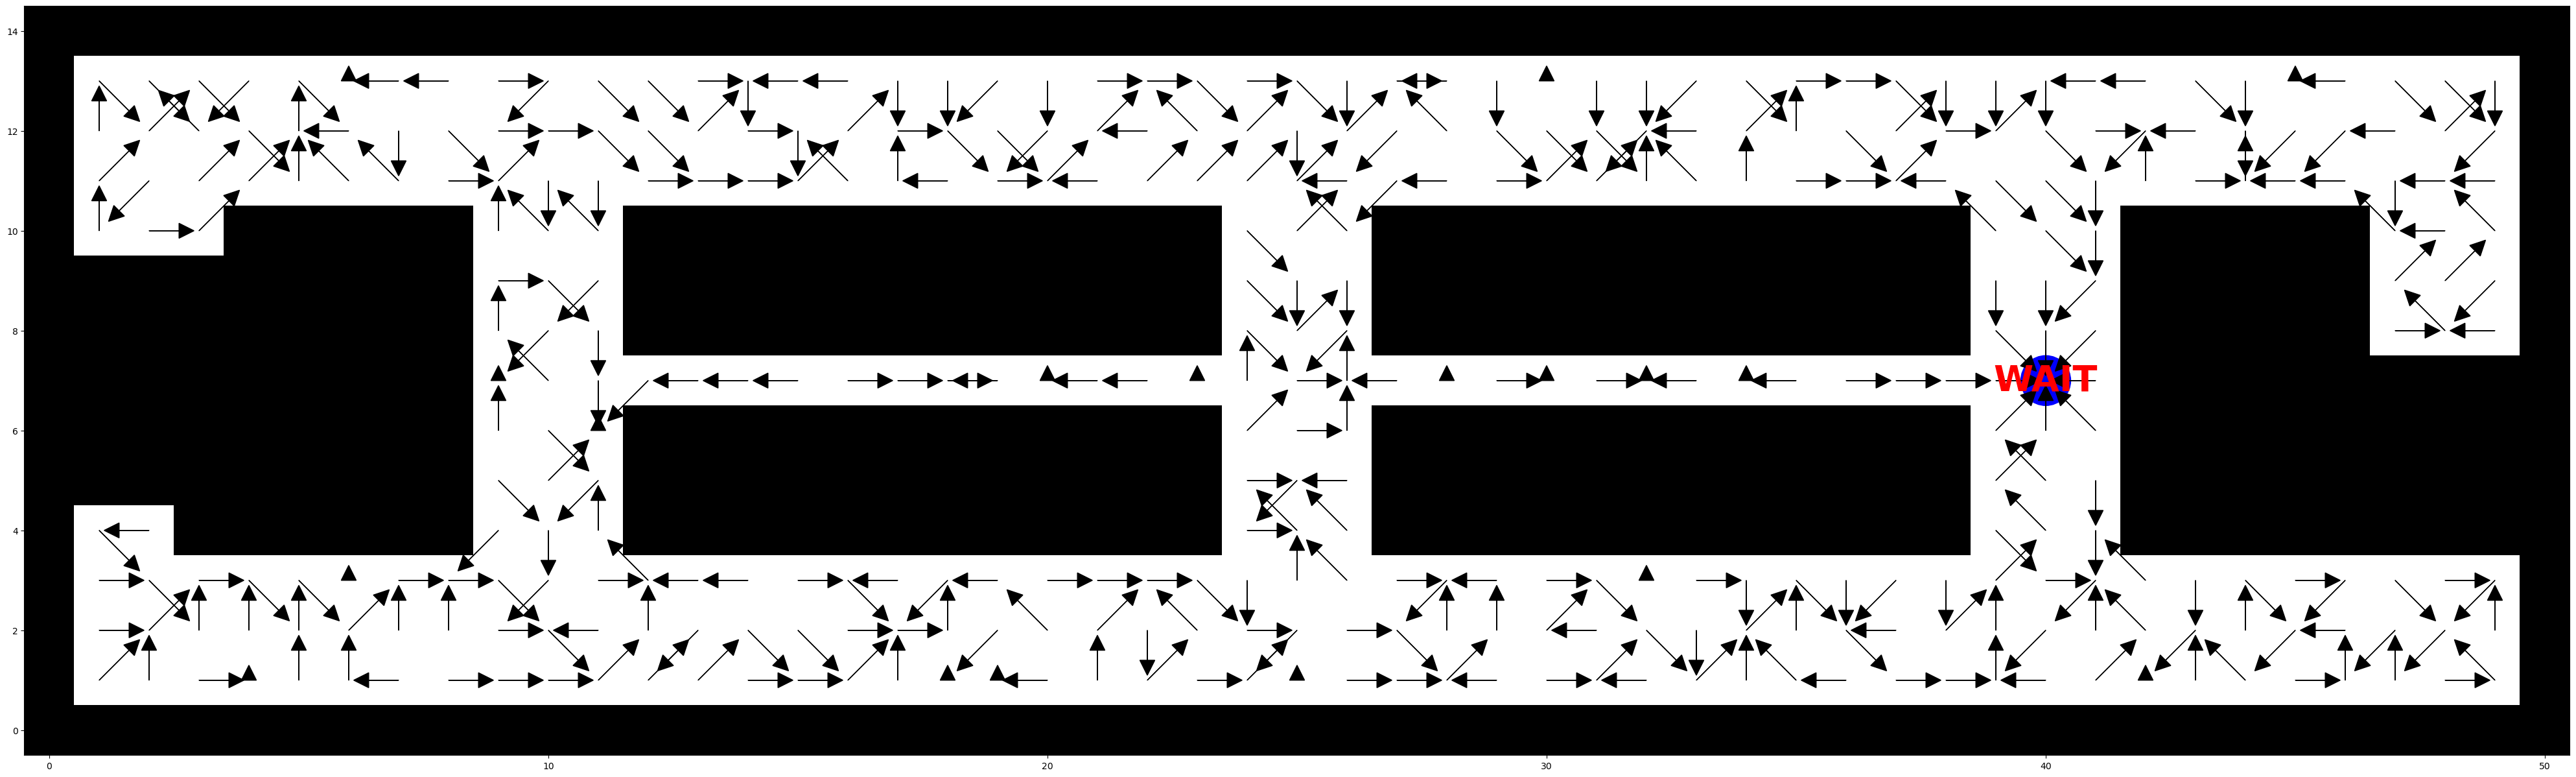

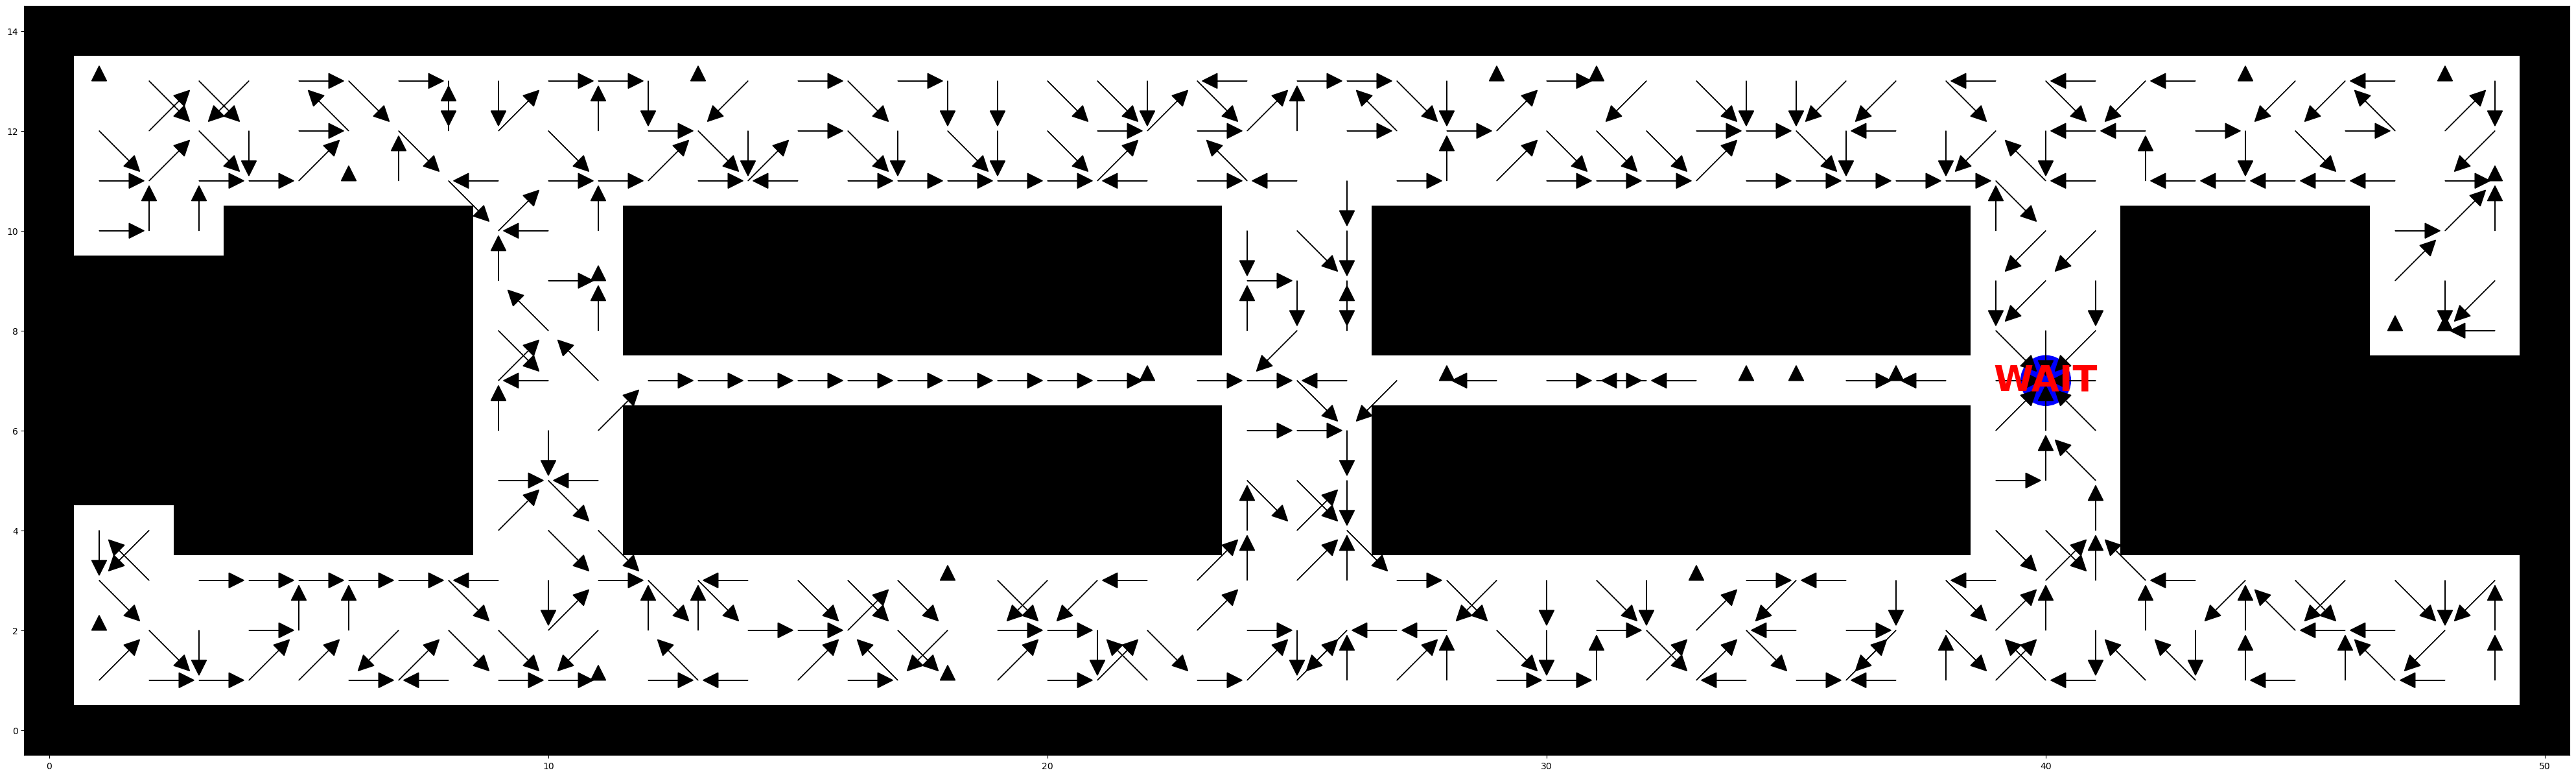

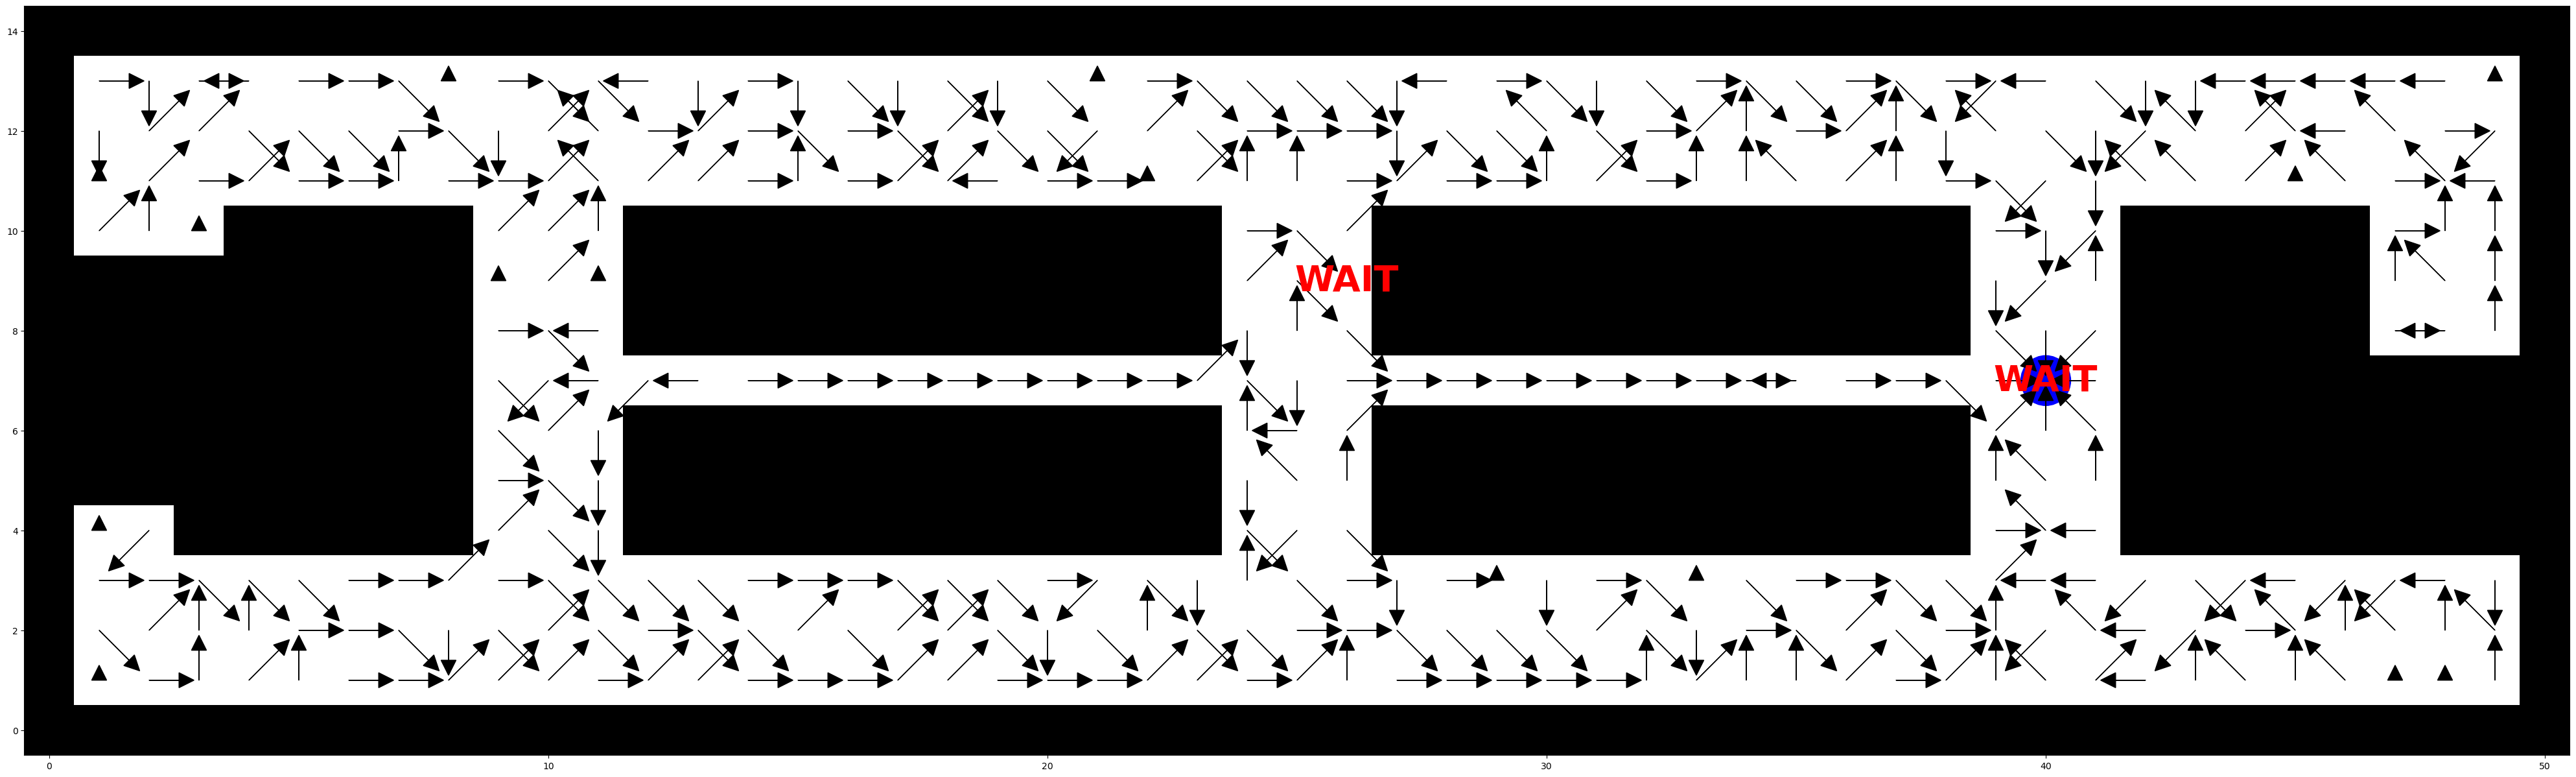

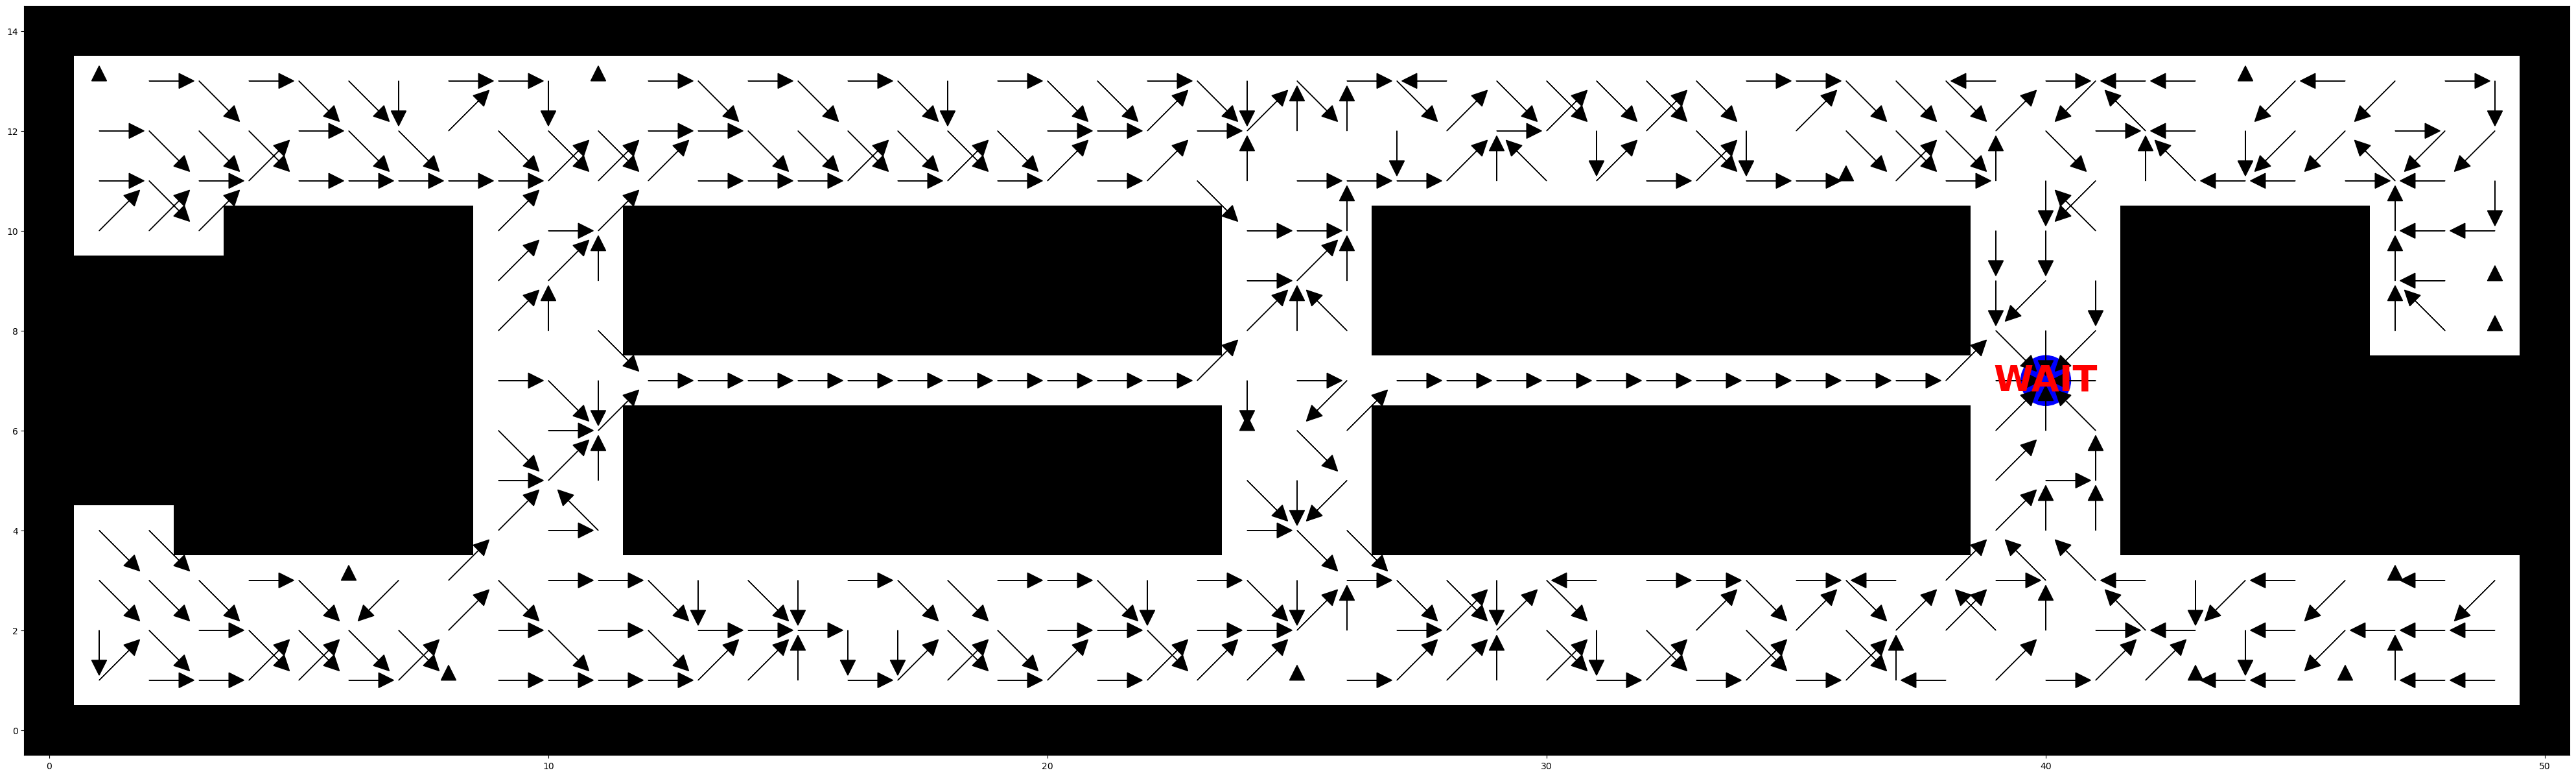

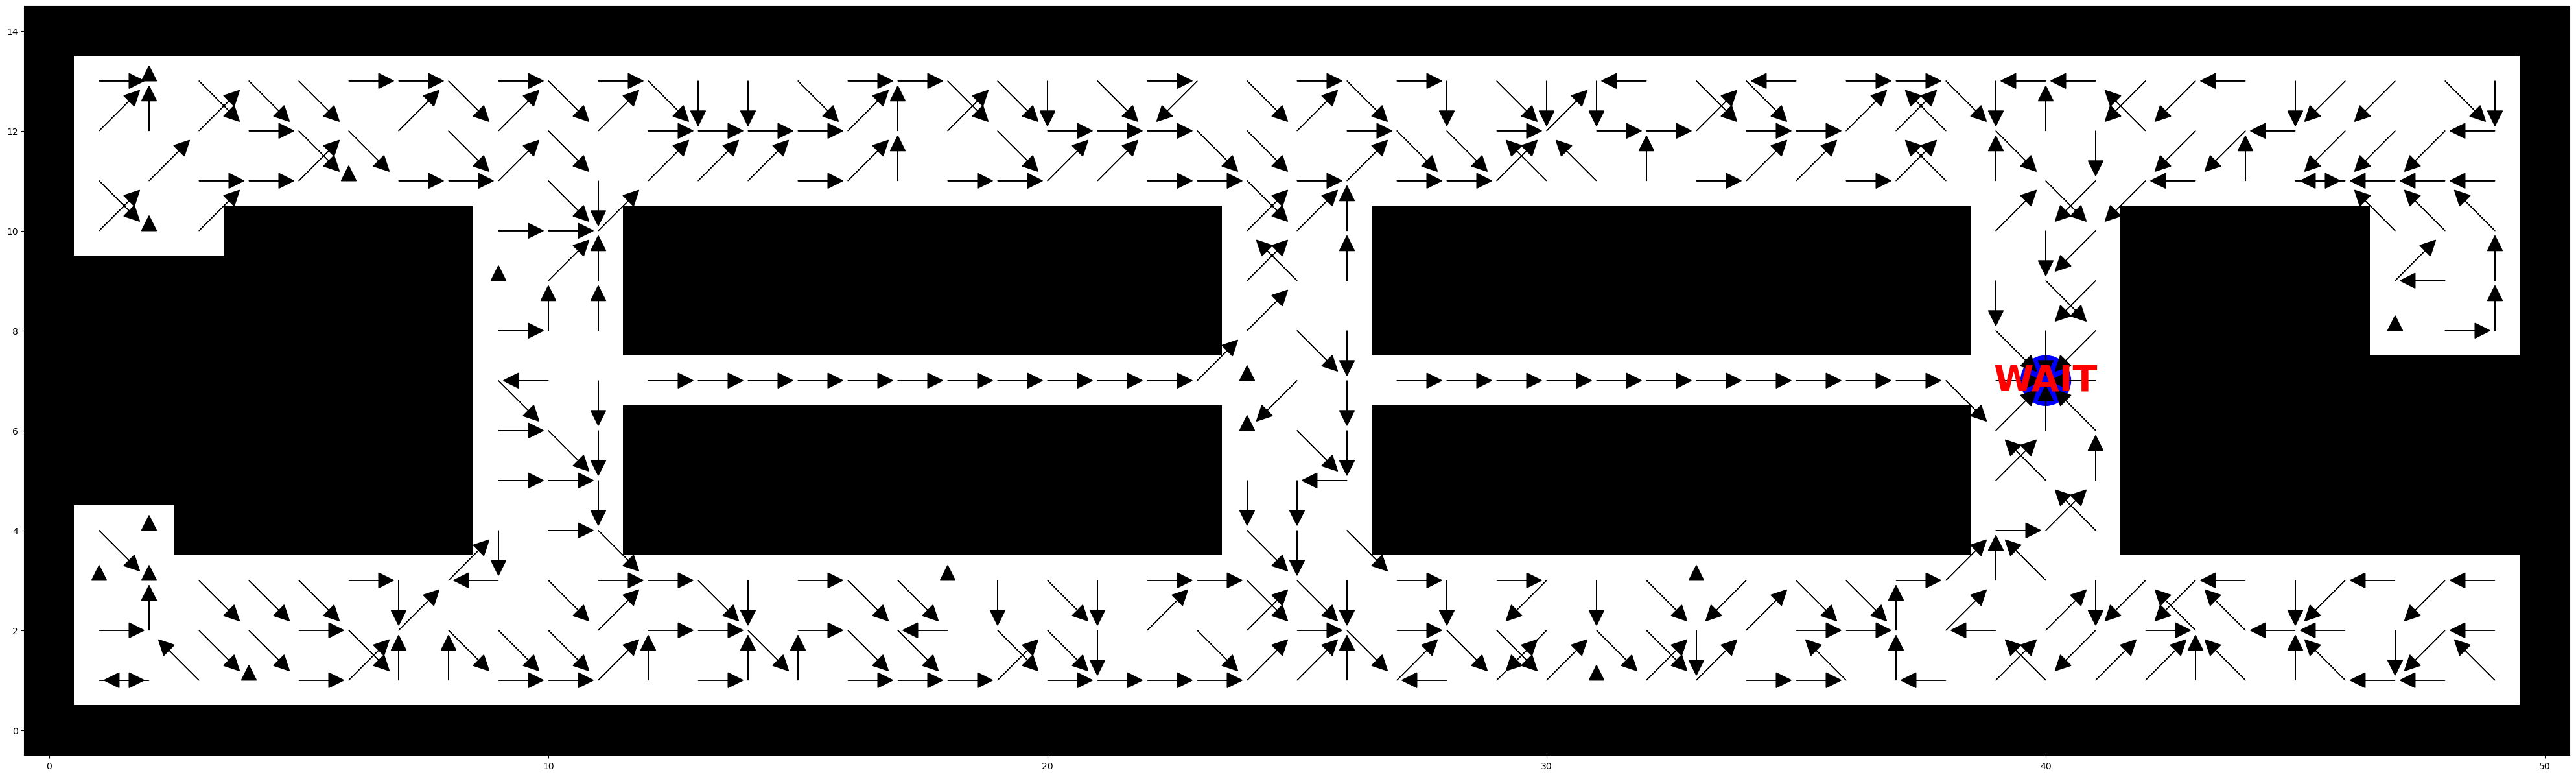

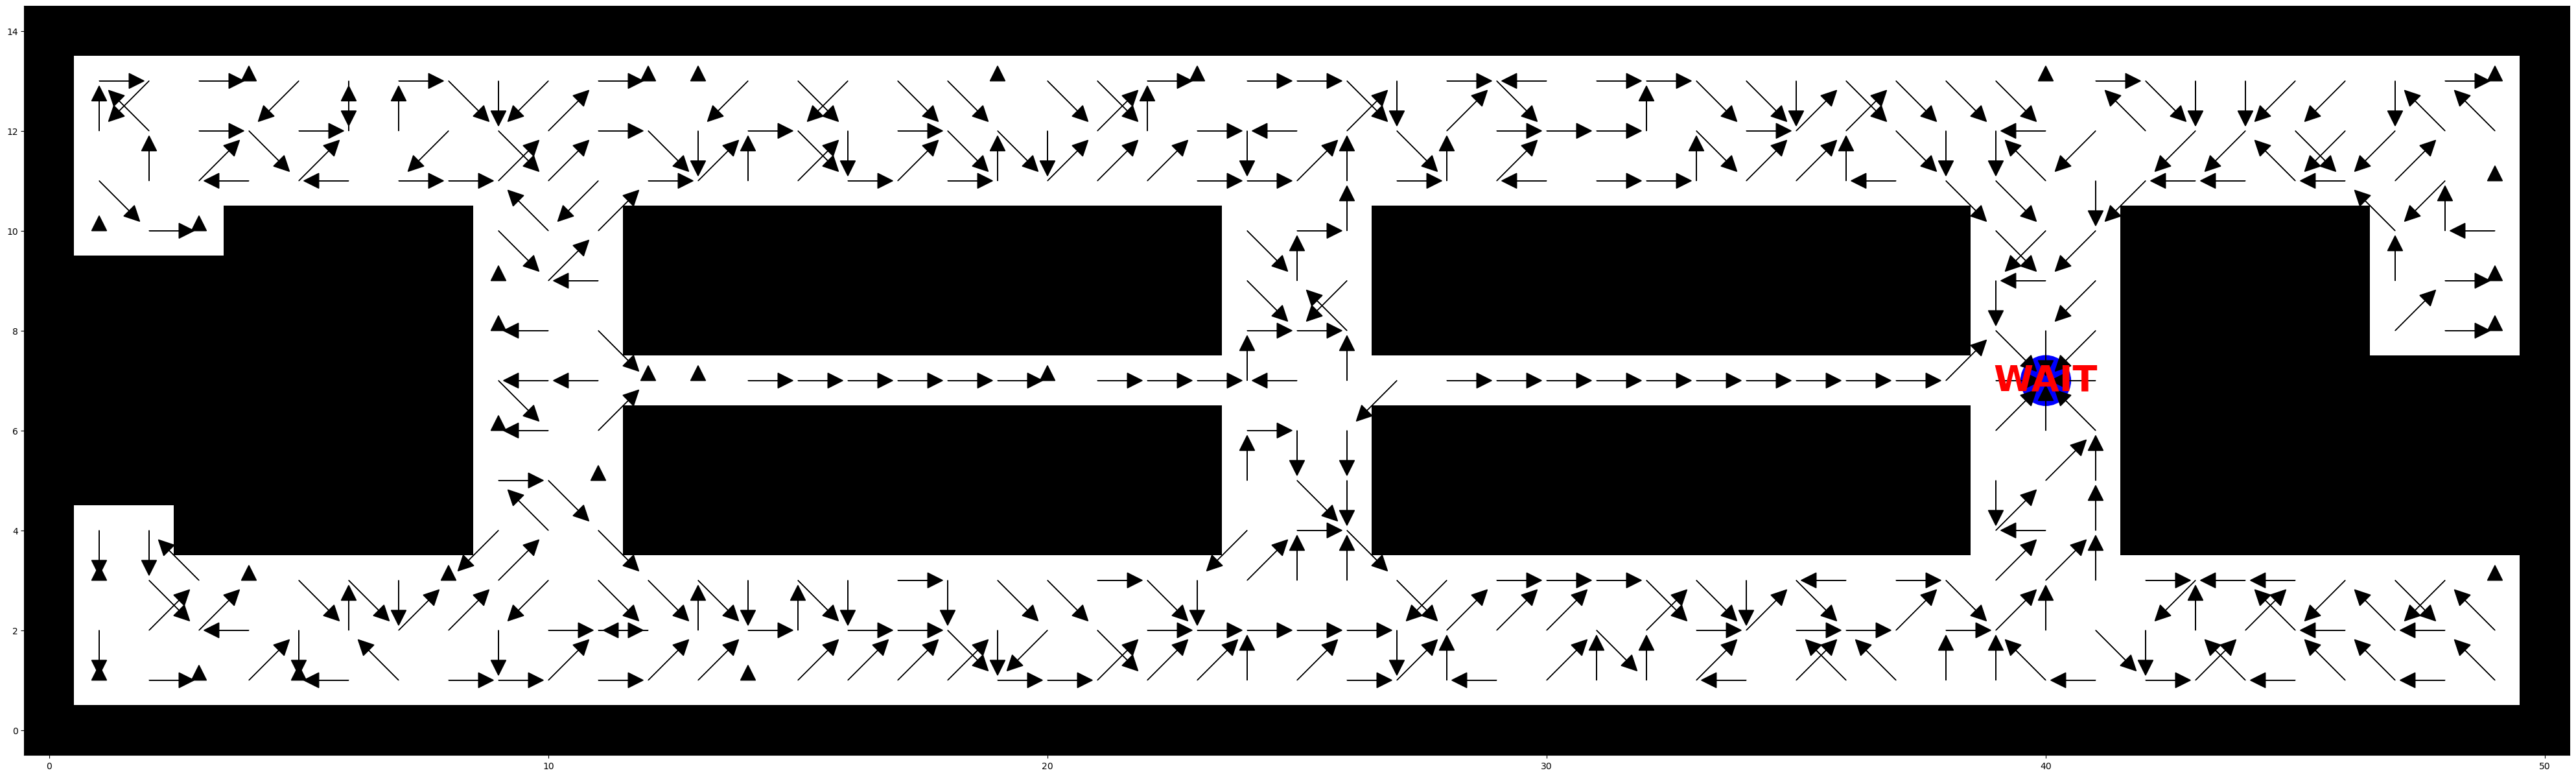

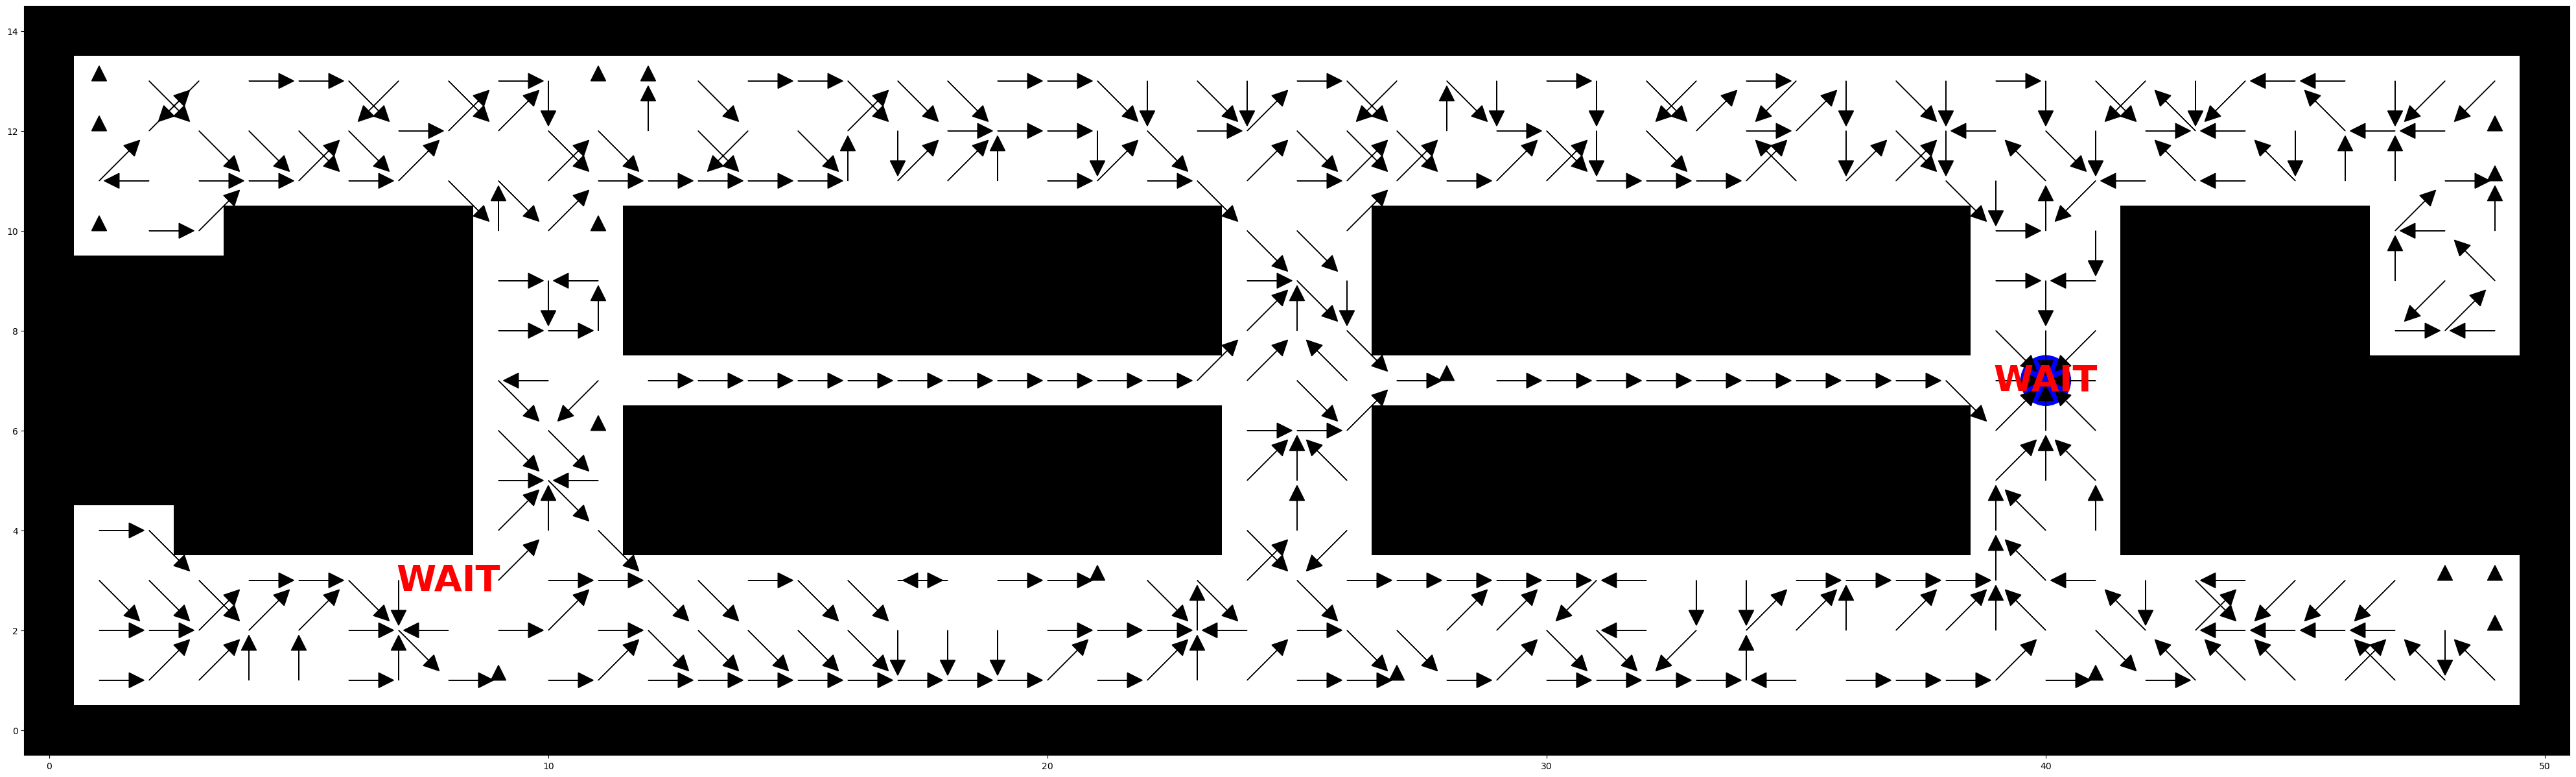

In [297]:
visualiza_politica(politica_sarsa_episodes_low)
visualiza_politica(politica_sarsa_episodes_mid)
visualiza_politica(politica_sarsa_episodes_high)
visualiza_politica(politica_sarsa_steps_low)
visualiza_politica(politica_sarsa_steps_mid)
visualiza_politica(politica_sarsa_steps_high)
visualiza_politica(politica_sarsa_alpha_low)
visualiza_politica(politica_sarsa_alpha_mid)
visualiza_politica(politica_sarsa_alpha_high)
visualiza_politica(politica_sarsa_gamma_low)
visualiza_politica(politica_sarsa_gamma_mid)
visualiza_politica(politica_sarsa_gamma_high)
visualiza_politica(politica_sarsa_epsilon_low)
visualiza_politica(politica_sarsa_epsilon_mid)
visualiza_politica(politica_sarsa_epsilon_high)
visualiza_politica(politica_sarsa_optima)

### Apartado 4: Nuevos mapas y comparativa

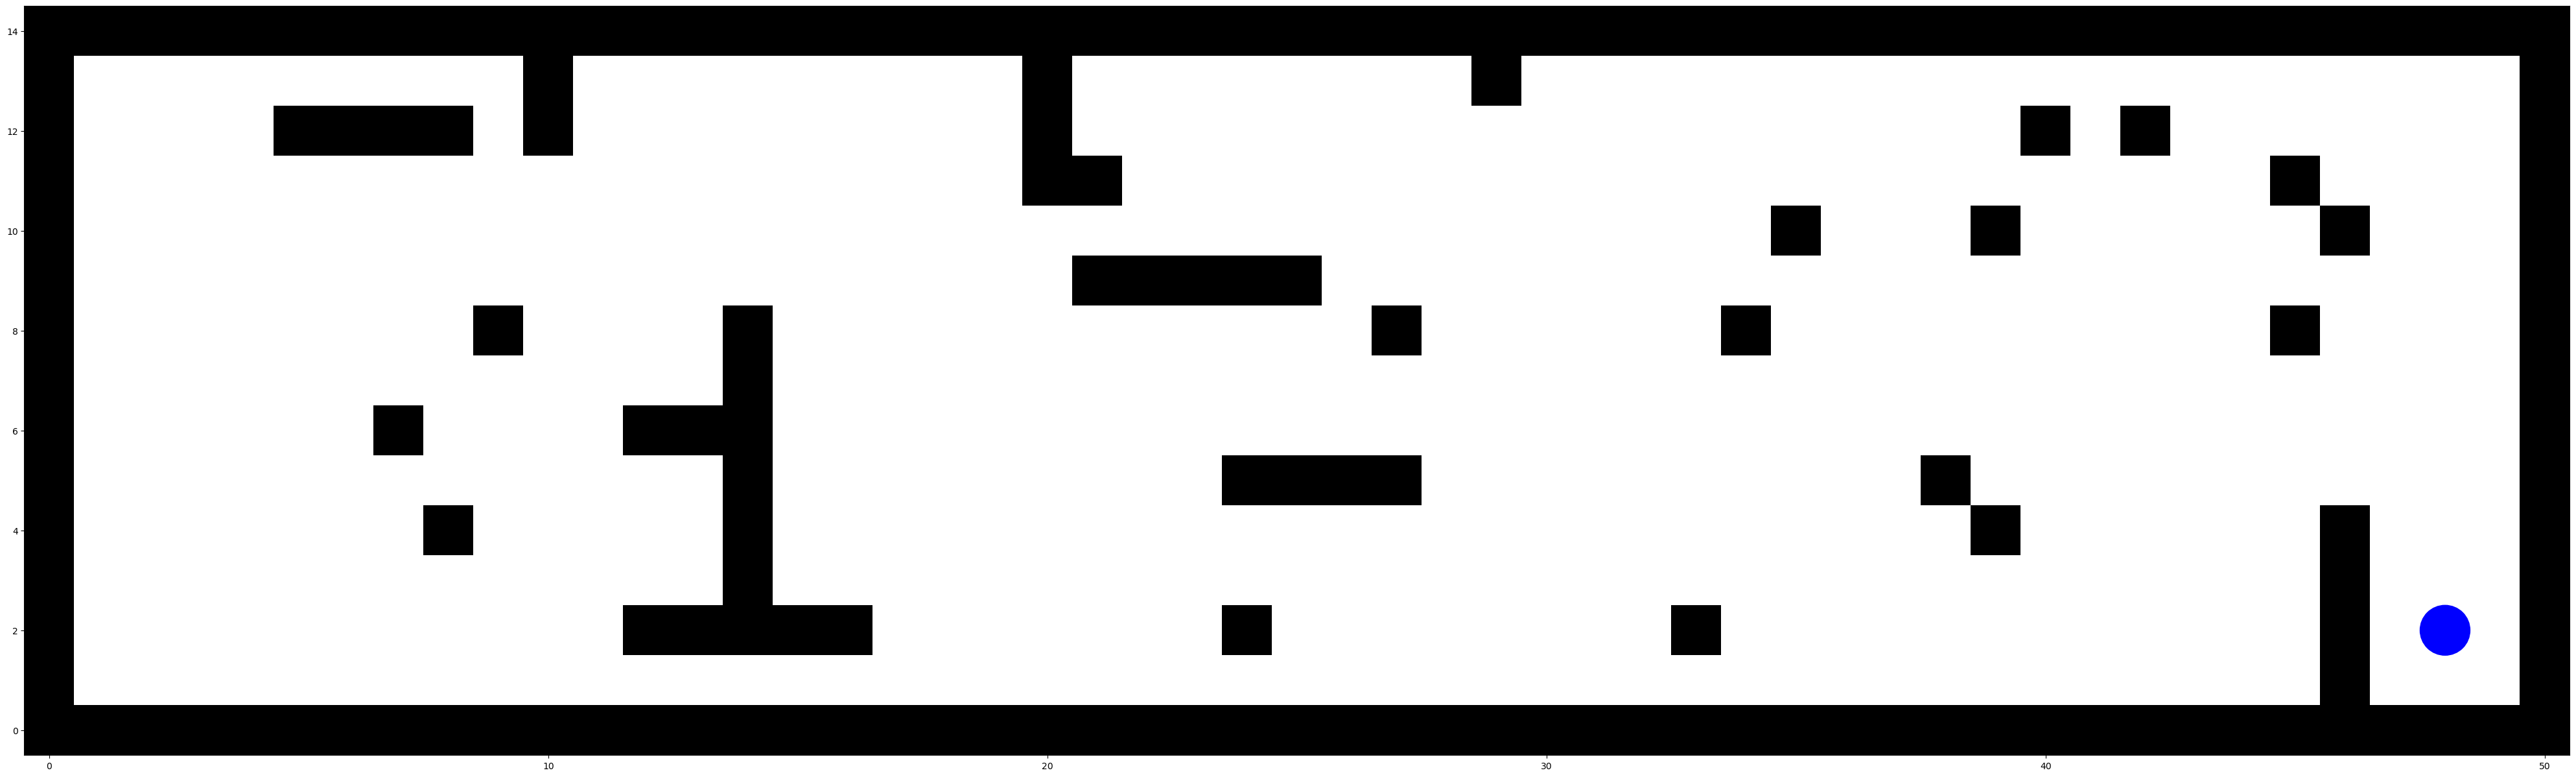

In [309]:
mapa,destino = lee_mapa("map2.txt")
visualiza_mapa()

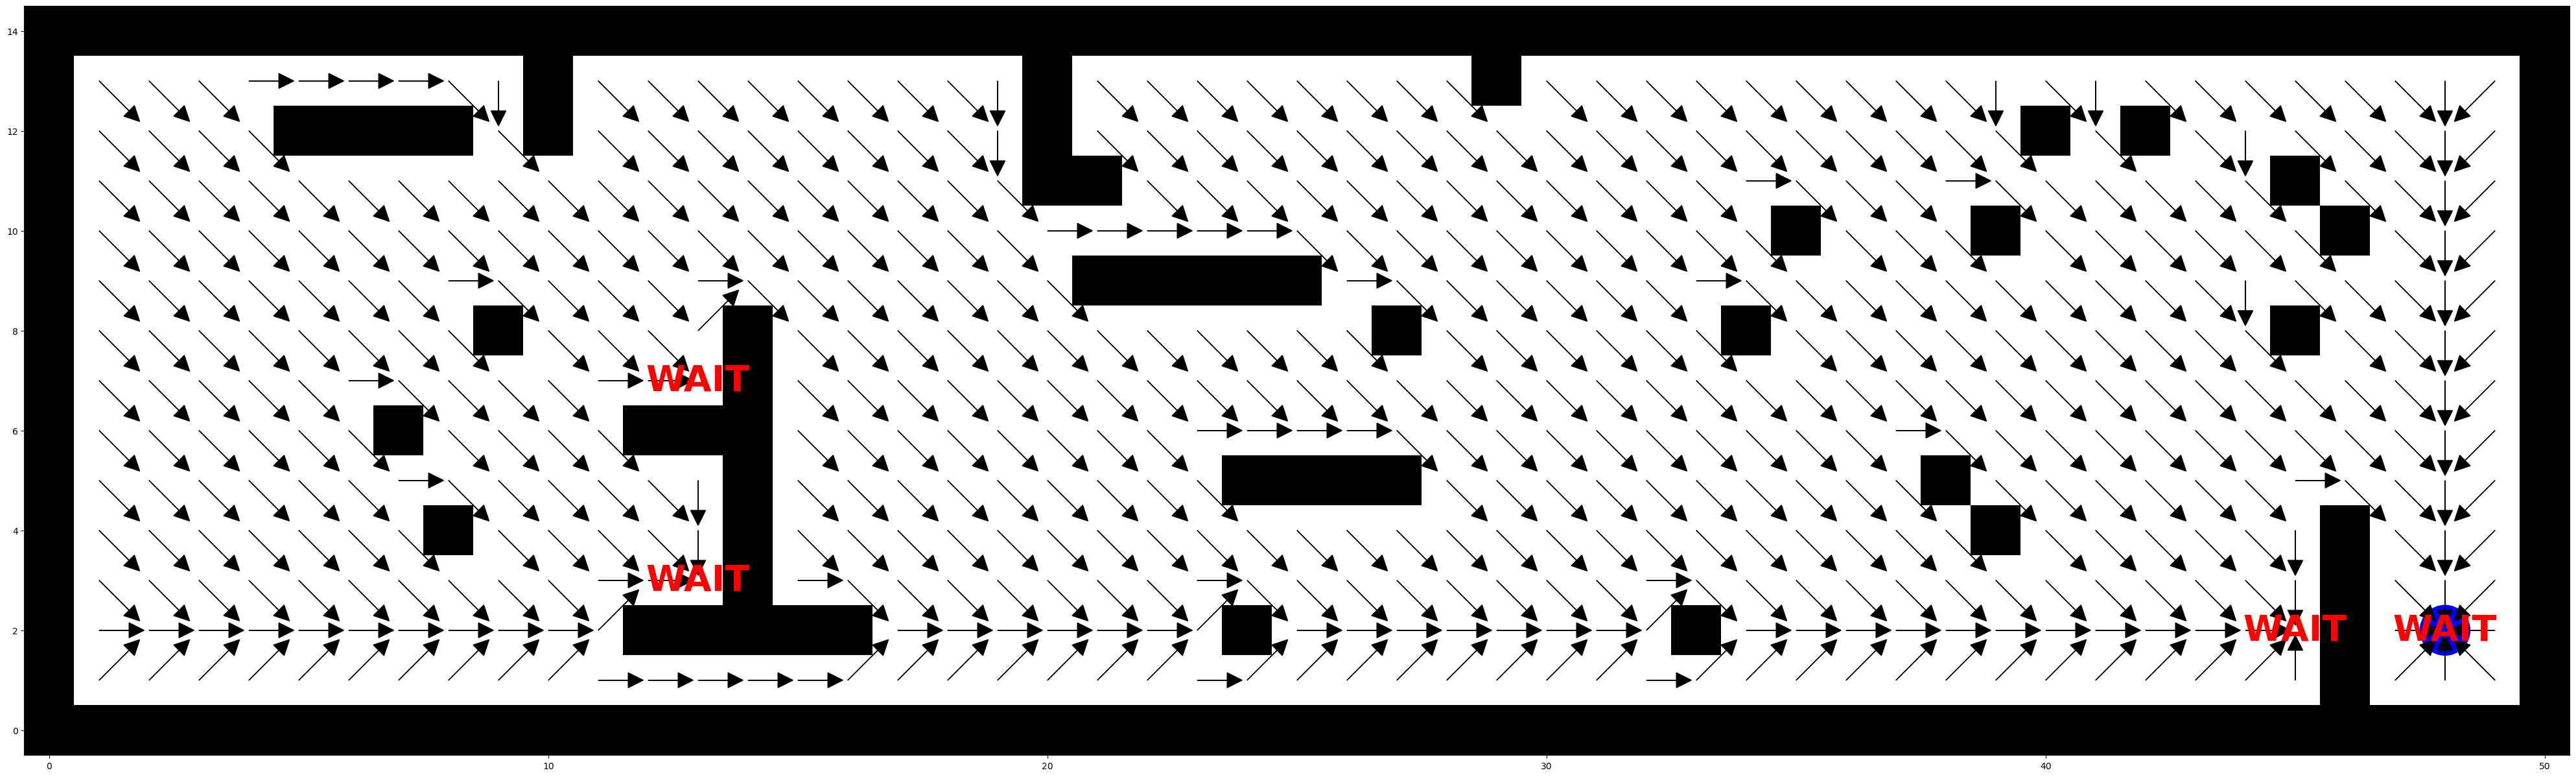

In [310]:
politica_greedy = crea_politica_greedy()
visualiza_politica(politica_greedy)

Ser

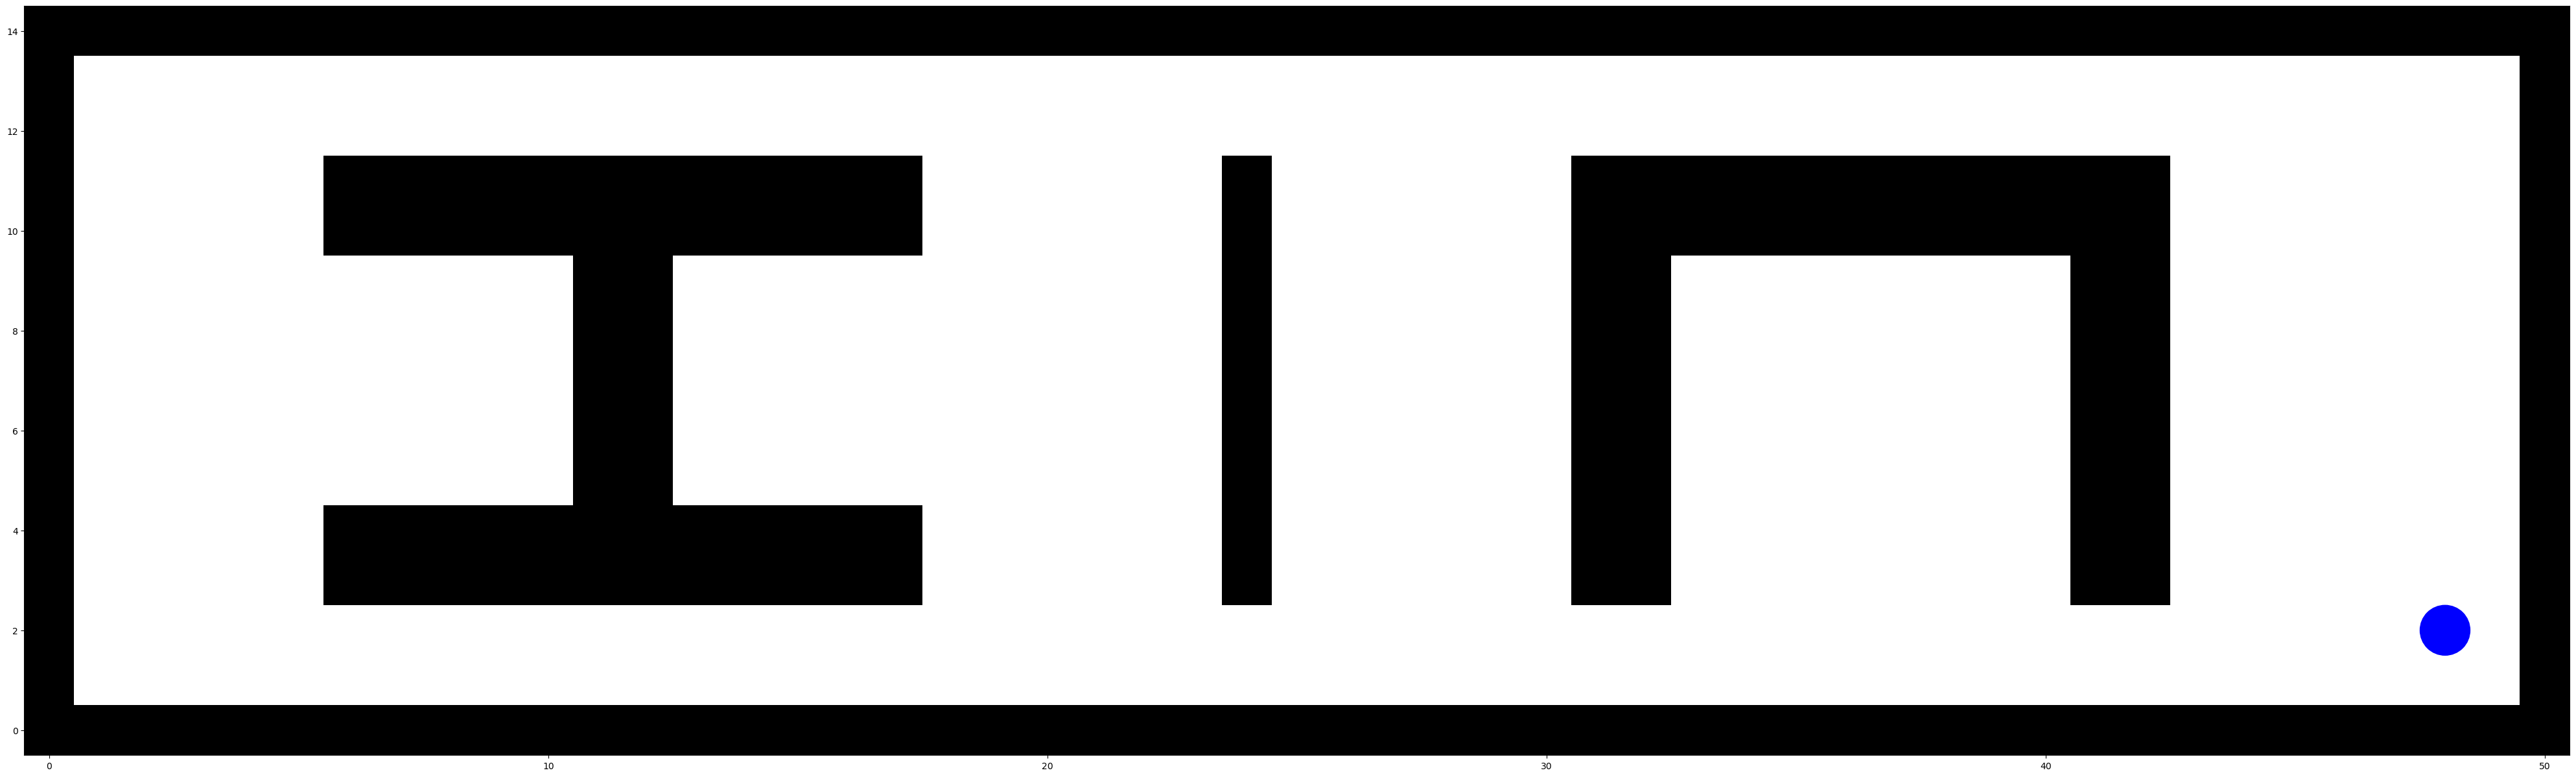

In [305]:
mapa,destino = lee_mapa("map3.txt")
visualiza_mapa()

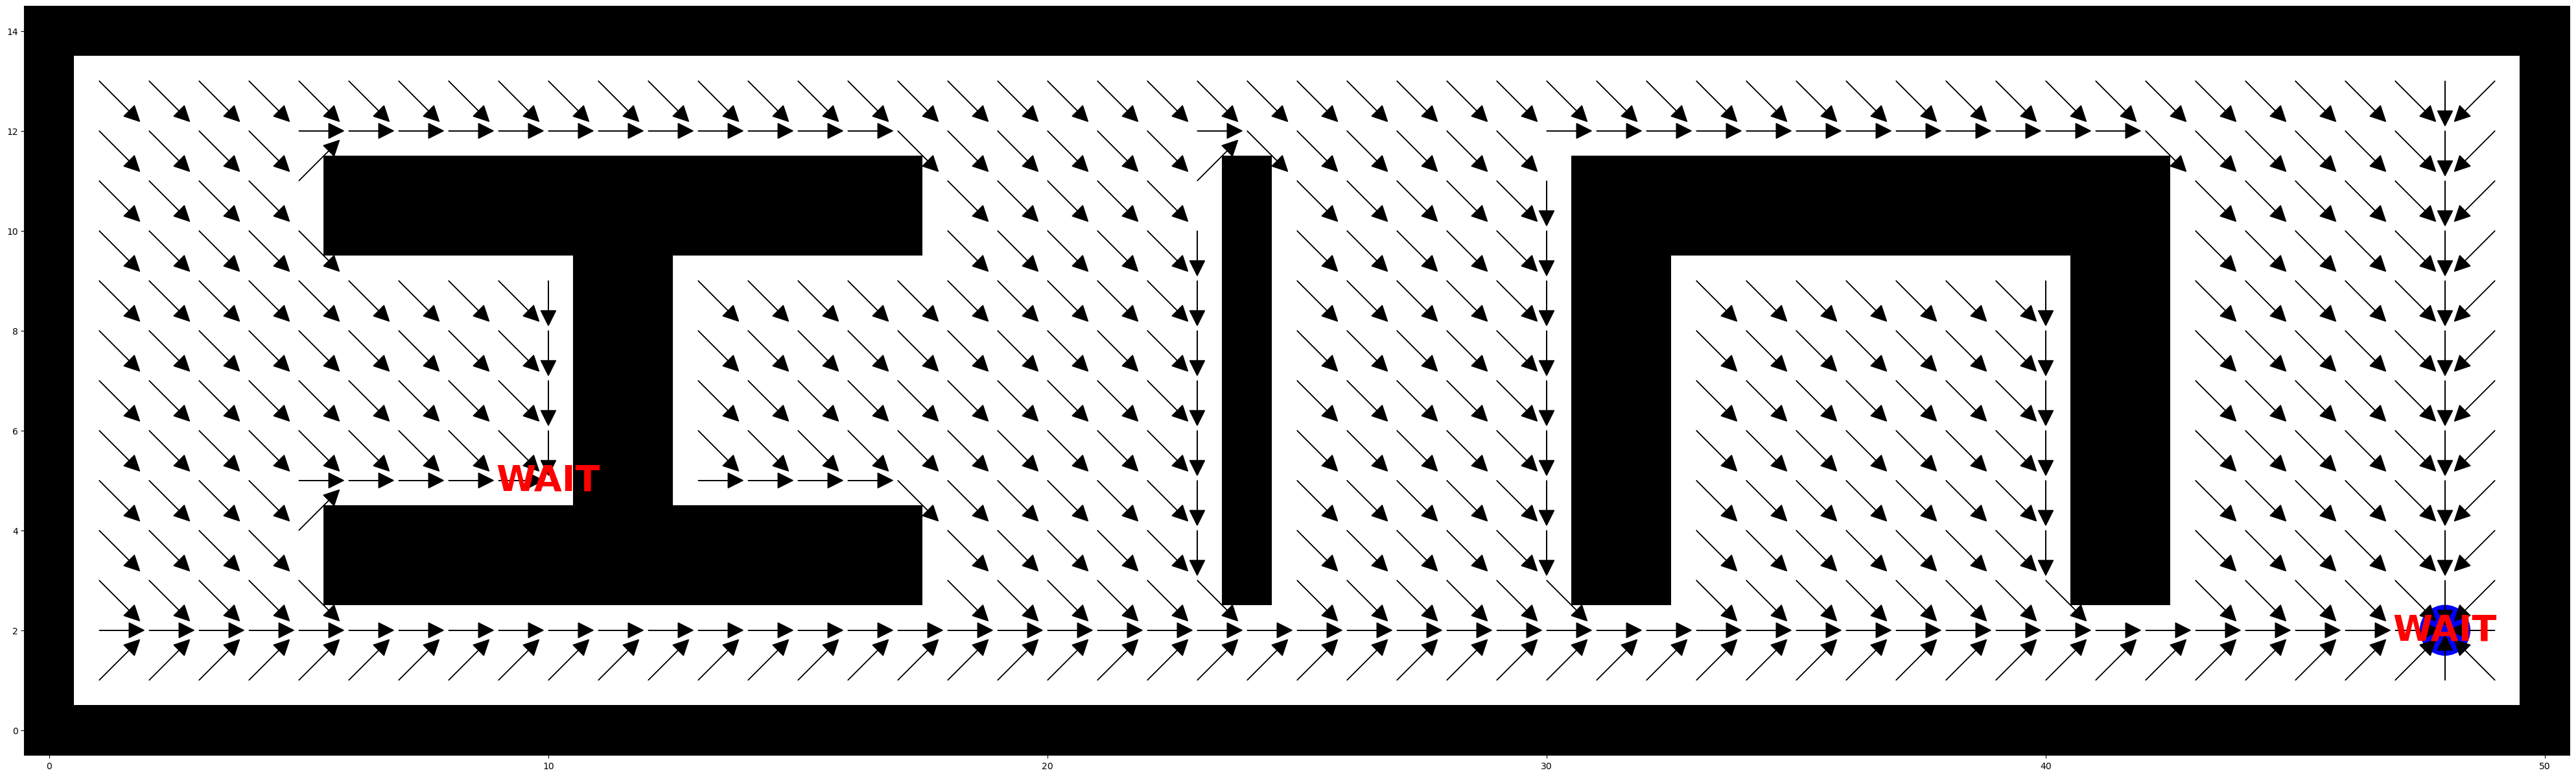

In [308]:
politica_greedy = crea_politica_greedy()
visualiza_politica(politica_greedy)

Al calcular la política Greedy, vemos que se queda parado en una parte del mapa en "Wait", al ejecutar uno de los algoritmos de aprendizaje por refuerzo sin embargo intenta volver para atrás, ya que tiene en cuenta los intentos anteriores.